<a href="https://colab.research.google.com/github/Carlos-Rodero/kduino-data-analysis-notebook/blob/main/Kduino_Data_Analysis_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install mooda===2.0.0

import mooda as md
from datetime import datetime
import pandas as pd
import xarray as xr
import numpy as np
from numpy import interp
import math
import glob
import yaml
import os
import re
import shutil
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import netCDF4 as nc
from scipy import stats, interpolate
from io import StringIO
from datetime import datetime
from xarray import Dataset
from plotly.io import to_html
import warnings
from google.colab import files

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
#@title Remove old files and create new folders

!rm /content/*txt
!rm /content/*csv
!rm /content/*nc
!rm /content/*pkl
!rm -rf sample_data
!rm -rf outputs
!rm -rf results

os.makedirs('results', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

rm: cannot remove '/content/*txt': No such file or directory
rm: cannot remove '/content/*csv': No such file or directory
rm: cannot remove '/content/*nc': No such file or directory
rm: cannot remove '/content/*pkl': No such file or directory


<p><img alt="logo" height="150px" src='https://drive.google.com/uc?export=view&id=11Swg70eHalalGMv8HemoK6l7qu3XRuLC' align="center" hspace="10px" vspace="0px"/></p>
<h1><b>KdUINO Data Analysis Notebook</b></h1>

The KdUINO Data Analysis Notebook is a Jupyter Notebook hosted by Google Colab designed to analyze data files from [KdUINO](https://monocle-h2020.eu/Sensors_and_services/KdUINO) instrumentation. Also, provide methods to generate plots and convert data files in netCDF and CSV format.</br>This Notebook works with different versions of KdUINO:
*   KduPRO
*   KduPRO-Multi
*   KduSTICK
*   KduMOD Professional
*   KduMOD Low-Cost

</br>

---

<p align="center">
<img alt="logo" height="100px" src='https://git.csic.es/36579996Z/kduino-data-analysis/-/raw/master/docs/img_docs/logo.png' align="center" hspace="10px" vspace="0px"/>
</p>

This project has received funding from the European Union's Horizon 2020 research and innovation programme under grant agreement No 776480 ([MONOCLE](https://monocle-h2020.eu/)).

<p align="center">
<img alt="logo" height="100px" src='https://raw.githubusercontent.com/Carlos-Rodero/kduino-data-analysis-notebook/refs/heads/main/docs/img_docs/logo_pitacora.png'/>

<img alt="logo" height="100px" src='https://raw.githubusercontent.com/Carlos-Rodero/kduino-data-analysis-notebook/refs/heads/main/docs/img_docs/logos_funding_PITACORA.png'/>
</p>

Esta publicación es parte del proyecto TED2021-129776B-C22, financiado por MCIN/AEI/10.13039/501100011033 y por la “Unión Europea NextGenerationEU/PRTR”
Grant TED2021-129776B-C22 funded by MCIN/AEI/10.13039/501100011033 and by the “European Union NextGenerationEU/PRTR.

# Select KdUINO
Please select your KdUINO instrument:

In [5]:
#@title Select KdUINO { run: "auto", display-mode: "form" }
kduino = "KduPRO-Multi" #@param ["KduPRO", "KduPRO-Multi", "KduSTICK", "KduMOD Professional", "KduMOD Low-Cost", "KdUINO"]

# Upload Files

Please upload the files from your KdUINO instrument:

In [6]:
uploaded = files.upload()

Saving 20250710_Buoy02_Spain_Barcelona-Forum_3.50 (1).txt to 20250710_Buoy02_Spain_Barcelona-Forum_3.50 (1).txt
Saving 20250710_Buoy02_Spain_Barcelona-Forum_2.80 (1).txt to 20250710_Buoy02_Spain_Barcelona-Forum_2.80 (1).txt
Saving 20250710_Buoy02_Spain_Barcelona-Forum_2.10 (1).txt to 20250710_Buoy02_Spain_Barcelona-Forum_2.10 (1).txt
Saving 20250710_Buoy02_Spain_Barcelona-Forum_1.40 (1).txt to 20250710_Buoy02_Spain_Barcelona-Forum_1.40 (1).txt
Saving 20250710_Buoy02_Spain_Barcelona-Forum_0.70 (1).txt to 20250710_Buoy02_Spain_Barcelona-Forum_0.70 (1).txt


# Configuration

Please configure the time of the sample.

In [7]:
#@title Configuration start and stop { run: "auto", display-mode: "form" }

date_start = '2025-07-10' #@param {type:"date"}
time_start = '08:22' #@param {type:"string"}
date_stop = '2025-07-10' #@param {type:"date"}
time_stop = '12:00' #@param {type:"string"}

pre_datetime_start = date_start + "Z" + time_start + "T+00:00"
pre_datetime_stop = date_stop + "Z" + time_stop + "T+00:00"

datetime_start_name = date_start + "Z" + time_start + "T"
datetime_stop_name = date_stop + "Z" + time_stop + "T"

datetime_start = datetime.fromisoformat(pre_datetime_start)
datetime_stop = datetime.fromisoformat(pre_datetime_stop)

# Set Quality Control parameter $\rho$

Please configure the $\rho$ value as a Quality Control parameter.

**Value between 0.0 and 1.0**.

In [8]:
#@title Select $\rho$ value { run: "auto", display-mode: "form" }
r2_value_input = 0.8 # @param {"type":"number"}

# Analysis

Analysis of the KdUINO instrument.

1.- Analysis and output as csv, nc and pkl file

2.- Radar plot for each Kd (average)

3.- Plot linear regressions for each minute (in the PAR band)

4.- Plot Kd for each spectral band with r2 parameter

5.- Format data to OceanSITES 1.4 NetCDF

6.- Download all data from outputs and results in zip

In [9]:
#@title 1.- Analysis and output as csv, nc and pkl file

def analysis_kduino(kduino, datetime_start, datetime_stop, uploaded, r2_value_input):
  # Function to analyse data from KdUINO to obtain Kd
  wf_clear = None
  wf_all = None
  wf_mi = None
  depths = None
  depths_list = None
  times = None
  parameters = None
  parameters_qc = None
  place = None

  #########################
  # Analysis KduPRO-RGB.  #
  #########################
  if kduino == 'KduPRO':

    output = (
    "Device: KduPRO\n"
    f"Start: {datetime_start}\n"
    f"End:   {datetime_stop}"
    )

    # Print to screen
    print(output)

    # Save to a .txt file
    with open(f"results/kd_results_{datetime_start_name}.txt", "w") as file:
        file.write(output)

    # Definitions for regular expression paterns
    start_string_metadata = r"METADATA"
    stop_string_metadata = r"DATA"
    last_start_string_data = r"\bDATA"
    end_string_data = r'$(?![\r\n])'

    metadata_patron = re.compile(r'{}(?P<length>)\s*(?P<table>[\s\S]*?){}'.format(
        start_string_metadata, stop_string_metadata))
    data_patron = re.compile(r'{}(?P<length>)\s*(?P<table>[\s\S]*?){}'.format(
        last_start_string_data, end_string_data))

    selected_info = ""
    metadata_list = []
    metadata = {}
    data_list = []
    kdupro_list = []

    for k, v in uploaded.items():
      with open(k) as reader:
        content = reader.read()

        # Regular expression to find the metadata patron
        for m in re.finditer(metadata_patron, content):
          selected_info = m.group('table')
          lines = selected_info.splitlines()
          metadata = {}

          for line in lines:
            key = line.split(":")[0]
            if key.lower() == "time":
              value = ":".join(line.split(":")[1:]).strip()
              metadata[key] = value
            else:
              try:
                key, rest = line.split(":", 1)
                key = key.strip()
                metadata[key] = rest.strip()
              except IndexError as er:
                pass

          metadata_list.append(metadata)

        # Regular expression to find the data patron
        for d in re.finditer(data_patron, content):
          selected_info_data = d.group('table')
          data = StringIO(selected_info_data)

          df = pd.read_csv(data, skipinitialspace=True, skiprows=1, header=None,
                           parse_dates={'TIME': [0]},
                           delimiter=' ', engine='python').set_index('TIME')

          data_list.append(df)

    for index, df in enumerate(data_list):
      if datetime_start in df.index or datetime_stop in df.index:
        kdupro_list.append(index)

    # process the files we have selected
    def create_wf():
      df = data_list[index]
      metadata = metadata_list[index]
      df.columns = range(df.shape[1])

      # Delete unused columns
      if len(df.columns) > 4:
        df_copy = df.copy()
        ncol = len(df.columns)
        x = range(4, ncol)
        df = df.drop(x, axis=1)

      df.columns = range(df.shape[1])

      # Creation of WaterFrame
      wf = md.WaterFrame()

      # Copy metadata to waterframe
      wf.metadata = metadata
      depth = wf.metadata["depth"]

      # Set name of parameters
      param_red = f'RED_{depth}'
      param_green = f'GREEN_{depth}'
      param_blue = f'BLUE_{depth}'
      param_clear = f'CLEAR_{depth}'

      # Set name of QC parameters
      param_red_qc = f'RED_{depth}_QC'
      param_green_qc = f'GREEN_{depth}_QC'
      param_blue_qc = f'BLUE_{depth}_QC'
      param_clear_qc = f'CLEAR_{depth}_QC'

      parameters = [param_red, param_green, param_blue, param_clear]
      parameters_qc = [param_red_qc, param_green_qc, param_blue_qc, param_clear_qc]

      # Init data of waterframe
      wf.data[param_red] = df[0]
      wf.data[param_green] = df[1]
      wf.data[param_blue] = df[2]
      wf.data[param_clear] = df[3]

      # Create vocabulary
      wf.vocabulary[param_red] = {'units': "counts"}
      wf.vocabulary[param_green] = {'units': "counts"}
      wf.vocabulary[param_blue] = {'units': "counts"}
      wf.vocabulary[param_clear] = {'units': "counts"}

      # Resample to seconds
      wf.resample('s')

      # Delete last index because it is a minute that we are not going to use
      wf.data.drop(wf.data.tail(1).index, inplace=True)

      # Extract data of the dataframe df. Put all counts in the proper column
      red_list = []
      green_list = []
      blue_list = []
      clear_list = []

      for j in range(len(df_copy.index)-1):
        for i in range(len(df_copy.columns)):
          if i % 4 == 0:
            red_list.append(df_copy[i][j])
            green_list.append(df_copy[i+1].iloc[j])
            blue_list.append(df_copy[i+2].iloc[j])
            clear_list.append(df_copy[i+3].iloc[j])
      red_array = np.array(red_list)
      green_array = np.array(green_list)
      blue_array = np.array(blue_list)
      clear_array = np.array(clear_list)

      wf.data[param_red] = red_array
      wf.data[param_green] = green_array
      wf.data[param_blue] = blue_array
      wf.data[param_clear] = clear_array

      # Init waterframe QC data
      wf.data[param_red_qc] = 0
      wf.data[param_green_qc] = 0
      wf.data[param_blue_qc] = 0
      wf.data[param_clear_qc] = 0

      return wf

    def create_wf_multiindex(wf_all):
      # Create WaterFrame with MultiIndex (TIME, DEPTH).
      # Convert time and depths to list
      times = wf_all.data.index.tolist()
      # Convert numpy array of depths in correct format
      depths_list = sorted(['%.2f' % i for i in depths])

      # Create parameters
      param_red = 'RED'
      param_green = 'GREEN'
      param_blue = 'BLUE'
      param_clear = 'CLEAR'

      # Set name of QC parameters
      param_red_qc = 'RED_QC'
      param_green_qc = 'GREEN_QC'
      param_blue_qc = 'BLUE_QC'
      param_clear_qc = 'CLEAR_QC'

      parameters = [param_red, param_green, param_blue, param_clear]
      parameters_qc = [param_red_qc, param_green_qc, param_blue_qc, param_clear_qc]

      # Create Pandas Multiindex
      multi_index = pd.MultiIndex.from_product([depths_list, times], names=['DEPTH', 'TIME'])
      df = pd.DataFrame(index=multi_index, columns=parameters + parameters_qc)

      # Creation of new WaterFrame
      wf_mi = md.WaterFrame()

      # Copy data to WaterFrame
      wf_mi.data = df

      # Copy metadata to WaterFrame
      wf_mi.metadata = wf_all.metadata

      # Create vocabulary
      wf_mi.vocabulary[param_red] = {'units': "counts"}
      wf_mi.vocabulary[param_green] = {'units': "counts"}
      wf_mi.vocabulary[param_blue] = {'units': "counts"}
      wf_mi.vocabulary[param_clear] = {'units': "counts"}

      # Create columns Kd and R2
      create_columns_Kd(wf_mi)

      # Iterate over each row of data from waterframe
      for index, _row in wf_all.data.iterrows():
          for depth in depths_list:
              for param in parameters:
                  col = f"{param}_{depth}"
                  wf_mi.data.loc[(depth, index), param] = _row[col]


      return wf_mi

    def merge_metadata(dict1, dict2):
      # Merge dictionaries
      dict3 = {**dict1, **dict2}
      # Iterate over items in new dictionary
      for key, value in dict3.items():
        # If keys are in both dictionaries
        if key in dict1 and key in dict2:

          # If dictionary contains list of elements
          if isinstance(value, list):
            # If values of new dict and values from parameter dict are different,
            # and not included in the new dict
            if (dict1[key] not in value) and (set(dict1[key]) != set(value)):
              dict3[key].append(dict1[key])
            elif (dict2[key] not in value) and (set(dict2[key]) != set(value)):
              dict3[key].append(dict2[key])

          # If dictionary not contains list of elements
          else:
            if value != dict1[key]:
              dict3[key] = [value, dict1[key]]

            elif value != dict2[key]:
              dict3[key] = [value, dict2[key]]

      return dict3

    def save_data(data_fname, wf):
      # Before save it in .nc, we have to pass list of values in metadata to string
      for key, value in wf.metadata.items():
          if isinstance(value, list):
              wf.metadata[key] = ', '.join(map(str, value))

      wf.to_nc(f'outputs/{data_fname}.nc')
      wf.to_csv(f'outputs/{data_fname}.csv')

    ################################

    wf_list = []
    for index in kdupro_list:
      wf = create_wf()
      wf_list.append(wf)

    # Declare lists
    names = []
    depths = []

    # Create unique waterframe
    wf_all = md.WaterFrame()

    # Concat all waterframes
    for index, wf in enumerate(wf_list):
      if index == 0:
        wf_all = wf.copy()
      else:
        # Concat data
        wf_all.data = pd.concat([wf_all.data, wf.data], axis=1)
        # Add metadata
        wf_all.metadata = merge_metadata(wf.metadata, wf_all.metadata)
        exit()
        # Add vocabulary
        for param in wf.parameters:
          wf_all.vocabulary[param] = wf.vocabulary[param]

    # Append names and depths to each list
    for wf in wf_list:
      if wf is None:
        pass
      else:
        name = wf.metadata["name"]
        names.append(name)
        depth = wf.metadata["depth"]
        depths.append(depth)

    # Slice time
    mask = (
        wf_all.data.index >= datetime_start) & (
            wf_all.data.index <= datetime_stop)
    wf_all.data = wf_all.data.loc[mask]

    # Resample time
    wf_all.resample("T")

    # Convert depths list elements to float, and save it as a numpy array
    depths = np.array(list(map(float, depths)))

    depths_format = ['%.2f' % i for i in depths]
    depths_string = "Depths:    " + ", ".join(f"{d}m" for d in depths_format)

    with open(f"results/kd_results_{datetime_start_name}.txt", "a") as file:
        file.write(depths_string)

    print(depths_string)

    with open(f"results/kd_results_{datetime_start_name}.txt", "a") as file:
      for key, value in wf_all.metadata.items():
        if key == "place" or key == "description" or key == "latitude" or key == "longitude":
          file.write(f"{key.capitalize()}: {value}\n")
          print(f"{key.capitalize()}: {value}")

        else:
          pass

    # Save CLEAR data in one new waterframe
    wf_clear = md.WaterFrame()
    wf_clear.metadata = wf_all.metadata
    wf_clear.vocabulary = wf_all.vocabulary
    match_CLEAR = [s for s in wf_all.data if ("CLEAR_" in s) and ("QC" not in s)]
    wf_clear.data = wf_all.data.filter(match_CLEAR)

    # Create columns Kd and R2
    wf_all.vocabulary = {}
    create_columns_Kd(wf_all)

    # Create lists with parameters name
    match_RED = [s for s in wf_all.data if ("RED_" in s) and ("QC" not in s)]
    match_GREEN = [s for s in wf_all.data if ("GREEN_" in s) and ("QC" not in s)]
    match_BLUE = [s for s in wf_all.data if ("BLUE_" in s) and ("QC" not in s)]

    # Calculate Kd taking into account the R2 coefficient.
    # If data has lower values, R2 and Kd is nan.
    # Iterate over each row of data
    for index, _row in wf_all.data.iterrows():
      # CLEAR
      calculate_kd(
          wf_all, match_CLEAR, index, depths, r2_value_input, column_name_Kd='KD_CLEAR', column_name_R2='R2_CLEAR')
      # RED
      calculate_kd(
          wf_all, match_RED, index, depths, r2_value_input, column_name_Kd='KD_RED', column_name_R2='R2_RED')
      # GREEN
      calculate_kd(
          wf_all, match_GREEN, index, depths, r2_value_input, column_name_Kd='KD_GREEN', column_name_R2='R2_GREEN')
      # BLUE
      calculate_kd(
          wf_all, match_BLUE, index, depths, r2_value_input, column_name_Kd='KD_BLUE', column_name_R2='R2_BLUE')

    avgKd_clear = wf_all.data.loc[wf_all.data['R2_CLEAR'] > r2_value_input, 'KD_CLEAR'].mean()
    # print(f"Average Kd PAR for samples with r2 > {r2_value_input} =   {np.around(avgKd_clear, 3):.2f}")

    avgKd_red = wf_all.data.loc[wf_all.data['R2_RED'] > r2_value_input, 'KD_RED'].mean()
    # print(f"Average Kd RED for samples with r2 > {r2_value_input} =   {np.around(avgKd_red, 3):.2f}")

    avgKd_green = wf_all.data.loc[wf_all.data['R2_GREEN'] > r2_value_input, 'KD_GREEN'].mean()
    # print(f"Average Kd GREEN for samples with r2 > {r2_value_input} = {np.around(avgKd_green, 3):.2f}")

    avgKd_blue = wf_all.data.loc[wf_all.data['R2_BLUE'] > r2_value_input, 'KD_BLUE'].mean()
    # print(f"Average Kd BLUE for samples with r2 > {r2_value_input} =  {np.around(avgKd_blue, 3):.2f}")

    additional_data_kduinoRGB = f"""
    Average Kd PAR for samples with r2 > {r2_value_input} =   {np.around(avgKd_clear, 3):.2f}
    Average Kd RED for samples with r2 > {r2_value_input} =   {np.around(avgKd_red, 3):.2f}
    Average Kd GREEN for samples with r2 > {r2_value_input} = {np.around(avgKd_green, 3):.2f}
    Average Kd BLUE for samples with r2 > {r2_value_input} =  {np.around(avgKd_blue, 3):.2f}
    """

    # Remove leading tabs/spaces from each line
    additional_data_kduinoRGB = "\n".join(line.lstrip() for line in additional_data_kduinoRGB.splitlines())

    print(additional_data_kduinoRGB)

    # Append to the file
    with open(f"results/kd_results_{datetime_start_name}.txt", "a") as file:
        file.write(additional_data_kduinoRGB)

    # Calculate Kd with all the values
    # Iterate over each row of data
    for index, _row in wf_all.data.iterrows():
      # CLEAR
      calculate_kd(
          wf_all, match_CLEAR, index, depths, 0, column_name_Kd='KD_CLEAR', column_name_R2='R2_CLEAR')
      # RED
      calculate_kd(
          wf_all, match_RED, index, depths, 0, column_name_Kd='KD_RED', column_name_R2='R2_RED')
      # GREEN
      calculate_kd(
          wf_all, match_GREEN, index, depths, 0, column_name_Kd='KD_GREEN', column_name_R2='R2_GREEN')
      # BLUE
      calculate_kd(
          wf_all, match_BLUE, index, depths, 0, column_name_Kd='KD_BLUE', column_name_R2='R2_BLUE')

    # save WaterFrame in csv and nc
    save_data(f'DATA_{datetime_start_name}', wf_all)
    # wf_all.to_csv(f'DATA_{fecha_iso}.csv')

    # Create WaterFrame MultiIndex (TIME, DEPTH)
    wf_mi = create_wf_multiindex(wf_all)
    # Save new WaterFrame with multiindex
    save_data(f"MULTIINDEX_DATA_{datetime_start_name}", wf_mi)

    print("\nAnalysis finished")

    return wf_clear, wf_all, depths

  #########################
  # Analysis KduPRO-Multi #
  #########################
  elif kduino == 'KduPRO-Multi':

    output = (
    "Device: KduPRO-Multi\n"
    f"Start: {datetime_start}\n"
    f"End:   {datetime_stop}"
    )

    # Print to screen
    print(output)

    # Save to a .txt file
    with open(f"results/kd_results_{datetime_start_name}.txt", "w") as file:
        file.write(output)

    # Definitions for regular expression paterns
    start_string_metadata = r"METADATA"
    stop_string_metadata = r"DATA"
    last_start_string_data = r"\bDATA"
    end_string_data = r'$(?![\r\n])'

    metadata_patron = re.compile(r'{}(?P<length>)\s*(?P<table>[\s\S]*?){}'.format(
        start_string_metadata, stop_string_metadata))
    data_patron = re.compile(r'{}(?P<length>)\s*(?P<table>[\s\S]*?){}'.format(
        last_start_string_data, end_string_data))

    selected_info = ""
    metadata_list = []
    metadata = {}
    data_list = []
    kdupro_list = []

    for k, v in uploaded.items():
      with open(k) as reader:
        content = reader.read()

        # Regular expression to find the metadata patron
        for m in re.finditer(metadata_patron, content):
          selected_info = m.group('table')
          lines = selected_info.splitlines()
          metadata = {}

          for line in lines:
            key = line.split(":")[0]
            if key.lower() == "time":
              value = ":".join(line.split(":")[1:]).strip()
              metadata[key] = value
            else:
              try:
                key, rest = line.split(":", 1)
                key = key.strip()
                metadata[key] = rest.strip()
              except IndexError as er:
                pass

          metadata_list.append(metadata)

        # Regular expression to find the data patron
        for d in re.finditer(data_patron, content):
          selected_info_data = d.group('table')
          data = StringIO(selected_info_data)

          df = pd.read_csv(data, skipinitialspace=True, skiprows=1, header=None,
                           parse_dates={'TIME': [0]},
                           delimiter=' ', engine='python').set_index('TIME')

          data_list.append(df)

    for index, df in enumerate(data_list):
      if datetime_start in df.index or datetime_stop in df.index:
        kdupro_list.append(index)

    # process the files we have selected
    def create_wf():
      df = data_list[index]

      metadata = metadata_list[index]
      df.columns = range(df.shape[1])

      # Delete unused columns
      if len(df.columns) > 10:
        df_copy = df.copy()
        ncol = len(df.columns)
        x = range(10, ncol)
        df = df.drop(x, axis=1)

      df.columns = range(df.shape[1])

      # Creation of WaterFrame
      wf = md.WaterFrame()

      # Copy metadata to waterframe
      wf.metadata = metadata
      depth = wf.metadata["depth"]

      # Set name of parameters
      param_415 = f'C415_{depth}'
      param_445 = f'C445_{depth}'
      param_480 = f'C480_{depth}'
      param_515 = f'C515_{depth}'
      param_555 = f'C555_{depth}'
      param_590 = f'C590_{depth}'
      param_630 = f'C630_{depth}'
      param_680 = f'C680_{depth}'
      param_clear = f'CCLEAR_{depth}'
      param_nir = f'CNIR_{depth}'

      # Set name of QC parameters
      param_415_qc = f'C415_{depth}_QC'
      param_445_qc = f'C445_{depth}_QC'
      param_480_qc = f'C480_{depth}_QC'
      param_515_qc = f'C515_{depth}_QC'
      param_555_qc = f'C555_{depth}_QC'
      param_590_qc = f'C590_{depth}_QC'
      param_630_qc = f'C630_{depth}_QC'
      param_680_qc = f'C680_{depth}_QC'
      param_clear_qc = f'CCLEAR_{depth}_QC'
      param_nir_qc = f'CNIR_{depth}_QC'

      # Init data of waterframe
      wf.data[param_415] = df[0]
      wf.data[param_445] = df[1]
      wf.data[param_480] = df[2]
      wf.data[param_515] = df[3]
      wf.data[param_555] = df[4]
      wf.data[param_590] = df[5]
      wf.data[param_630] = df[6]
      wf.data[param_680] = df[7]
      wf.data[param_clear] = df[8]
      wf.data[param_nir] = df[9]

      # Create vocabulary
      wf.vocabulary[param_415] = {'units': "counts"}
      wf.vocabulary[param_445] = {'units': "counts"}
      wf.vocabulary[param_480] = {'units': "counts"}
      wf.vocabulary[param_515] = {'units': "counts"}
      wf.vocabulary[param_555] = {'units': "counts"}
      wf.vocabulary[param_590] = {'units': "counts"}
      wf.vocabulary[param_630] = {'units': "counts"}
      wf.vocabulary[param_680] = {'units': "counts"}
      wf.vocabulary[param_clear] = {'units': "counts"}
      wf.vocabulary[param_nir] = {'units': "counts"}

      # Resample to seconds
      wf.resample('s')

      # Delete last index because it is a minute that we are not going to use
      wf.data.drop(wf.data.tail(1).index, inplace=True)

      # Extract data of the dataframe df. Put all counts in the proper column
      ch415_list = []
      ch445_list = []
      ch480_list = []
      ch515_list = []
      ch555_list = []
      ch590_list = []
      ch630_list = []
      ch680_list = []
      clear_list = []
      nir_list = []

      for j in range(len(df_copy.index)-1):
        for i in range(len(df_copy.columns)):
          if i % 10 == 0:
            ch415_list.append(df_copy[i][j])
            ch445_list.append(df_copy[i+1].iloc[j])
            ch480_list.append(df_copy[i+2].iloc[j])
            ch515_list.append(df_copy[i+3].iloc[j])
            ch555_list.append(df_copy[i+4].iloc[j])
            ch590_list.append(df_copy[i+5].iloc[j])
            ch630_list.append(df_copy[i+6].iloc[j])
            ch680_list.append(df_copy[i+7].iloc[j])
            clear_list.append(df_copy[i+8].iloc[j])
            nir_list.append(df_copy[i+9].iloc[j])
      ch415_array = np.array(ch415_list)
      ch445_array = np.array(ch445_list)
      ch480_array = np.array(ch480_list)
      ch515_array = np.array(ch515_list)
      ch555_array = np.array(ch555_list)
      ch590_array = np.array(ch590_list)
      ch630_array = np.array(ch630_list)
      ch680_array = np.array(ch680_list)
      clear_array = np.array(clear_list)
      nir_array = np.array(nir_list)

      wf.data[param_415] = ch415_array
      wf.data[param_445] = ch445_array
      wf.data[param_480] = ch480_array
      wf.data[param_515] = ch515_array
      wf.data[param_555] = ch555_array
      wf.data[param_590] = ch590_array
      wf.data[param_630] = ch630_array
      wf.data[param_680] = ch680_array
      wf.data[param_nir] = nir_array
      wf.data[param_clear] = clear_array

      # Init waterframe QC data
      wf.data[param_415_qc] = 0
      wf.data[param_445_qc] = 0
      wf.data[param_480_qc] = 0
      wf.data[param_515_qc] = 0
      wf.data[param_555_qc] = 0
      wf.data[param_590_qc] = 0
      wf.data[param_630_qc] = 0
      wf.data[param_680_qc] = 0
      wf.data[param_nir_qc] = 0
      wf.data[param_clear_qc] = 0

      return wf

    def create_wf_multiindex(wf_all):
      # Create WaterFrame with MultiIndex (TIME, DEPTH).
      # Convert time and depths to list
      times = wf_all.data.index.tolist()
      # Convert numpy array of depths in correct format
      depths_list = ['%.2f' % i for i in depths]

      # Create parameters
      param_415 = 'C415'
      param_445 = 'C445'
      param_480 = 'C480'
      param_515 = 'C515'
      param_555 = 'C555'
      param_590 = 'C590'
      param_630 = 'C630'
      param_680 = 'C680'
      param_clear = 'CCLEAR'
      param_nir = 'CNIR'

      # Set name of QC parameters
      param_415_qc = 'C415_QC'
      param_445_qc = 'C445_QC'
      param_480_qc = 'C480_QC'
      param_515_qc = 'C515_QC'
      param_555_qc = 'C555_QC'
      param_590_qc = 'C590_QC'
      param_630_qc = 'C630_QC'
      param_680_qc = 'C680_QC'
      param_clear_qc = 'CCLEAR_QC'
      param_nir_qc = 'CNIR_QC'

      parameters = [param_415, param_445, param_480, param_515, param_555, param_590, param_630, param_680, param_clear, param_nir]
      parameters_qc = [param_415_qc, param_445_qc, param_480_qc, param_515_qc, param_555_qc, param_590_qc, param_630_qc, param_680_qc, param_clear_qc, param_nir_qc]

      # Create Pandas Multiindex
      multi_index = pd.MultiIndex.from_product([depths_list, times], names=['DEPTH', 'TIME'])
      df = pd.DataFrame(index=multi_index, columns=parameters + parameters_qc)

      # Creation of new WaterFrame
      wf_mi = md.WaterFrame()

      # Copy data to WaterFrame
      wf_mi.data = df

      # Copy metadata to WaterFrame
      wf_mi.metadata = wf_all.metadata

      # Create vocabulary
      wf_mi.vocabulary[param_415] = {'units': "counts"}
      wf_mi.vocabulary[param_445] = {'units': "counts"}
      wf_mi.vocabulary[param_480] = {'units': "counts"}
      wf_mi.vocabulary[param_515] = {'units': "counts"}
      wf_mi.vocabulary[param_555] = {'units': "counts"}
      wf_mi.vocabulary[param_590] = {'units': "counts"}
      wf_mi.vocabulary[param_630] = {'units': "counts"}
      wf_mi.vocabulary[param_680] = {'units': "counts"}
      wf_mi.vocabulary[param_clear] = {'units': "counts"}
      wf_mi.vocabulary[param_nir] = {'units': "counts"}

      # Create columns Kd and R2
      create_columns_Kd_multi(wf_mi)

      # Iterate over each row of data from waterframe
      for index, _row in wf_all.data.iterrows():
          for depth in depths_list:
              for param in parameters:
                  col = f"{param}_{depth}"
                  wf_mi.data.loc[(depth, index), param] = _row[col]


      return wf_mi

    def merge_metadata(dict1, dict2):
      # Merge dictionaries
      dict3 = {**dict1, **dict2}
      # Iterate over items in new dictionary
      for key, value in dict3.items():
        # If keys are in both dictionaries
        if key in dict1 and key in dict2:
          # If dictionary contains list of elements
          if isinstance(value, list):
            # If values of new dict and values from parameter dict are different,
            # and not included in the new dict
            if (dict1[key] not in value) and (set(dict1[key]) != set(value)):
              dict3[key].append(dict1[key])
            elif (dict2[key] not in value) and (set(dict2[key]) != set(value)):
              dict3[key].append(dict2[key])

          # If dictionary not contains list of elements
          else:
            if value != dict1[key]:
              dict3[key] = [value, dict1[key]]
            elif value != dict2[key]:
              dict3[key] = [value, dict2[key]]

      return dict3

    def save_data(data_fname, wf):
      # Before save it in .nc, we have to pass list of values in metadata to string
      for key, value in wf.metadata.items():
          if isinstance(value, list):
              wf.metadata[key] = ', '.join(map(str, value))

      # solve problem "Cannot interpret 'datetime64[ns, UTC]' as a data type"
      # with xarray
      if isinstance(wf.data.index, pd.DatetimeIndex):
        wf.data.index = wf.data.index.tz_localize(None)
      else:
        pass

      wf.to_csv(f'outputs/{data_fname}.csv')
      wf.to_pkl(f'outputs/{data_fname}.pkl')

      if isinstance(wf.data.index, pd.MultiIndex):
        # Convert MultiIndex DataFrame to xarray Dataset
        df_reset = wf.data.reset_index()
        ds = df_reset.set_index(['DEPTH', 'TIME']).to_xarray()

        # Copy metadata and vocabulary
        ds.attrs = {k: ', '.join(v) if isinstance(v, list) else v for k, v in wf.metadata.items()}
        for var in wf.parameters:
            try:
                ds[var].attrs = wf.vocabulary[var]
            except KeyError:
                pass  # Ignore variables without defined vocabulary
        ds.to_netcdf(f'outputs/{data_fname}.nc')

      else:
        wf.to_nc(f'outputs/{data_fname}.nc')


    wf_list = []
    for index in kdupro_list:
      wf = create_wf()
      wf_list.append(wf)

    # Declare lists
    names = []
    depths = []

    # Create unique waterframe
    wf_all = md.WaterFrame()

    # Concat all waterframes
    for index, wf in enumerate(wf_list):
      if index == 0:
        wf_all = wf.copy()
      else:
        # Concat data
        wf_all.data = pd.concat([wf_all.data, wf.data], axis=1)
        # Add metadata
        wf_all.metadata = merge_metadata(wf.metadata, wf_all.metadata)
        # Add vocabulary
        for param in wf.parameters:
          wf_all.vocabulary[param] = wf.vocabulary[param]

    # Append names and depths to each list
    for wf in wf_list:
      if wf is None:
        pass
      else:
        name = wf.metadata["name"]
        names.append(name)
        depth = wf.metadata["depth"]
        depths.append(depth)

    # Slice time
    mask = (
        wf_all.data.index >= datetime_start) & (
            wf_all.data.index <= datetime_stop)
    wf_all.data = wf_all.data.loc[mask]

    # Resample time
    wf_all.resample("T")

    # Convert depths list elements to float, and save it as a numpy array
    depths = np.array(list(map(float, depths)))

    depths_format = ['%.2f' % i for i in depths]
    depths_string = "Depths: " + ", ".join(f"{d}m" for d in depths_format)

    with open(f"results/kd_results_{datetime_start_name}.txt", "a") as file:
        file.write(f"\n{depths_string}\n")

    print(depths_string)

    with open(f"results/kd_results_{datetime_start_name}.txt", "a") as file:
      for key, value in wf_all.metadata.items():
        if key == "place" or key == "description" or key == "latitude" or key == "longitude":
          file.write(f"{key.capitalize()}: {value}\n")
          print(f"{key.capitalize()}: {value}")
        else:
          pass

    # Save CLEAR data in one new waterframe
    wf_clear = md.WaterFrame()
    wf_clear.metadata = wf_all.metadata
    wf_clear.vocabulary = wf_all.vocabulary
    match_CLEAR = [s for s in wf_all.data if ("CLEAR_" in s) and ("QC" not in s)]
    wf_clear.data = wf_all.data.filter(match_CLEAR)

    # Create columns Kd and R2
    # wf_all.vocabulary = {}
    create_columns_Kd_multi(wf_all)

    # Create lists with parameters name
    match_415 = [s for s in wf_all.data if ("415_" in s) and ("QC" not in s)]
    match_445 = [s for s in wf_all.data if ("445_" in s) and ("QC" not in s)]
    match_480 = [s for s in wf_all.data if ("480_" in s) and ("QC" not in s)]
    match_515 = [s for s in wf_all.data if ("515_" in s) and ("QC" not in s)]
    match_555 = [s for s in wf_all.data if ("555_" in s) and ("QC" not in s)]
    match_590 = [s for s in wf_all.data if ("590_" in s) and ("QC" not in s)]
    match_630 = [s for s in wf_all.data if ("630_" in s) and ("QC" not in s)]
    match_680 = [s for s in wf_all.data if ("680_" in s) and ("QC" not in s)]
    match_NIR = [s for s in wf_all.data if ("NIR_" in s) and ("QC" not in s)]

    # Calculate Kd taking into account the R2 coefficient.
    # If data has lower values, R2 and Kd is nan.
    # Iterate over each row of data
    for index, _row in wf_all.data.iterrows():
      # CLEAR
      calculate_kd(
          wf_all, match_CLEAR, index, depths, r2_value_input, column_name_Kd='KD_CLEAR', column_name_R2='R2_CLEAR')
      # 415
      calculate_kd(
          wf_all, match_415, index, depths, r2_value_input, column_name_Kd='KD_415', column_name_R2='R2_415')
      # 455
      calculate_kd(
          wf_all, match_445, index, depths, r2_value_input, column_name_Kd='KD_445', column_name_R2='R2_445')
      # 480
      calculate_kd(
          wf_all, match_480, index, depths, r2_value_input, column_name_Kd='KD_480', column_name_R2='R2_480')
      # 515
      calculate_kd(
          wf_all, match_515, index, depths, r2_value_input, column_name_Kd='KD_515', column_name_R2='R2_515')
      # 555
      calculate_kd(
          wf_all, match_555, index, depths, r2_value_input, column_name_Kd='KD_555', column_name_R2='R2_555')
      # 590
      calculate_kd(
          wf_all, match_590, index, depths, r2_value_input, column_name_Kd='KD_590', column_name_R2='R2_590')
      # 630
      calculate_kd(
          wf_all, match_630, index, depths, r2_value_input, column_name_Kd='KD_630', column_name_R2='R2_630')
      # 680
      calculate_kd(
          wf_all, match_680, index, depths, r2_value_input, column_name_Kd='KD_680', column_name_R2='R2_680')
      # NIR
      calculate_kd(
          wf_all, match_NIR, index, depths, r2_value_input, column_name_Kd='KD_NIR', column_name_R2='R2_NIR')

    avgKd_clear = wf_all.data.loc[wf_all.data['R2_CLEAR'] > r2_value_input, 'KD_CLEAR'].mean()
    # print(f"Average Kd PAR for samples with r2 > {r2_value_input} =   {np.around(avgKd_clear, 3):.2f}")

    avgKd_415 = wf_all.data.loc[wf_all.data['R2_415'] > r2_value_input, 'KD_415'].mean()
    # print(f"Average Kd 415 for samples with r2 > {r2_value_input} =   {np.around(avgKd_415, 3):.2f}")

    avgKd_445 = wf_all.data.loc[wf_all.data['R2_445'] > r2_value_input, 'KD_445'].mean()
    # print(f"Average Kd 445 for samples with r2 > {r2_value_input} =   {np.around(avgKd_445, 3):.2f}")

    avgKd_480 = wf_all.data.loc[wf_all.data['R2_480'] > r2_value_input, 'KD_480'].mean()
    # print(f"Average Kd 480 for samples with r2 > {r2_value_input} =   {np.around(avgKd_480, 3):.2f}")

    avgKd_515 = wf_all.data.loc[wf_all.data['R2_515'] > r2_value_input, 'KD_515'].mean()
    # print(f"Average Kd 515 for samples with r2 > {r2_value_input} =   {np.around(avgKd_515, 3):.2f}")

    avgKd_555 = wf_all.data.loc[wf_all.data['R2_555'] > r2_value_input, 'KD_555'].mean()
    # print(f"Average Kd 555 for samples with r2 > {r2_value_input} =   {np.around(avgKd_555, 3):.2f}")

    avgKd_590 = wf_all.data.loc[wf_all.data['R2_590'] > r2_value_input, 'KD_590'].mean()
    # print(f"Average Kd 590 for samples with r2 > {r2_value_input} =   {np.around(avgKd_590, 3):.2f}")

    avgKd_630 = wf_all.data.loc[wf_all.data['R2_630'] > r2_value_input, 'KD_630'].mean()
    # print(f"Average Kd 630 for samples with r2 > {r2_value_input} =   {np.around(avgKd_630, 3):.2f}")

    avgKd_680 = wf_all.data.loc[wf_all.data['R2_680'] > r2_value_input, 'KD_680'].mean()
    # print(f"Average Kd 680 for samples with r2 > {r2_value_input} =   {np.around(avgKd_680, 3):.2f}")

    avgKd_nir = wf_all.data.loc[wf_all.data['R2_NIR'] > r2_value_input, 'KD_NIR'].mean()
    # print(f"Average Kd NIR for samples with r2 > {r2_value_input} =   {np.around(avgKd_nir, 3):.2f}")

    additional_data_kduinomulti = f"""
    Average Kd PAR for samples with r2 > {r2_value_input} =   {np.around(avgKd_clear, 3):.2f}
    Average Kd 415 for samples with r2 > {r2_value_input} =   {np.around(avgKd_415, 3):.2f}
    Average Kd 445 for samples with r2 > {r2_value_input} =   {np.around(avgKd_445, 3):.2f}
    Average Kd 480 for samples with r2 > {r2_value_input} =   {np.around(avgKd_480, 3):.2f}
    Average Kd 515 for samples with r2 > {r2_value_input} =   {np.around(avgKd_515, 3):.2f}
    Average Kd 555 for samples with r2 > {r2_value_input} =   {np.around(avgKd_555, 3):.2f}
    Average Kd 590 for samples with r2 > {r2_value_input} =   {np.around(avgKd_590, 3):.2f}
    Average Kd 630 for samples with r2 > {r2_value_input} =   {np.around(avgKd_630, 3):.2f}
    Average Kd 680 for samples with r2 > {r2_value_input} =   {np.around(avgKd_680, 3):.2f}
    Average Kd NIR for samples with r2 > {r2_value_input} =   {np.around(avgKd_nir, 3):.2f}
    """

    # Remove leading tabs/spaces from each line
    additional_data_kduinomulti = "\n".join(line.lstrip() for line in additional_data_kduinomulti.splitlines())

    print(additional_data_kduinomulti)

    with open(f"results/kd_results_{datetime_start_name}.txt", "a") as file:
      file.write(additional_data_kduinomulti)

    # Known values
    wavelengths = [480, 515]
    kd_values = [avgKd_480, avgKd_515]
    kd_par_values = [avgKd_415, avgKd_445, avgKd_480, avgKd_515, avgKd_555, avgKd_590, avgKd_630, avgKd_680]

    # Interpolate at 490 nm
    kd_490 = interp(490, wavelengths, kd_values)
    print(f"Estimated Kd at 490 nm ≈ {kd_490:.2f} m⁻¹")

    with open(f"results/kd_results_{datetime_start_name}.txt", "a") as file:
      file.write(f"\n\nEstimated Kd at 490 nm ≈ {kd_490:.2f} m⁻¹")

    # Integrate PAR values
    # Corresponding FWHM (nm) for each channel from the datasheet
    fwhm = [26, 30, 36, 39, 39, 40, 50, 52]
    # Weighted integration (each kd value times its effective spectral width)
    weighted_sum = sum(kd * width for kd, width in zip(kd_par_values, fwhm))
    # Total width covered
    total_width = sum(fwhm)
    # Optional: normalize to get average kd over total spectral range
    normalized_kd = weighted_sum / total_width

    print(f"Estimated Kd PAR integrating wavelenghts from 400nm to 700nm as normalized average kd ≈ {normalized_kd:.2f} m⁻¹")

    with open(f"results/kd_results_{datetime_start_name}.txt", "a") as file:
      file.write(f"\nEstimated Kd PAR integrating wavelenghts from 400nm to 700nm as normalized average Kd ≈ {normalized_kd:.2f} m⁻¹")

    # Integrate PAR values from this paper:
    # Open-Source Photosynthetically Active Radiation Sensor for Enhanced Agricultural and Agrivoltaics Monitoring
    # https://www.mdpi.com/2079-9292/14/11/2225
    int_par = [-9.8853, 0.0046, 0.0136, 0.0243, 0.0459, -0.0471, 0.0195, 0.0178, -0.0026]
    # TODO
    # To implement this analysis, we should create a new waterframe as a copy, and create a column for the Calculated_PAR
    # and do the following analysis in the column.
    # PAR [µmol/m^2/s] = G0 + G1*X1 + G2*X2 + G3*X3 + G4*X4 + G5*X5 + G6*X6 + G7*X7 + G8*X8
    # Wavelengthes from AS7341 (PAR):
    # X1 = readings[0]; // 415 nm
    # X2 = readings[1]; // 445 nm
    # X3 = readings[2]; // 480 nm
    # X4 = readings[3]; // 515 nm
    # X5 = readings[4]; // 555 nm
    # X6 = readings[5]; // 590 nm
    # X7 = readings[6]; // 630 nm
    # X8 = readings[7]; // 680 nm

    # Calculate Kd with all the values
    # Iterate over each row of data
    # TODO if index or multiindex, calculate_kd differently
    for index, _row in wf_all.data.iterrows():
      # CLEAR
      calculate_kd(
          wf_all, match_CLEAR, index, depths, 0, column_name_Kd='KD_CLEAR', column_name_R2='R2_CLEAR')
      # 415
      calculate_kd(
          wf_all, match_415, index, depths, 0, column_name_Kd='KD_415', column_name_R2='R2_415')
      # 455
      calculate_kd(
          wf_all, match_445, index, depths, 0, column_name_Kd='KD_445', column_name_R2='R2_445')
      # 480
      calculate_kd(
          wf_all, match_480, index, depths, 0, column_name_Kd='KD_480', column_name_R2='R2_480')
      # 515
      calculate_kd(
          wf_all, match_515, index, depths, 0, column_name_Kd='KD_515', column_name_R2='R2_515')
      # 555
      calculate_kd(
          wf_all, match_555, index, depths, 0, column_name_Kd='KD_555', column_name_R2='R2_555')
      # 590
      calculate_kd(
          wf_all, match_590, index, depths, 0, column_name_Kd='KD_590', column_name_R2='R2_590')
      # 630
      calculate_kd(
          wf_all, match_630, index, depths, 0, column_name_Kd='KD_630', column_name_R2='R2_630')
      # 680
      calculate_kd(
          wf_all, match_680, index, depths, 0, column_name_Kd='KD_680', column_name_R2='R2_680')
      # NIR
      calculate_kd(
          wf_all, match_NIR, index, depths, 0, column_name_Kd='KD_NIR', column_name_R2='R2_NIR')

    # save WaterFrame in csv and nc
    save_data(f'DATA_{datetime_start_name}', wf_all)

    # Create WaterFrame MultiIndex (TIME, DEPTH)
    wf_mi = create_wf_multiindex(wf_all)

    # create lists with parameters name for multiindex
    match_CLEAR_mi = [s for s in wf_mi.data.columns if ("CCLEAR" in s) and ("QC" not in s)]
    match_415_mi = [s for s in wf_mi.data.columns if ("C415" in s) and ("QC" not in s)]
    match_445_mi = [s for s in wf_mi.data.columns if ("C445" in s) and ("QC" not in s)]
    match_480_mi = [s for s in wf_mi.data.columns if ("C480" in s) and ("QC" not in s)]
    match_515_mi = [s for s in wf_mi.data.columns if ("C515" in s) and ("QC" not in s)]
    match_555_mi = [s for s in wf_mi.data.columns if ("C555" in s) and ("QC" not in s)]
    match_590_mi = [s for s in wf_mi.data.columns if ("C590" in s) and ("QC" not in s)]
    match_630_mi = [s for s in wf_mi.data.columns if ("C630" in s) and ("QC" not in s)]
    match_680_mi = [s for s in wf_mi.data.columns if ("C680" in s) and ("QC" not in s)]
    match_NIR_mi = [s for s in wf_mi.data.columns if ("CNIR" in s) and ("QC" not in s)]

    # Calculate Kd with all the values with multiindex
    # Iterate over each time index in the multiindex
    for time_index in wf_mi.data.index.get_level_values('TIME').unique():
      # Get the sorted list of depths available at this time
      depths_at_time = sorted(wf_mi.data.loc[(slice(None), time_index), :].index.get_level_values('DEPTH').astype(float).tolist())

      # Calculate Kd for each parameter at each depth using calculate_kd_multiindex
      calculate_kd_multiindex(
              wf_mi, time_index, match_CLEAR_mi, depths_at_time, 0, column_name_Kd='KD_CLEAR', column_name_R2='R2_CLEAR')
      calculate_kd_multiindex(
              wf_mi, time_index, match_415_mi, depths_at_time, 0, column_name_Kd='KD_415', column_name_R2='R2_415')
      calculate_kd_multiindex(
              wf_mi, time_index, match_445_mi, depths_at_time, 0, column_name_Kd='KD_445', column_name_R2='R2_445')
      calculate_kd_multiindex(
              wf_mi, time_index, match_480_mi, depths_at_time, 0, column_name_Kd='KD_480', column_name_R2='R2_480')
      calculate_kd_multiindex(
              wf_mi, time_index, match_515_mi, depths_at_time, 0, column_name_Kd='KD_515', column_name_R2='R2_515')
      calculate_kd_multiindex(
              wf_mi, time_index, match_555_mi, depths_at_time, 0, column_name_Kd='KD_555', column_name_R2='R2_555')
      calculate_kd_multiindex(
              wf_mi, time_index, match_590_mi, depths_at_time, 0, column_name_Kd='KD_590', column_name_R2='R2_590')
      calculate_kd_multiindex(
              wf_mi, time_index, match_630_mi, depths_at_time, 0, column_name_Kd='KD_630', column_name_R2='R2_630')
      calculate_kd_multiindex(
              wf_mi, time_index, match_680_mi, depths_at_time, 0, column_name_Kd='KD_680', column_name_R2='R2_680')
      calculate_kd_multiindex(
              wf_mi, time_index, match_NIR_mi, depths_at_time, 0, column_name_Kd='KD_NIR', column_name_R2='R2_NIR')

    # Save new WaterFrame with multiindex
    save_data(f"MULTIINDEX_DATA_{datetime_start_name}", wf_mi)

    print("\nAnalysis finished")

    return wf_clear, wf_all, depths, wf_mi

  else:
    print("KdUINO instrument not configured well.")


def create_columns_Kd(wf):
  """
  Create parameters in WaterFrame

  Parameters
  ----------
      wf: Mooda waterframe object
          Waterframe with data

  """
  wf.data['KD_CLEAR'] = np.nan
  wf.vocabulary['KD_CLEAR'] = {'units': "1/m",
                                'long_name': "diffuse attenuation coefficient"}
  wf.data['KD_CLEAR_QC'] = 0
  wf.data['KD_RED'] = np.nan
  wf.vocabulary['KD_RED'] = {'units': "1/m",
                              'long_name': "diffuse attenuation coefficient"}
  wf.data['KD_RED_QC'] = 0
  wf.data['KD_GREEN'] = np.nan
  wf.vocabulary['KD_GREEN'] = {'units': "1/m",
                                'long_name': "diffuse attenuation coefficient"}
  wf.data['KD_GREEN_QC'] = 0
  wf.data['KD_BLUE'] = np.nan
  wf.vocabulary['KD_BLUE'] = {'units': "1/m",
                              'long_name': "diffuse attenuation coefficient"}
  wf.data['KD_BLUE_QC'] = 0
  wf.data['R2_CLEAR'] = np.nan
  wf.vocabulary['R2_CLEAR'] = {'units': "None",
                                'long_name': "coefficient of determination"}
  wf.data['R2_CLEAR_QC'] = 0
  wf.data['R2_RED'] = np.nan
  wf.vocabulary['R2_RED'] = {'units': "None",
                              'long_name': "coefficient of determination"}
  wf.data['R2_RED_QC'] = 0
  wf.data['R2_GREEN'] = np.nan
  wf.vocabulary['R2_GREEN'] = {'units': "None",
                                'long_name': "coefficient of determination"}
  wf.data['R2_GREEN_QC'] = 0
  wf.data['R2_BLUE'] = np.nan
  wf.vocabulary['R2_BLUE'] = {'units': "None",
                              'long_name': "coefficient of determination"}
  wf.data['R2_BLUE_QC'] = 0


def create_columns_Kd_multi(wf):
  """
  Create parameters in WaterFrame

  Parameters
  ----------
      wf: Mooda waterframe object
          Waterframe with data

  """
  wf.data['KD_CLEAR'] = np.nan
  wf.vocabulary['KD_CLEAR'] = {'units': "1/m",
                                'long_name': "diffuse attenuation coefficient"}
  wf.data['KD_CLEAR_QC'] = 0

  wf.data['KD_415'] = np.nan
  wf.vocabulary['KD_415'] = {'units': "1/m",
                              'long_name': "diffuse attenuation coefficient"}
  wf.data['KD_415_QC'] = 0

  wf.data['KD_445'] = np.nan
  wf.vocabulary['KD_445'] = {'units': "1/m",
                              'long_name': "diffuse attenuation coefficient"}
  wf.data['KD_445_QC'] = 0

  wf.data['KD_480'] = np.nan
  wf.vocabulary['KD_480'] = {'units': "1/m",
                                'long_name': "diffuse attenuation coefficient"}
  wf.data['KD_480_QC'] = 0

  wf.data['KD_515'] = np.nan
  wf.vocabulary['KD_515'] = {'units': "1/m",
                              'long_name': "diffuse attenuation coefficient"}
  wf.data['KD_515_QC'] = 0

  wf.data['KD_555'] = np.nan
  wf.vocabulary['KD_555'] = {'units': "1/m",
                              'long_name': "diffuse attenuation coefficient"}
  wf.data['KD_555_QC'] = 0

  wf.data['KD_590'] = np.nan
  wf.vocabulary['KD_590'] = {'units': "1/m",
                              'long_name': "diffuse attenuation coefficient"}
  wf.data['KD_590_QC'] = 0

  wf.data['KD_630'] = np.nan
  wf.vocabulary['KD_630'] = {'units': "1/m",
                              'long_name': "diffuse attenuation coefficient"}
  wf.data['KD_630_QC'] = 0

  wf.data['KD_680'] = np.nan
  wf.vocabulary['KD_680'] = {'units': "1/m",
                              'long_name': "diffuse attenuation coefficient"}
  wf.data['KD_680_QC'] = 0

  wf.data['KD_NIR'] = np.nan
  wf.vocabulary['KD_NIR'] = {'units': "1/m",
                              'long_name': "diffuse attenuation coefficient"}
  wf.data['KD_NIR_QC'] = 0

  wf.data['R2_CLEAR'] = np.nan
  wf.vocabulary['R2_CLEAR'] = {'units': "None",
                                'long_name': "coefficient of determination"}
  wf.data['R2_CLEAR_QC'] = 0

  wf.data['R2_415'] = np.nan
  wf.vocabulary['R2_415'] = {'units': "None",
                              'long_name': "coefficient of determination"}
  wf.data['R2_415_QC'] = 0

  wf.data['R2_445'] = np.nan
  wf.vocabulary['R2_445'] = {'units': "None",
                              'long_name': "coefficient of determination"}
  wf.data['R2_445_QC'] = 0

  wf.data['R2_480'] = np.nan
  wf.vocabulary['R2_480'] = {'units': "None",
                              'long_name': "coefficient of determination"}
  wf.data['R2_480_QC'] = 0

  wf.data['R2_515'] = np.nan
  wf.vocabulary['R2_515'] = {'units': "None",
                              'long_name': "coefficient of determination"}
  wf.data['R2_515_QC'] = 0

  wf.data['R2_555'] = np.nan
  wf.vocabulary['R2_555'] = {'units': "None",
                              'long_name': "coefficient of determination"}
  wf.data['R2_555_QC'] = 0

  wf.data['R2_590'] = np.nan
  wf.vocabulary['R2_590'] = {'units': "None",
                              'long_name': "coefficient of determination"}
  wf.data['R2_590_QC'] = 0

  wf.data['R2_630'] = np.nan
  wf.vocabulary['R2_630'] = {'units': "None",
                              'long_name': "coefficient of determination"}
  wf.data['R2_630_QC'] = 0

  wf.data['R2_680'] = np.nan
  wf.vocabulary['R2_680'] = {'units': "None",
                              'long_name': "coefficient of determination"}
  wf.data['R2_680_QC'] = 0

  wf.data['R2_NIR'] = np.nan
  wf.vocabulary['R2_NIR'] = {'units': "None",
                              'long_name': "coefficient of determination"}
  wf.data['R2_NIR_QC'] = 0


def calculate_kd(wf, match, index, depths, r2_value_input, column_name_Kd, column_name_R2):
  """
  Calculate Kd and R2 from waterframe data

  Parameters
  ----------
      wf: Mooda waterframe object
          Waterframe with data

      match: list
          Lists with parameters name

      index: Pandas Timestamp
          The index of the row

      depths: numpy array
          Array with depths needed to calculate Kd

      r2_value_input: float
          Value of r2 parameter

      column_name_Kd: str
          Name of Kd column

      column_name_R2: str
          Name of R2 column

  """
  # Get elements of row
  row = wf.data.loc[index, match].tolist()
  # Calulate log of values
  with np.errstate(divide='ignore'):
      row = np.log(row)
  # Get indices where element is Nan or Infinite
  indices = [i for i, s in enumerate(row) if np.isnan(s) or np.isinf(s)]

  # Delete null elements from lists
  row = np.delete(row, indices).tolist()
  depths_row = np.delete(depths, indices).tolist()

  # Calculate Kd from linear regression
  try:
    slope, intercept, r_value, _p_value, _std_err = stats.linregress(
        depths_row, row)

    if r2_value_input is not None:
        if r_value**2 >= r2_value_input:
            wf.data.at[index, column_name_Kd] = slope * (-1)
            wf.data.at[index, column_name_R2] = r_value**2

        else:
            wf.data.at[index, column_name_Kd] = np.nan
            wf.data.at[index, column_name_R2] = np.nan
    else:
        wf.data.at[index, column_name_Kd] = slope * (-1)
        wf.data.at[index, column_name_R2] = r_value**2

  except ValueError as er:
      wf.data.at[index, column_name_Kd] = np.nan
      wf.data.at[index, column_name_R2] = np.nan


def calculate_kd_multiindex(wf_mi, time_index, parameter_name, depths_at_time, r2_value_input, column_name_Kd, column_name_R2):
    """
    Calculate Kd and R2 for each depth and time in a multiindex WaterFrame.

    Parameters
    ----------
        wf_mi: Mooda waterframe object
            Waterframe with multiindex data

        time_index: Pandas Timestamp
            The timestamp for which to calculate Kd

        parameter_name: str
            Name of the parameter to calculate Kd for

        depths_at_time: list
            List of depths available at the given timestamp

        r2_value_input: float
            Value of r2 parameter

        column_name_Kd: str
            Name of Kd column

        column_name_R2: str
            Name of R2 column
    """
    sorted_depths = sorted(depths_at_time)

    for i, current_depth in enumerate(sorted_depths):
        # Get depths up to the current depth including the current depth
        depths_subset = sorted_depths[:i+1]

        # Get corresponding data for the current time and depth subset
        row_subset = [wf_mi.data.loc[(f'{d:.2f}', time_index), parameter_name] for d in depths_subset]
        # select values from the list (is a Pandas Series list)
        row_subset = [s.iloc[0] for s in row_subset]

        # Calculate log of values
        with np.errstate(divide='ignore', invalid='ignore'):
            row_subset_log = np.log(row_subset)

        # Remove NaN/Inf values and corresponding depths
        valid_indices = [j for j, val in enumerate(row_subset_log) if np.isfinite(val)]
        row_subset_log_valid = [row_subset_log[j] for j in valid_indices]
        depths_subset_valid = [depths_subset[j] for j in valid_indices]

        # Calculate Kd from linear regression if there are at least two valid points
        if len(valid_indices) >= 2:
            try:
                slope, intercept, r_value, _p_value, _std_err = stats.linregress(
                    depths_subset_valid, row_subset_log_valid)

                if r2_value_input is not None:
                    if r_value**2 >= r2_value_input:
                        wf_mi.data.loc[(f'{current_depth:.2f}', time_index), column_name_Kd] = slope * (-1)
                        wf_mi.data.loc[(f'{current_depth:.2f}', time_index), column_name_R2] = r_value**2
                    else:
                        wf_mi.data.loc[(f'{current_depth:.2f}', time_index), column_name_Kd] = np.nan
                        wf_mi.data.loc[(f'{current_depth:.2f}', time_index), column_name_R2] = np.nan
                else:
                    wf_mi.data.loc[(f'{current_depth:.2f}', time_index), column_name_Kd] = slope * (-1)
                    wf_mi.data.loc[(f'{current_depth:.2f}', time_index), column_name_R2] = r_value**2

            except ValueError as er:
                wf_mi.data.loc[(f'{current_depth:.2f}', time_index), column_name_Kd] = np.nan
                wf_mi.data.loc[(f'{current_depth:.2f}', time_index), column_name_R2] = np.nan

        else:
             wf_mi.data.loc[(f'{current_depth:.2f}', time_index), column_name_Kd] = np.nan
             wf_mi.data.loc[(f'{current_depth:.2f}', time_index), column_name_R2] = np.nan



wf_clear, wf_all, depths, wf_mi = analysis_kduino(kduino, datetime_start, datetime_stop, uploaded, r2_value_input)

Device: KduPRO-Multi
Start: 2025-07-10 08:22:00+00:00
End:   2025-07-10 12:00:00+00:00
Depths: 3.50m, 2.80m, 2.10m, 1.40m, 0.70m
Place: Barcelona-Forum
Description: sampling Kd PITACORA
Latitude: 41.409722
Longitude: 2.227375

Average Kd PAR for samples with r2 > 0.8 =   0.36
Average Kd 415 for samples with r2 > 0.8 =   0.37
Average Kd 445 for samples with r2 > 0.8 =   0.35
Average Kd 480 for samples with r2 > 0.8 =   0.31
Average Kd 515 for samples with r2 > 0.8 =   0.28
Average Kd 555 for samples with r2 > 0.8 =   0.27
Average Kd 590 for samples with r2 > 0.8 =   0.34
Average Kd 630 for samples with r2 > 0.8 =   0.47
Average Kd 680 for samples with r2 > 0.8 =   0.60
Average Kd NIR for samples with r2 > 0.8 =   0.41

Estimated Kd at 490 nm ≈ 0.30 m⁻¹
Estimated Kd PAR integrating wavelenghts from 400nm to 700nm as normalized average kd ≈ 0.39 m⁻¹

Analysis finished


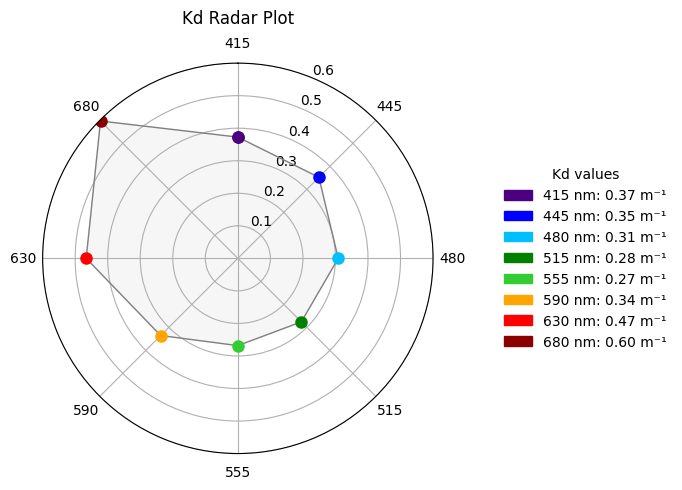

In [10]:
#@title 2.- Radar plot for each Kd (average)
def plot_radar_kd_multi():

  avgKd_415 = wf_all.data.loc[wf_all.data['R2_415'] > r2_value_input, 'KD_415'].mean()
  avgKd_445 = wf_all.data.loc[wf_all.data['R2_445'] > r2_value_input, 'KD_445'].mean()
  avgKd_480 = wf_all.data.loc[wf_all.data['R2_480'] > r2_value_input, 'KD_480'].mean()
  avgKd_515 = wf_all.data.loc[wf_all.data['R2_515'] > r2_value_input, 'KD_515'].mean()
  avgKd_555 = wf_all.data.loc[wf_all.data['R2_555'] > r2_value_input, 'KD_555'].mean()
  avgKd_590 = wf_all.data.loc[wf_all.data['R2_590'] > r2_value_input, 'KD_590'].mean()
  avgKd_630 = wf_all.data.loc[wf_all.data['R2_630'] > r2_value_input, 'KD_630'].mean()
  avgKd_680 = wf_all.data.loc[wf_all.data['R2_680'] > r2_value_input, 'KD_680'].mean()

  labels = ['415', '445', '480', '515', '555', '590', '630', '680']
  values = [avgKd_415, avgKd_445, avgKd_480, avgKd_515, avgKd_555, avgKd_590, avgKd_630, avgKd_680]


  # Define a color for each wavelength (approximate light color)
  colors = ['indigo', 'blue', 'deepskyblue', 'green', 'limegreen', 'orange', 'red', 'darkred']

  # Set up angles and loop closure
  num_vars = len(labels)
  angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
  values += [values[0]]
  angles += [angles[0]]
  colors += [colors[0]]  # Close the color loop

  # Create radar plot
  fig, ax = plt.subplots(figsize=(7, 5), subplot_kw=dict(polar=True))

  # Main plot line and fill
  ax.plot(angles, values, color='gray', linewidth=1)
  ax.fill(angles, values, color='lightgray', alpha=0.2)

  # Add colored scatter points
  for angle, value, color in zip(angles, values, colors):
      ax.plot(angle, value, 'o', color=color, markersize=8)

  # Setup axis
  ax.set_xticks(angles[:-1])
  ax.set_xticklabels(labels)
  ax.set_theta_offset(np.pi / 2)
  ax.set_theta_direction(-1)
  max_value = max(values)
  min_value = min(values)
  radial_limit = math.ceil(max_value * 10) / 10  # Round up to nearest 0.1
  if min_value < 0:
    ax.set_ylim(min_value-0.1, radial_limit)
  else:
    ax.set_ylim(0, radial_limit)
  # ax.set_ylim(0, 0.6)

  # Create legend handles with wavelength and Kd values
  legend_handles = [
    mpatches.Patch(color=color, label=f'{label} nm: {value:.2f} m⁻¹')
    for label, value, color in zip(labels, values[:-1], colors[:-1])  # exclude closing element
  ]

  # Add vertical legend
  ax.legend(
      handles=legend_handles,
      loc='center left',
      bbox_to_anchor=(1.15, 0.5),
      ncol=1,
      frameon=False,
      title='Kd values'
)

  # Title
  ax.set_title("Kd Radar Plot", y=1.08)

  plt.tight_layout()

  # Save the plot before showing it
  plt.savefig(f"results/radar_plot_{datetime_start_name}.png", dpi=300, bbox_inches='tight')

  plt.show()


def plot_radar_kd():
  #to do
  avgKd_clear = wf_all.data.loc[wf_all.data['R2_CLEAR'] > r2_value_input, 'KD_CLEAR'].mean()
  labels = ['PAR']
  values = [avgKd_clear]
  avgKd_blue = wf_all.data.loc[wf_all.data['R2_BLUE'] > r2_value_input, 'KD_BLUE'].mean()
  labels.append('Blue')
  values.append(avgKd_blue)
  avgKd_green = wf_all.data.loc[wf_all.data['R2_GREEN'] > r2_value_input, 'KD_GREEN'].mean()
  labels.append('Green')
  values.append(avgKd_green)
  avgKd_red = wf_all.data.loc[wf_all.data['R2_RED'] > r2_value_input, 'KD_RED'].mean()
  labels.append('Red')
  values.append(avgKd_red)



if kduino == 'KduPRO':
  plot_radar_kd()
elif kduino == 'KduPRO-Multi':
  plot_radar_kd_multi()

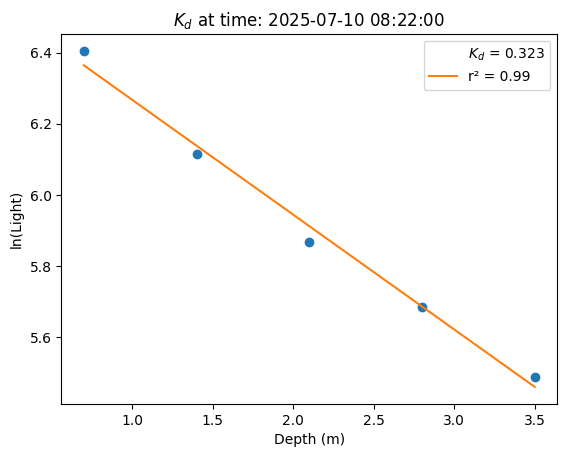

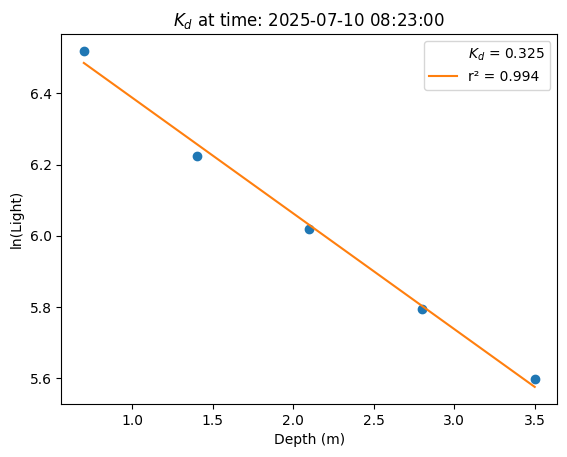

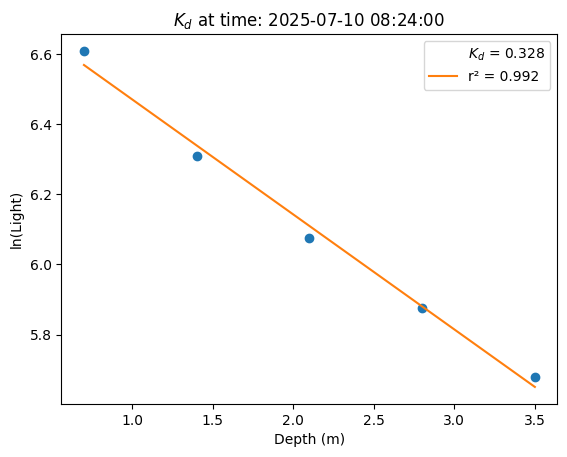

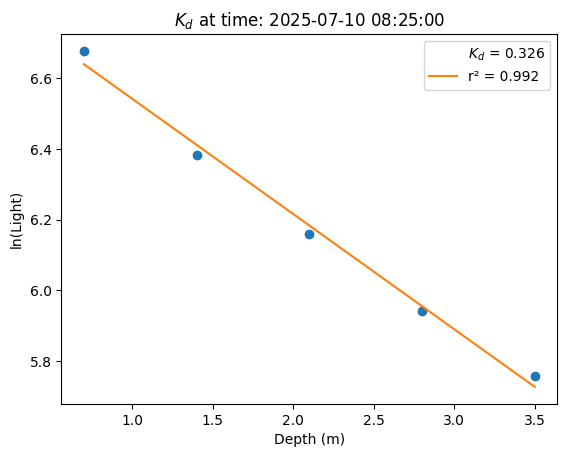

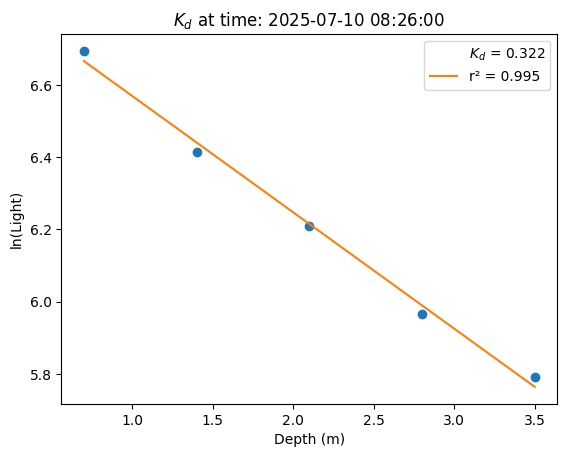

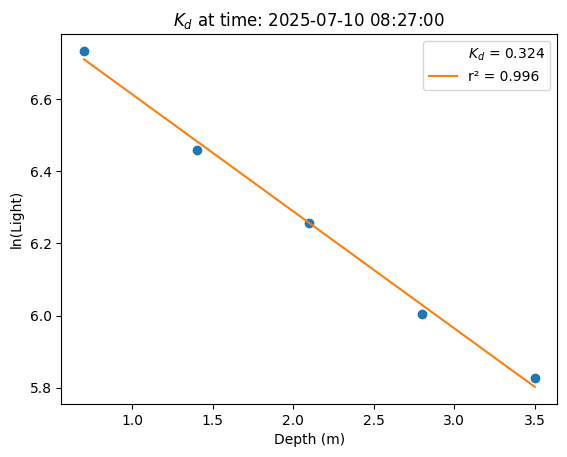

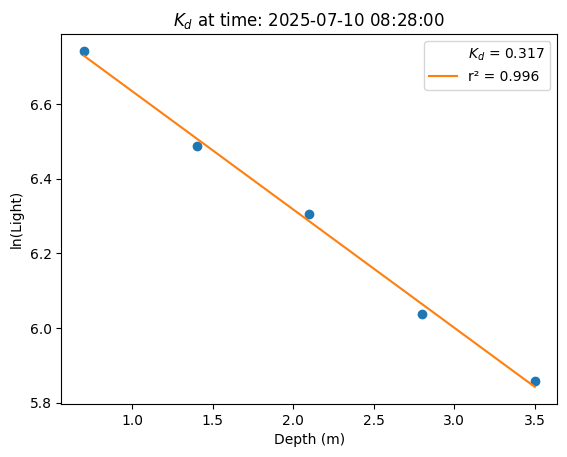

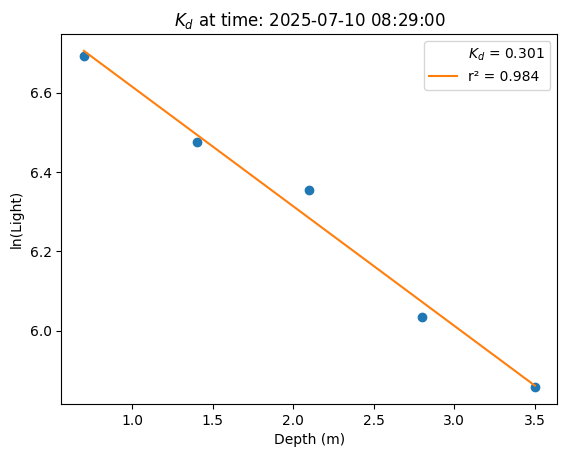

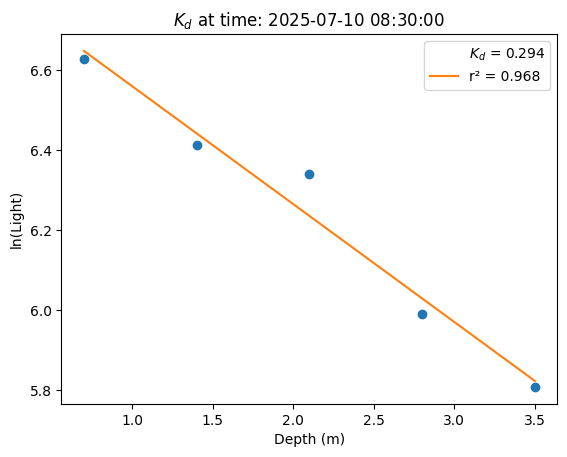

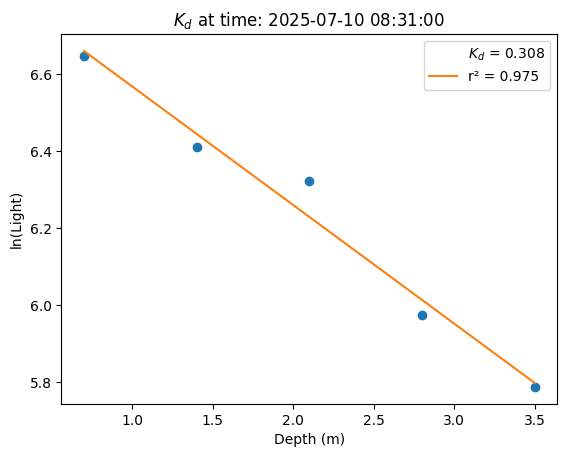

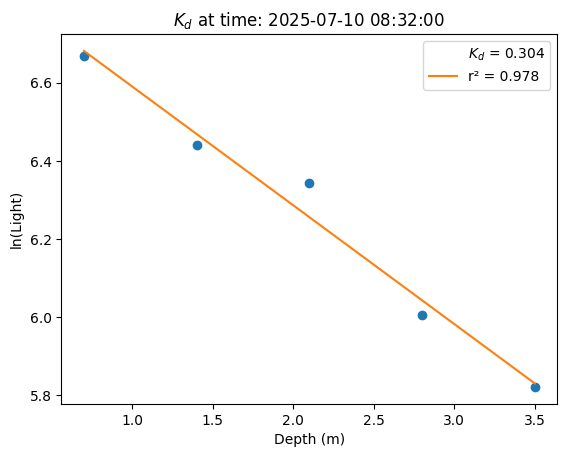

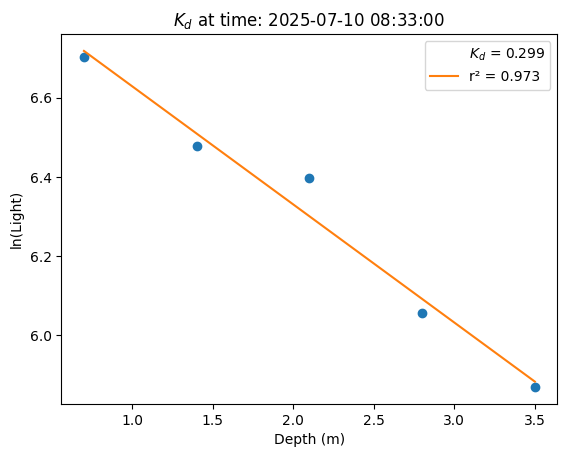

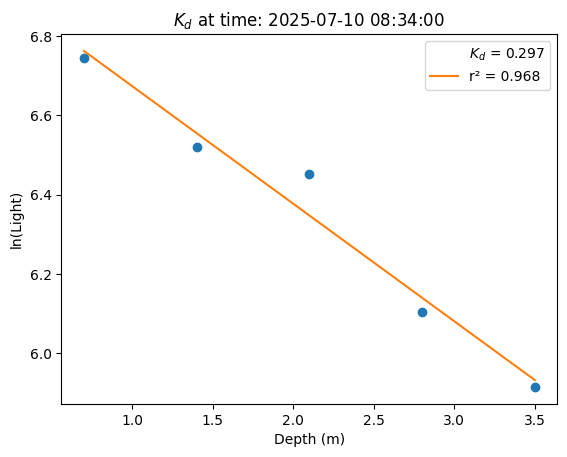

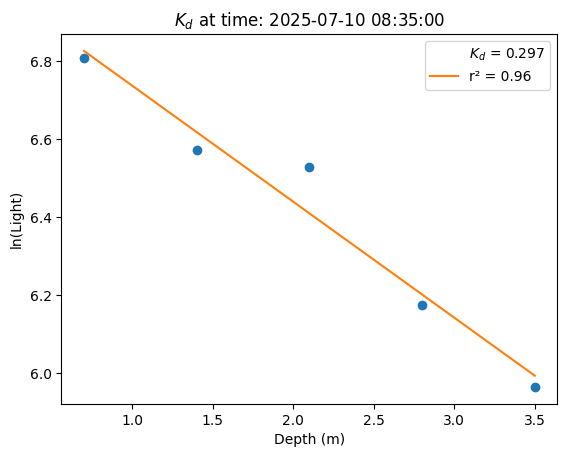

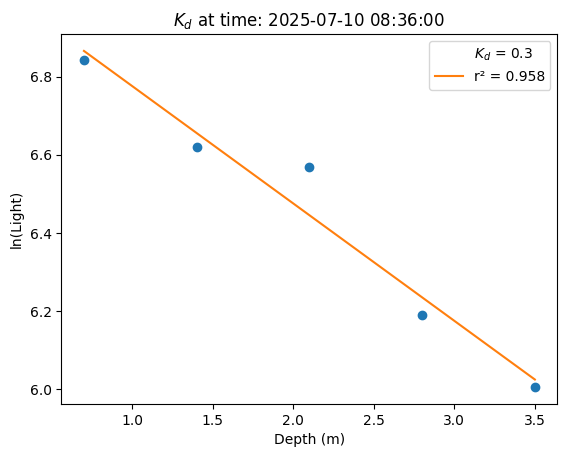

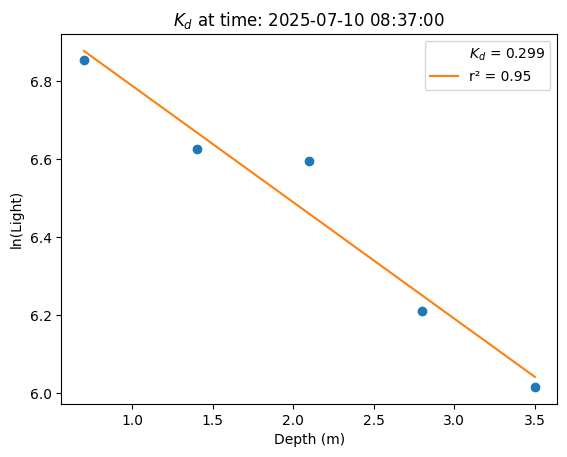

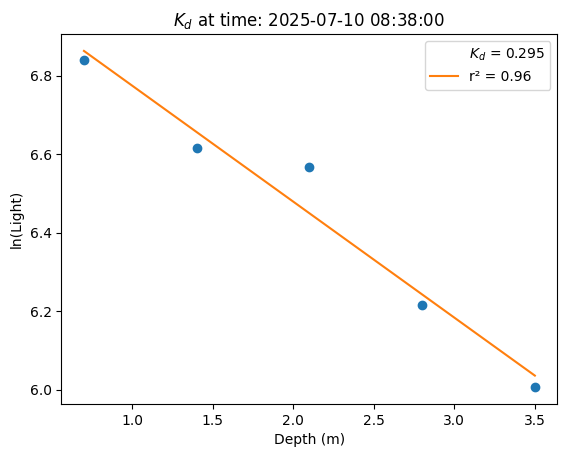

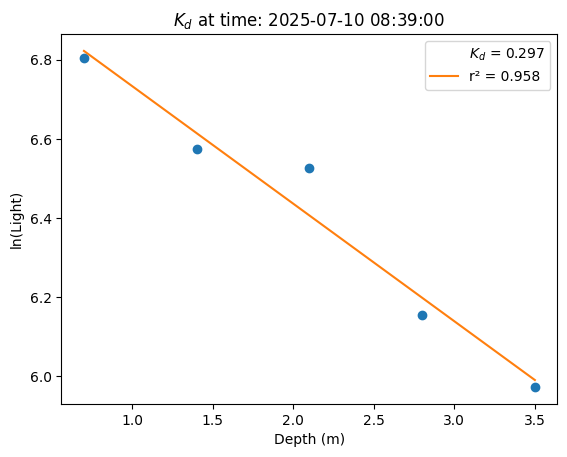

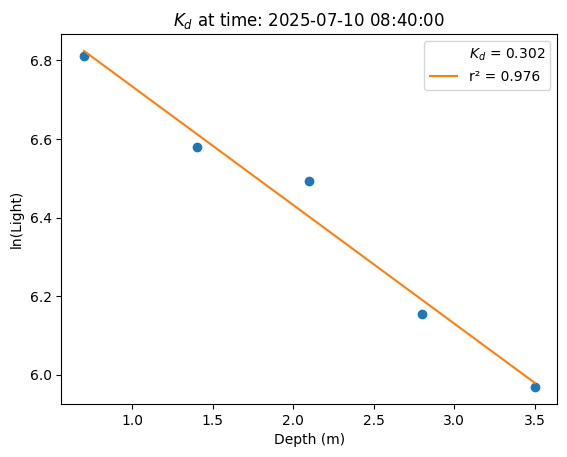

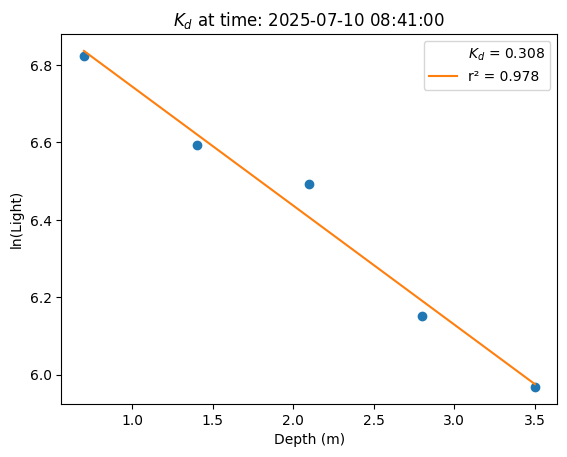

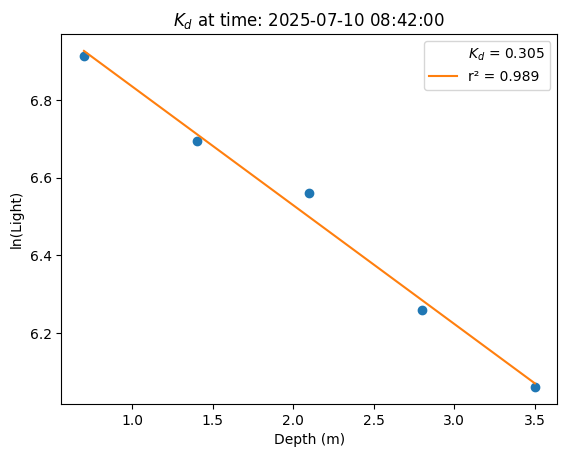

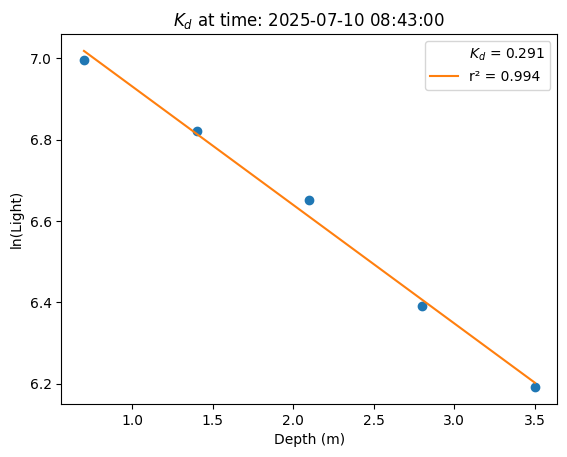

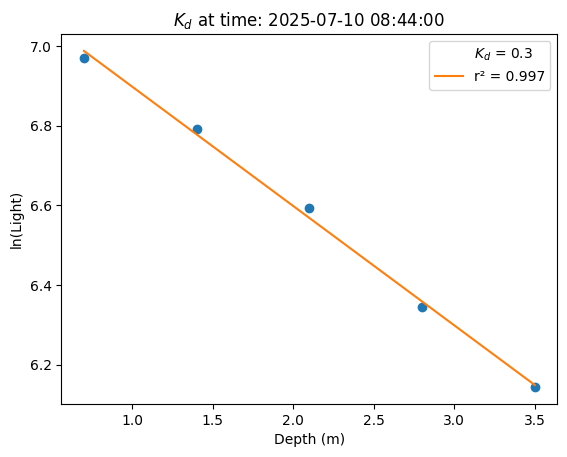

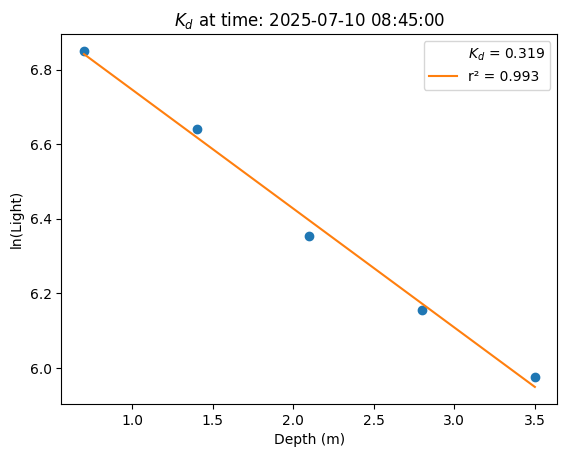

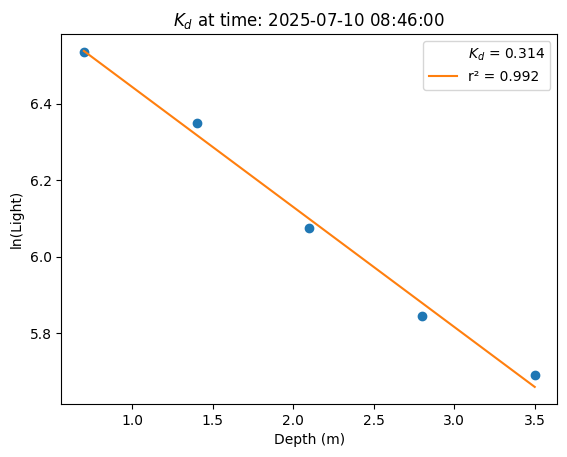

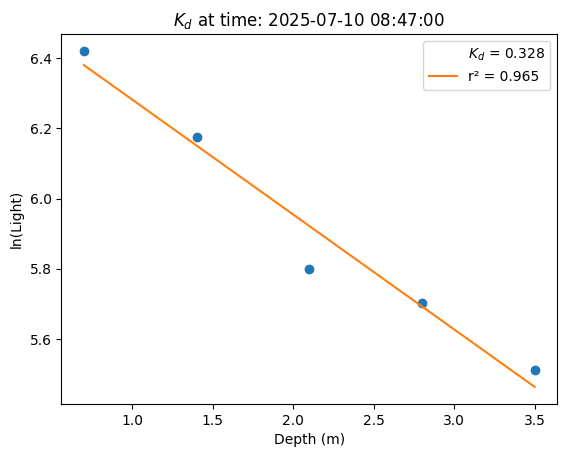

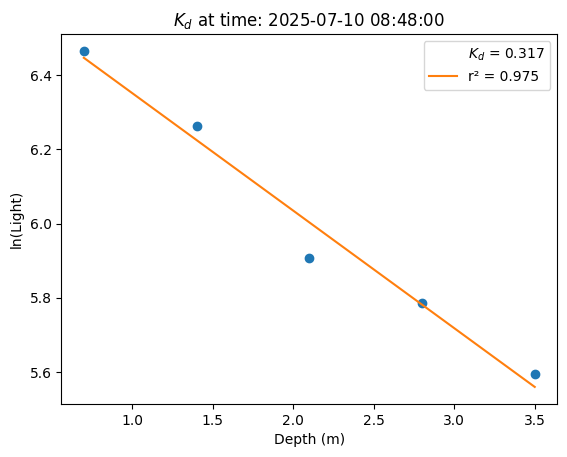

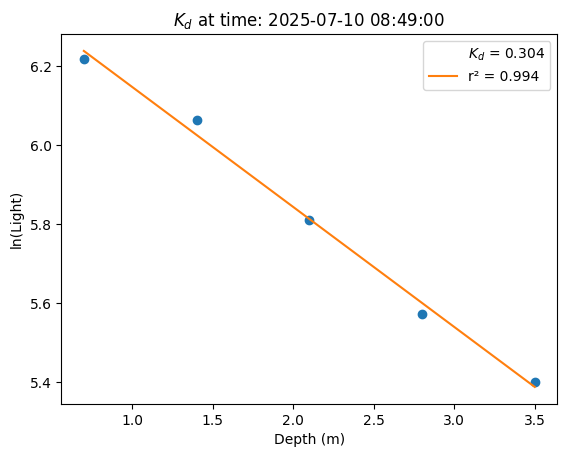

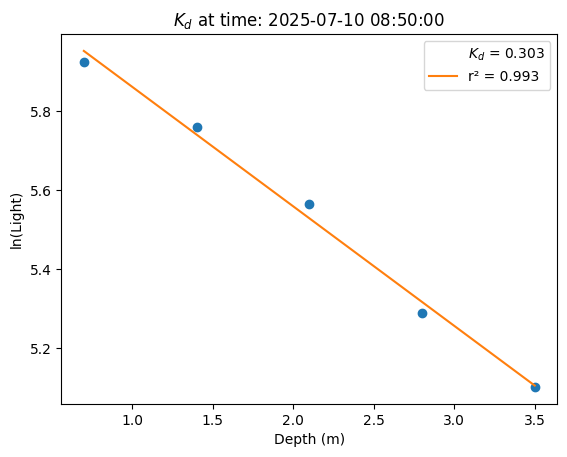

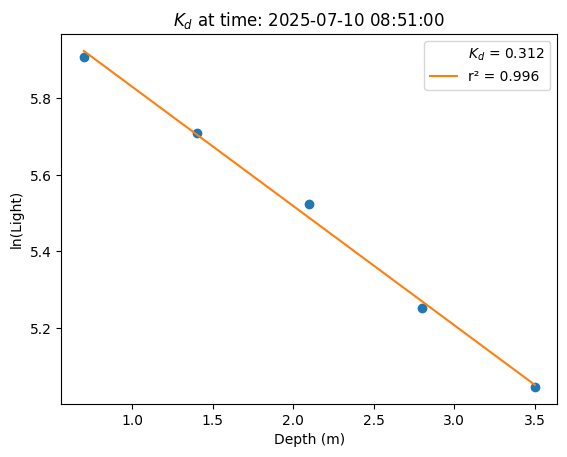

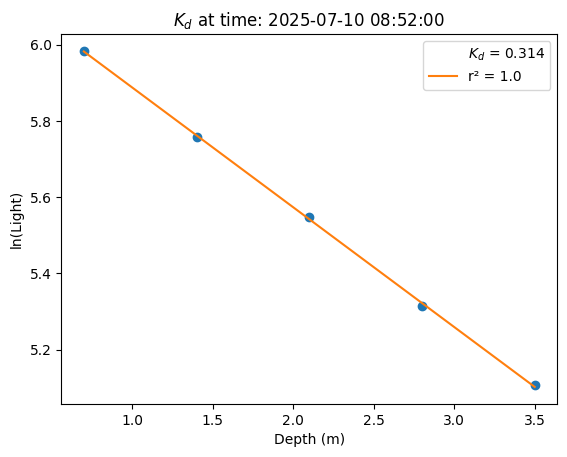

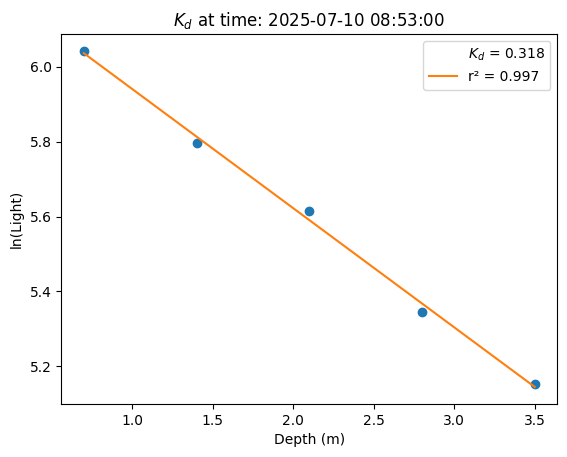

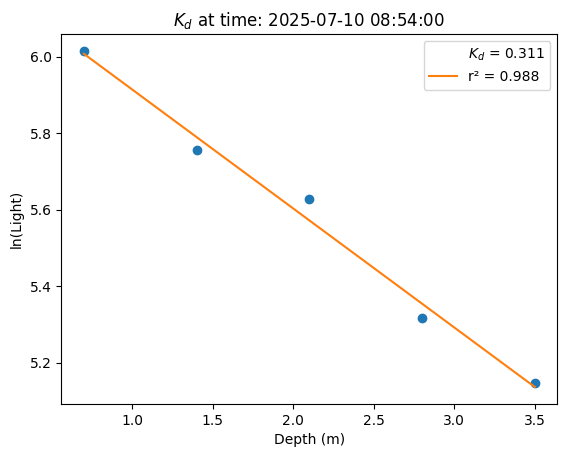

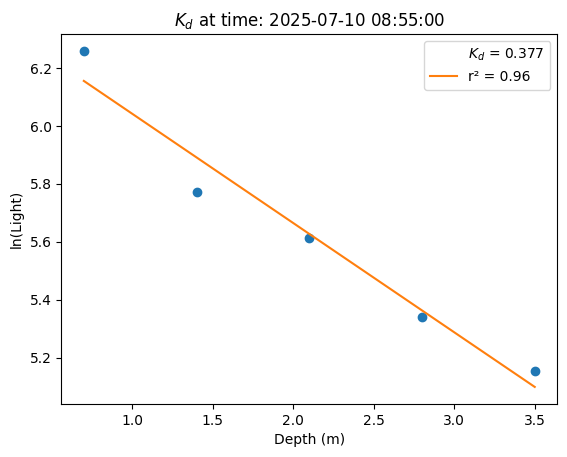

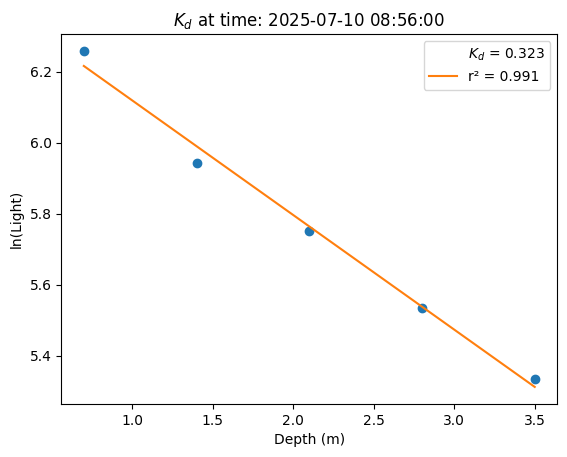

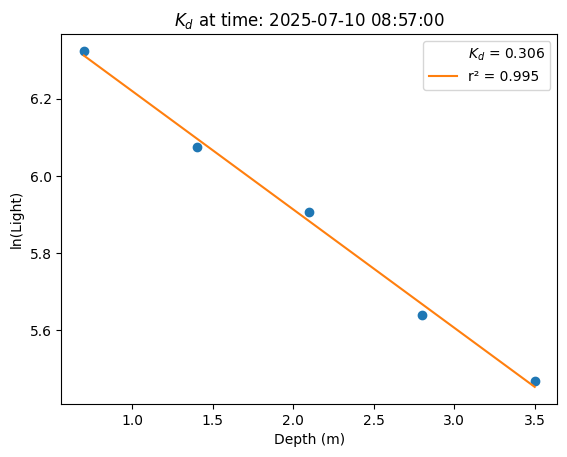

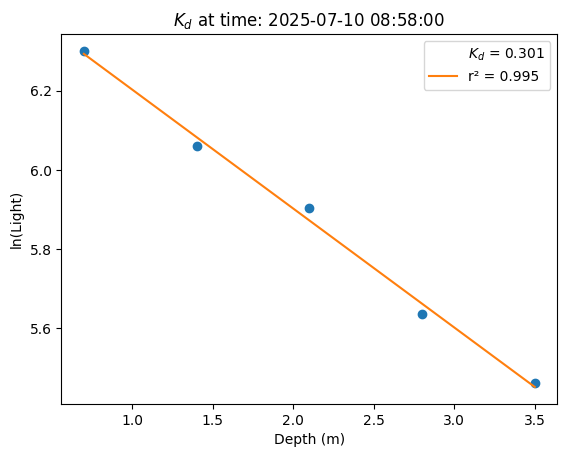

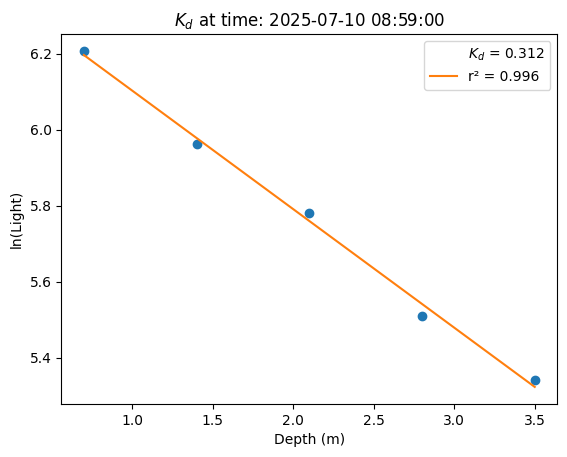

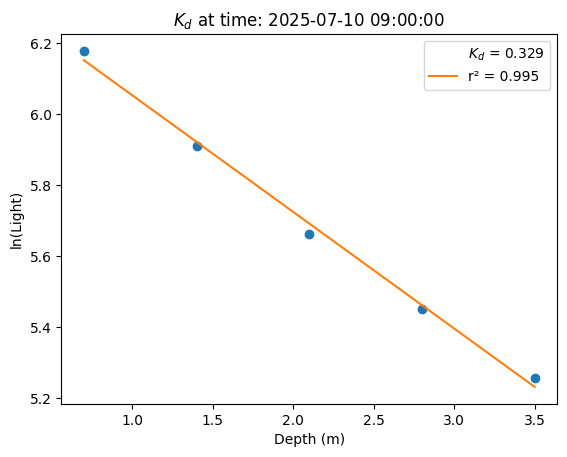

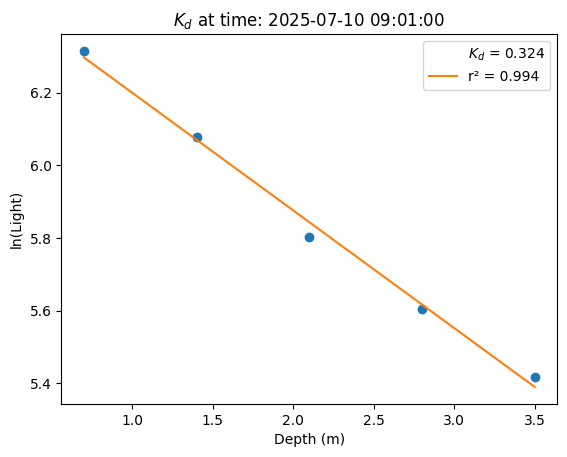

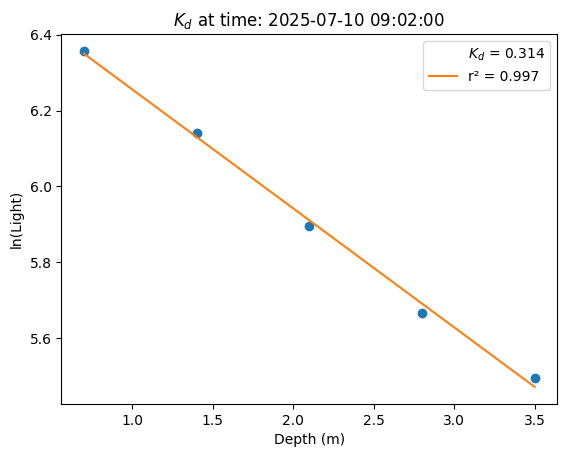

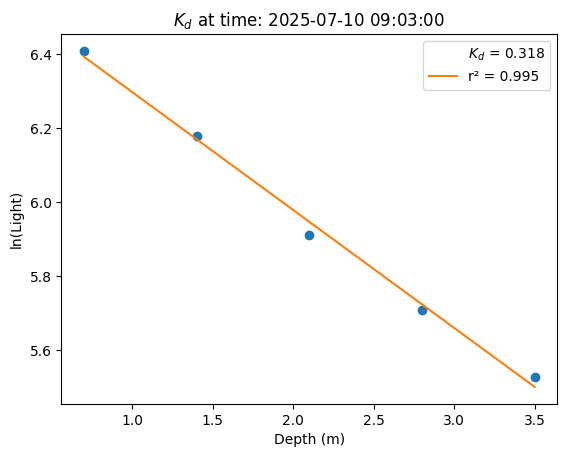

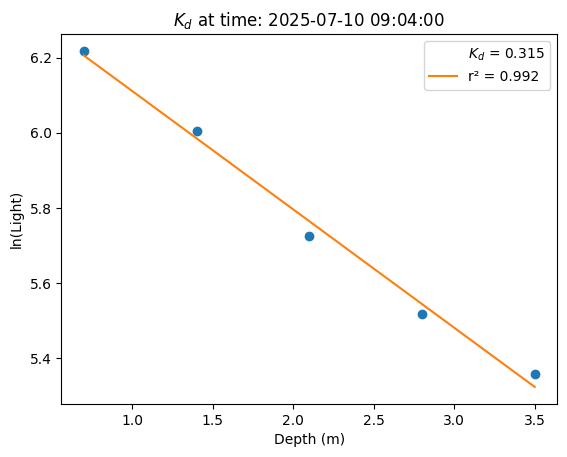

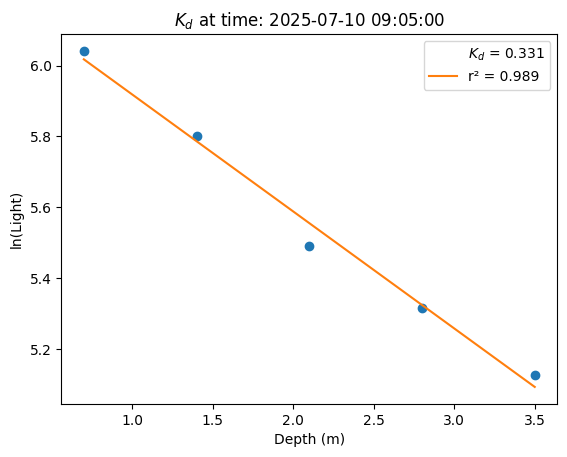

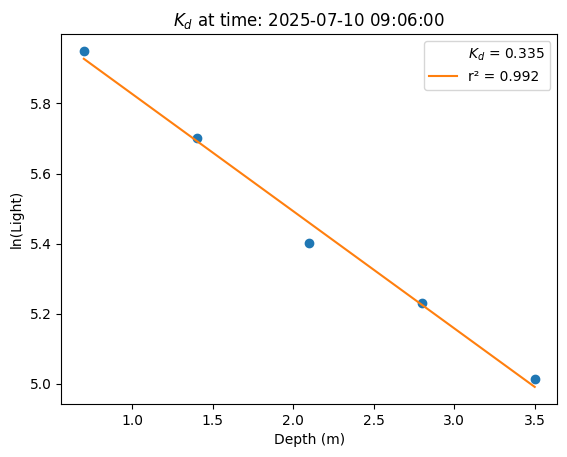

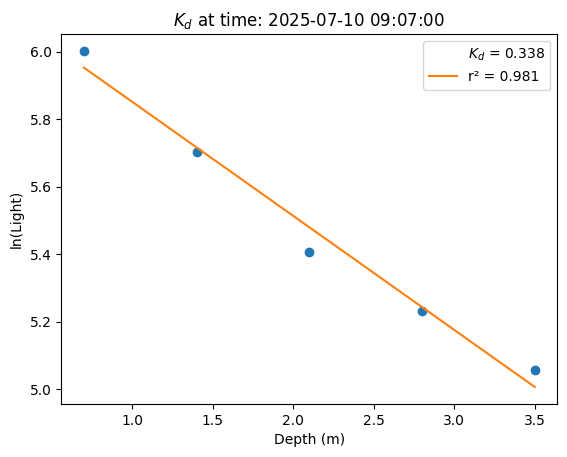

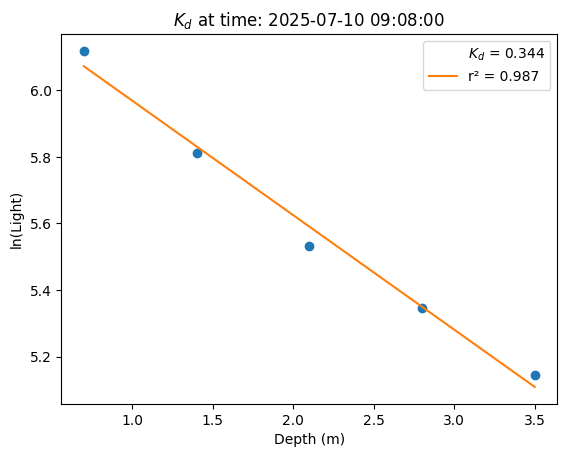

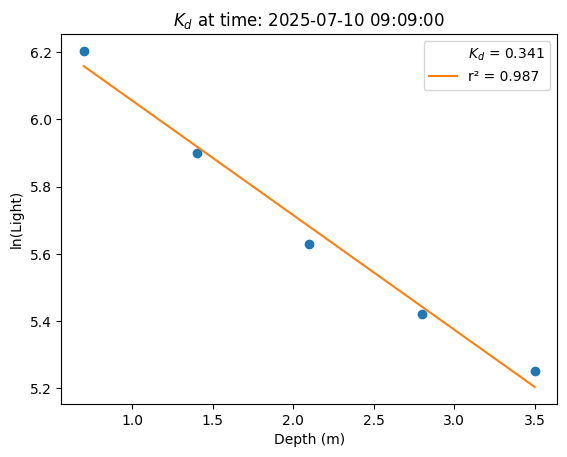

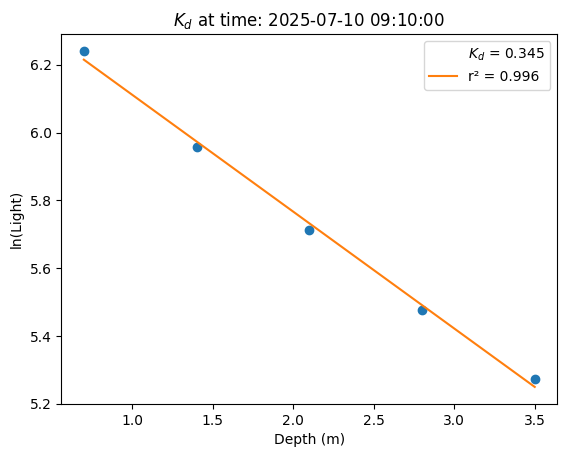

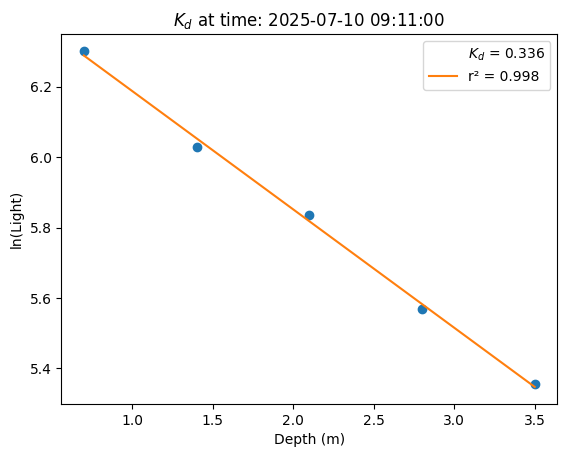

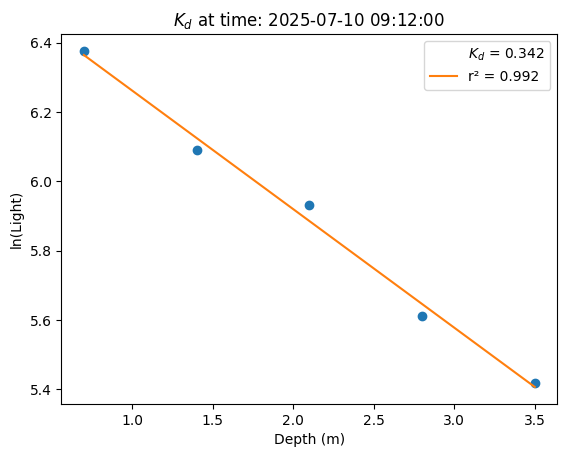

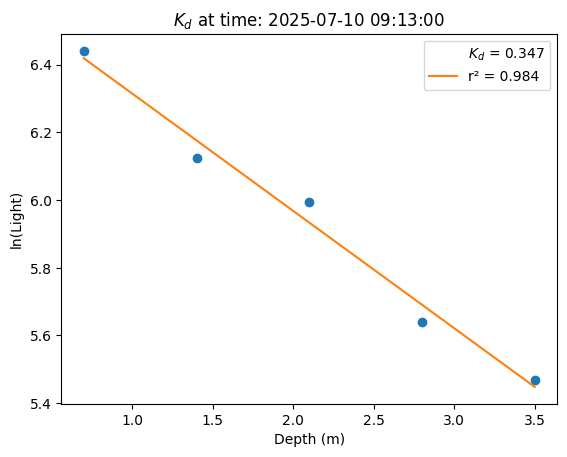

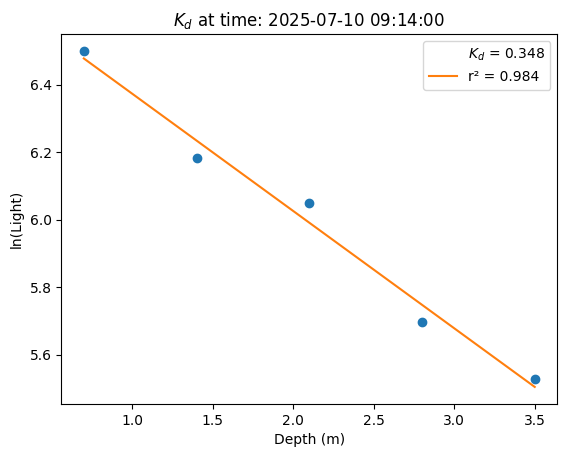

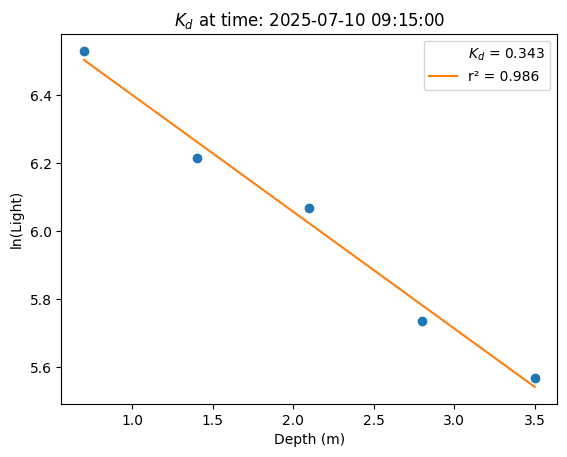

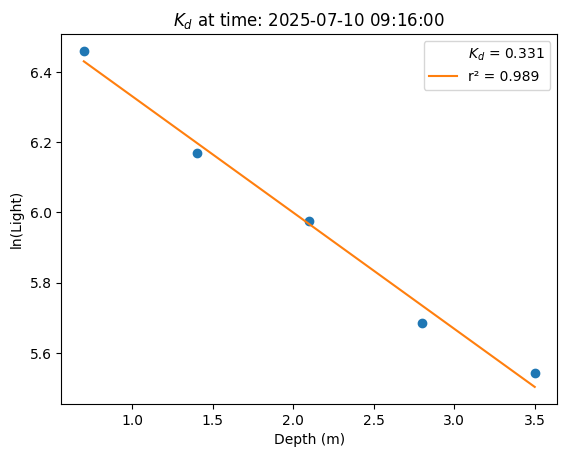

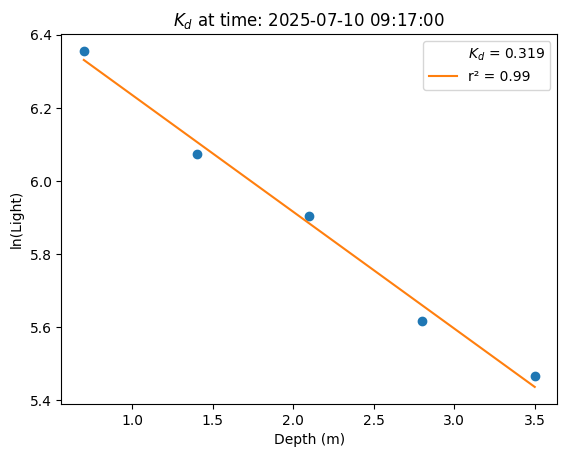

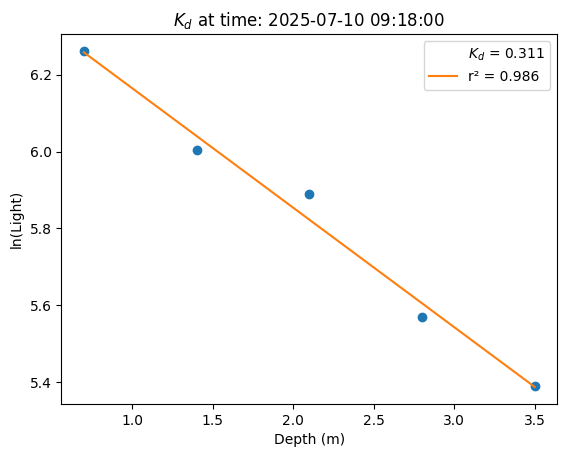

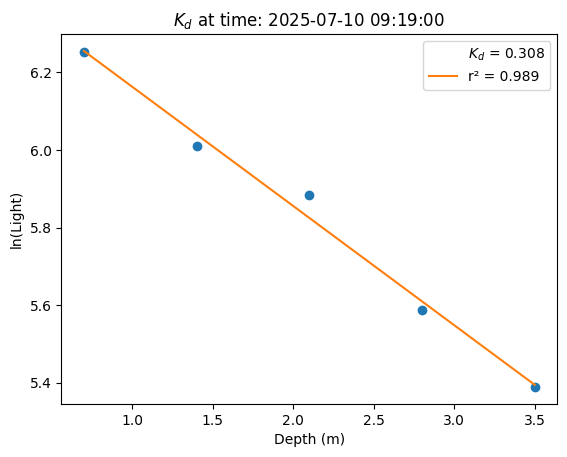

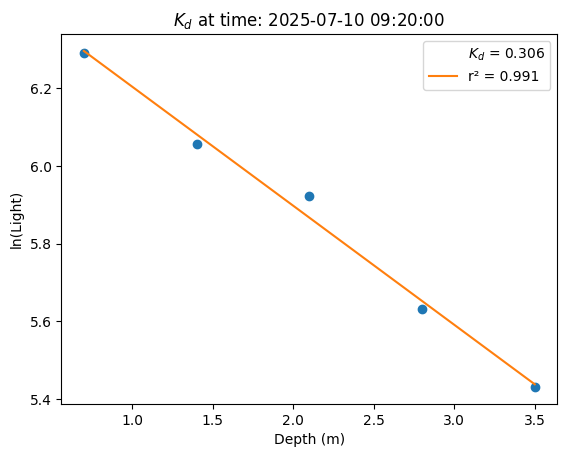

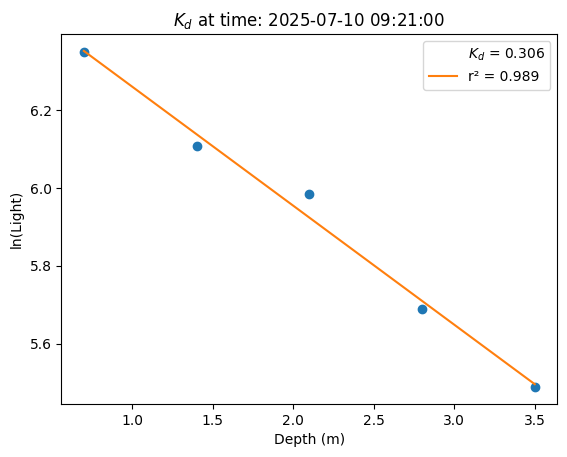

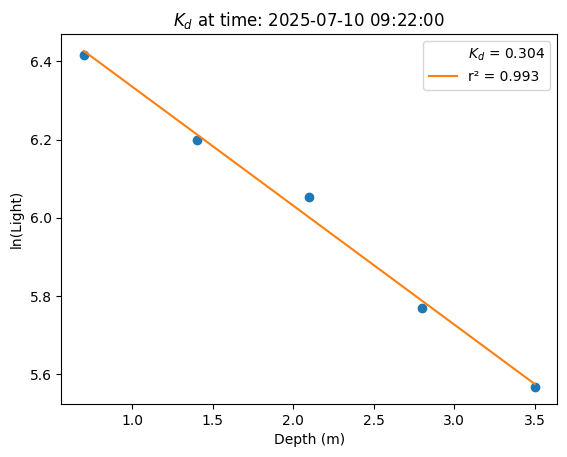

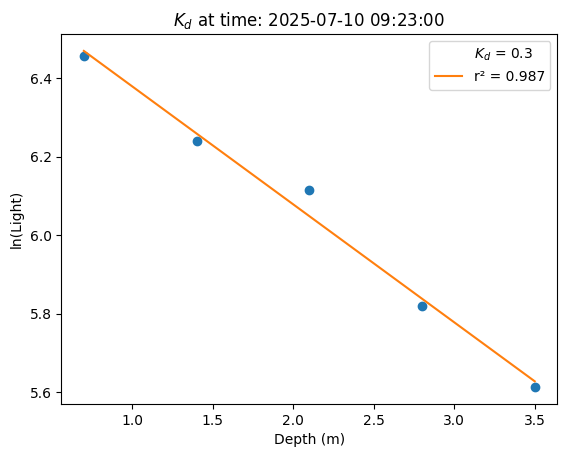

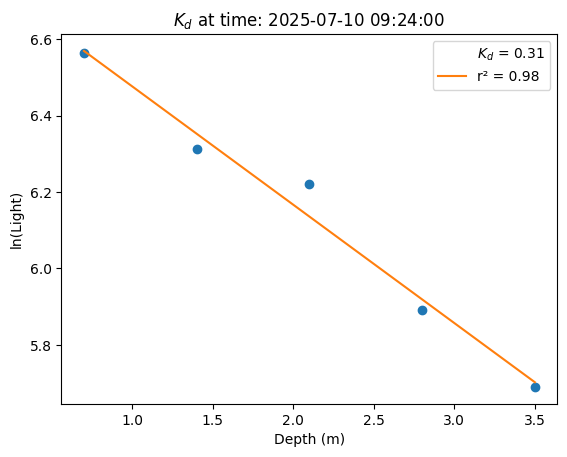

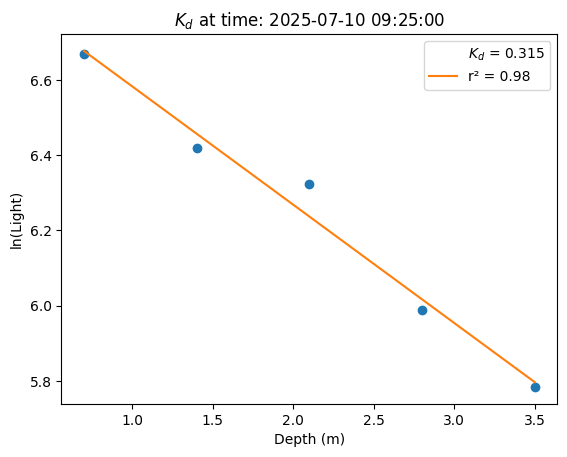

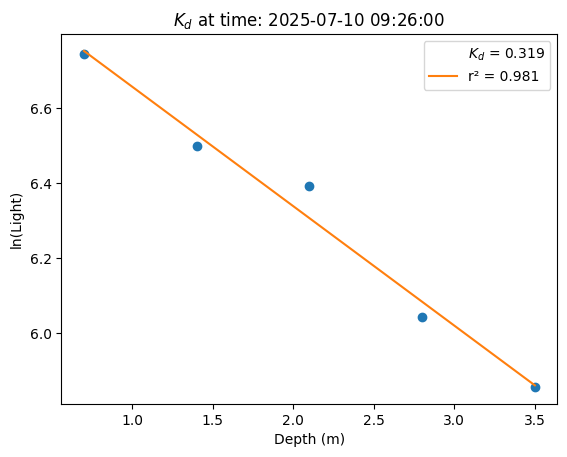

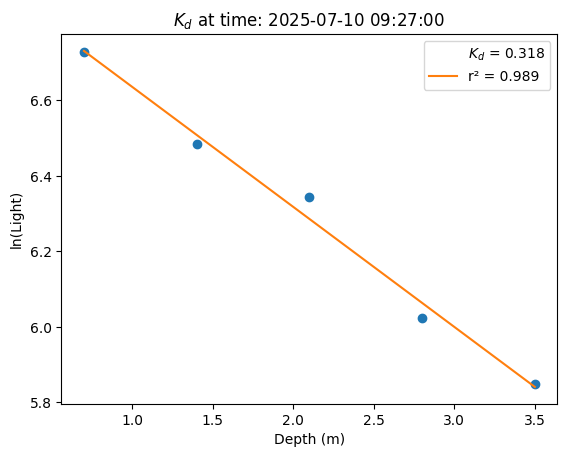

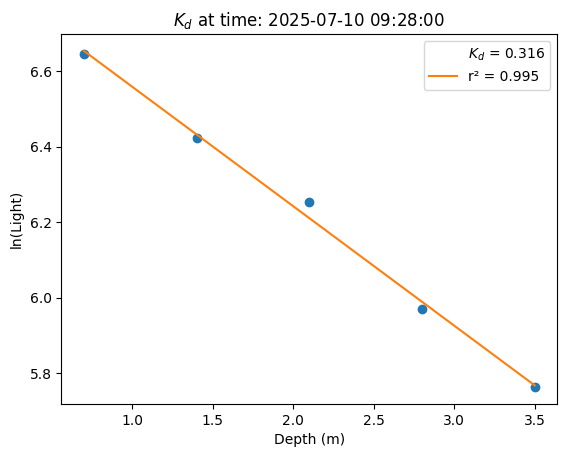

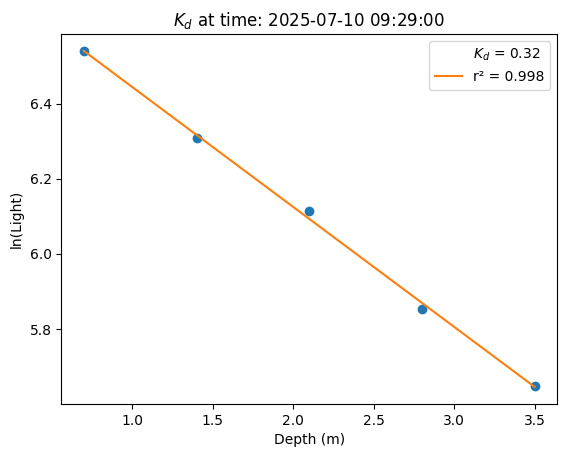

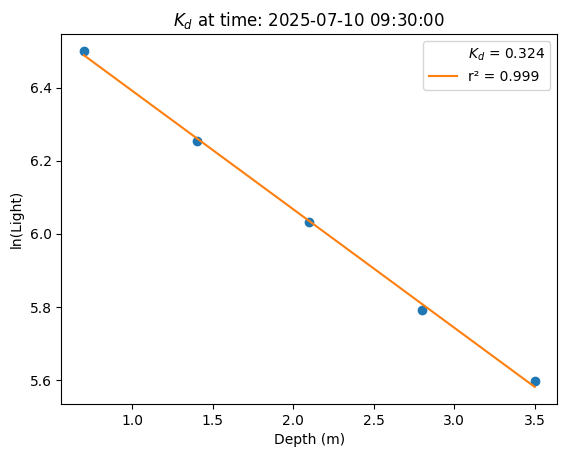

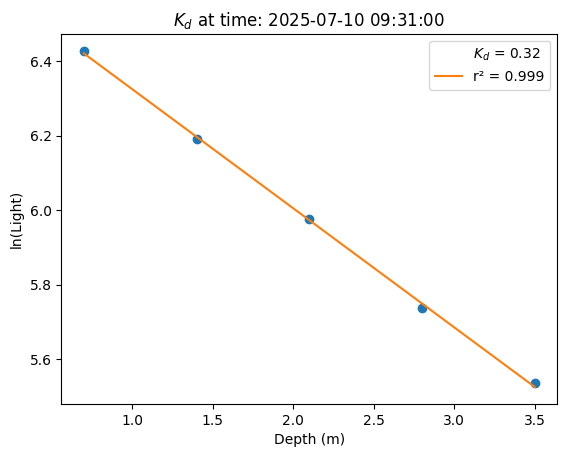

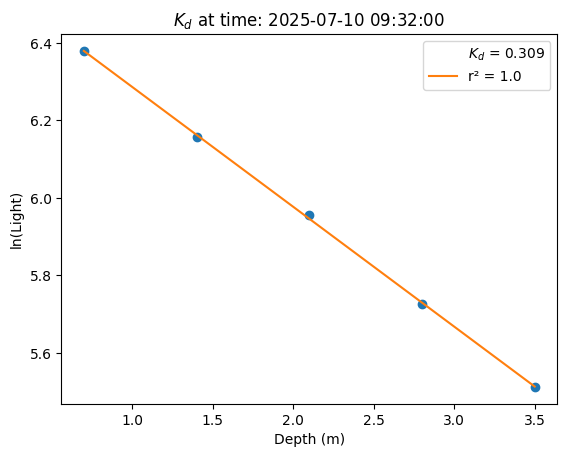

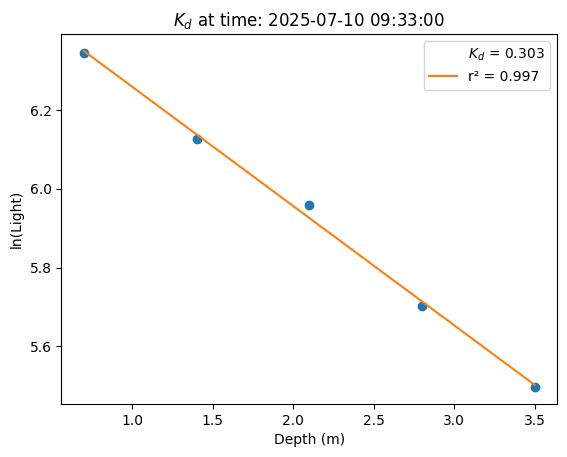

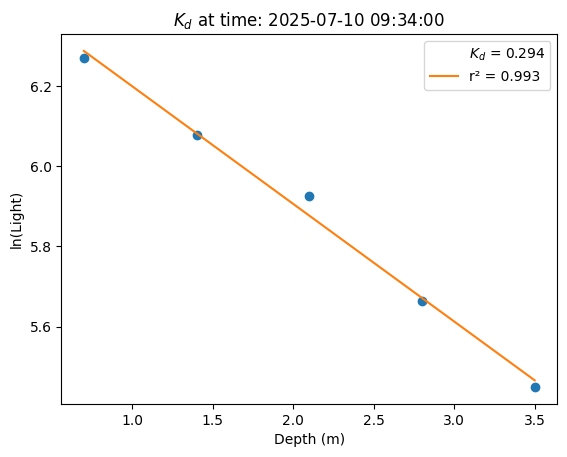

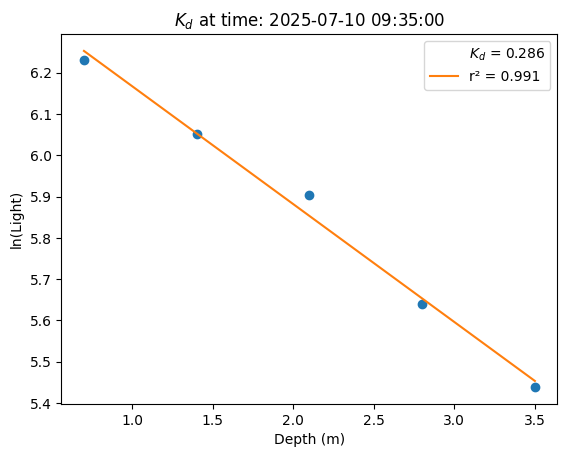

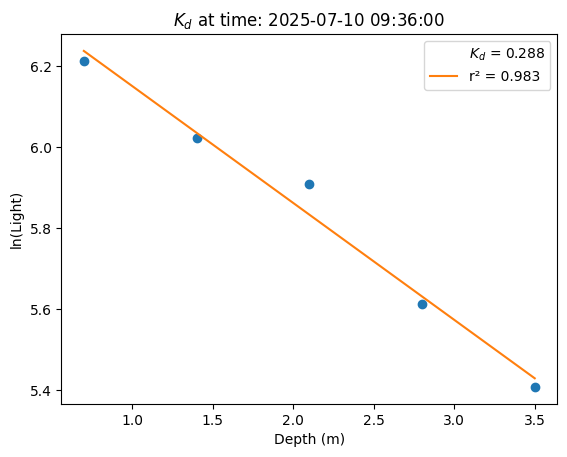

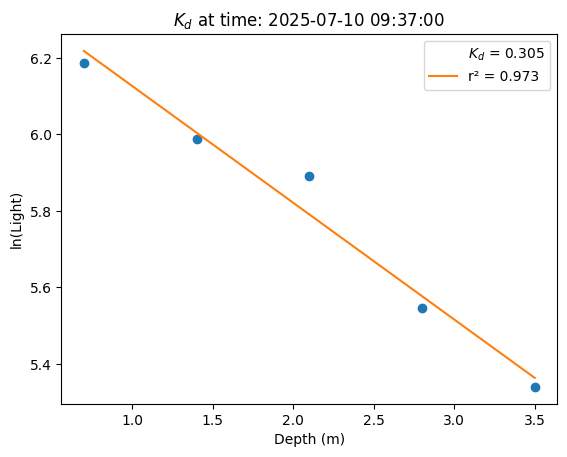

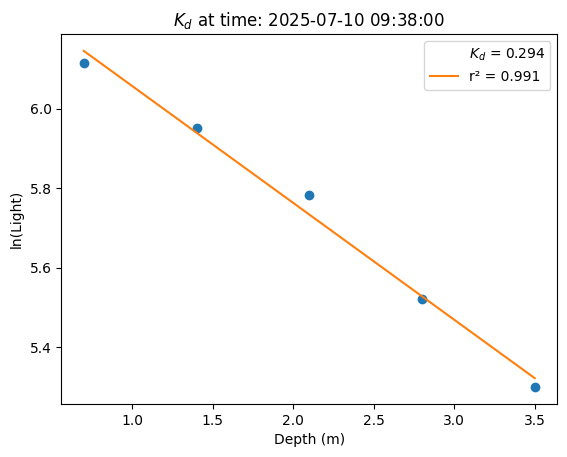

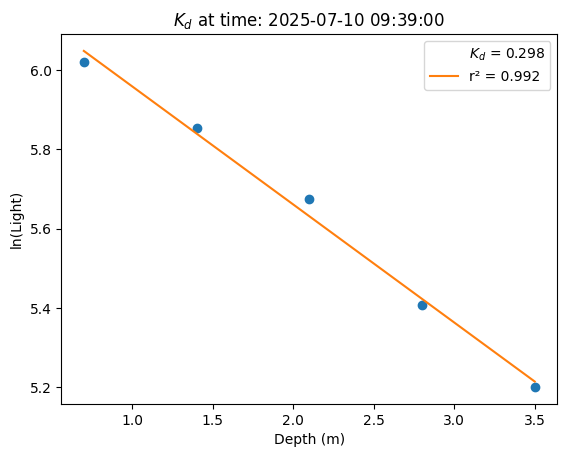

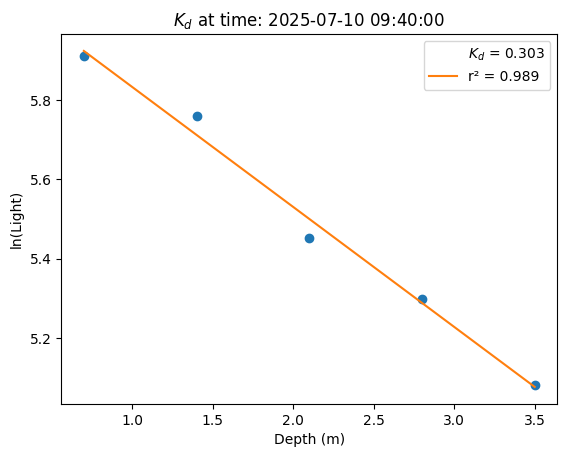

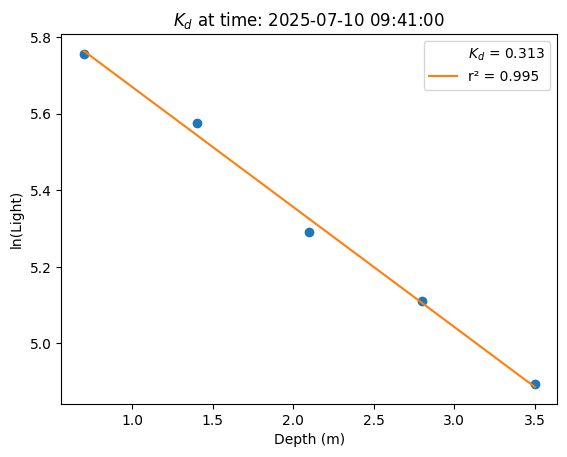

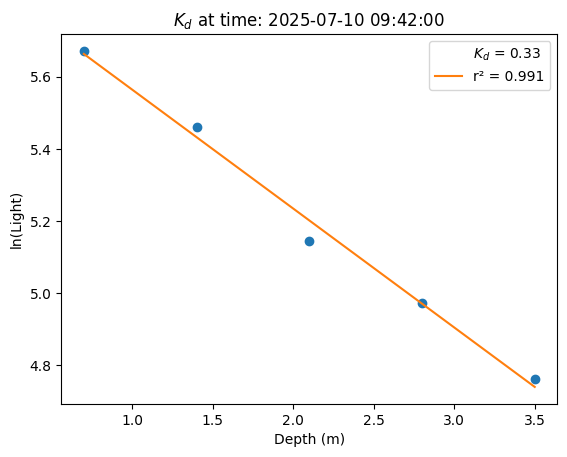

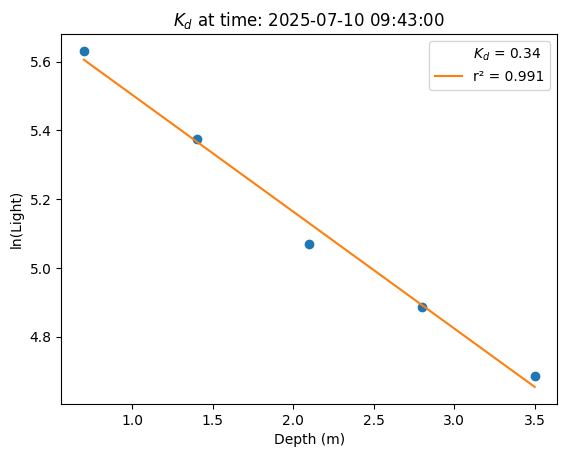

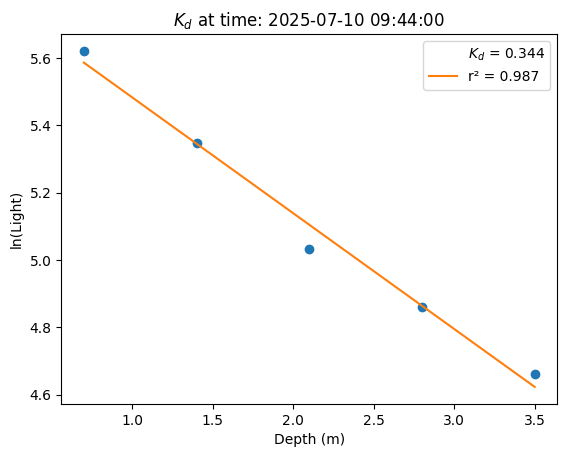

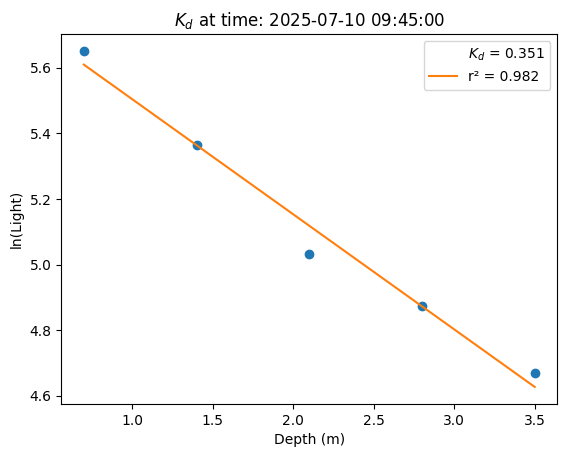

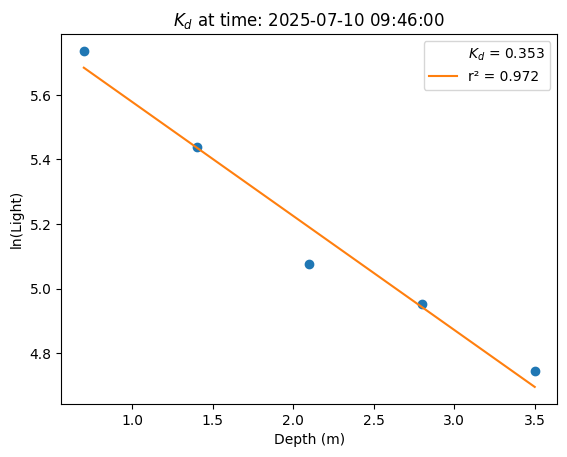

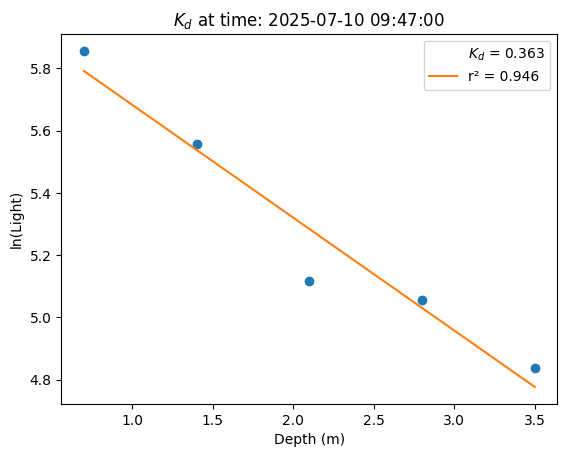

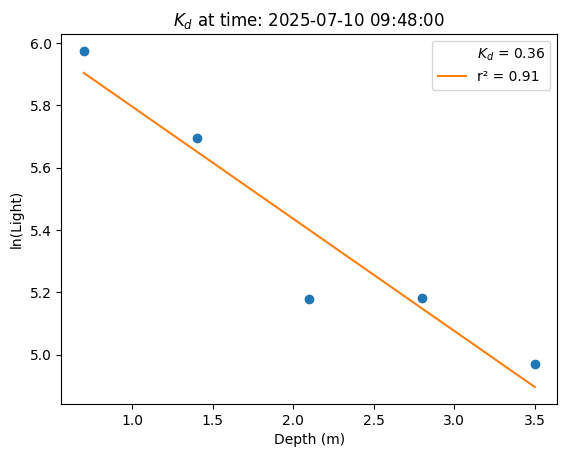

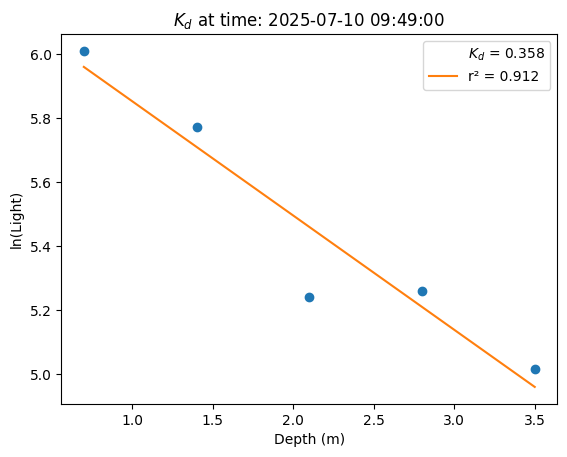

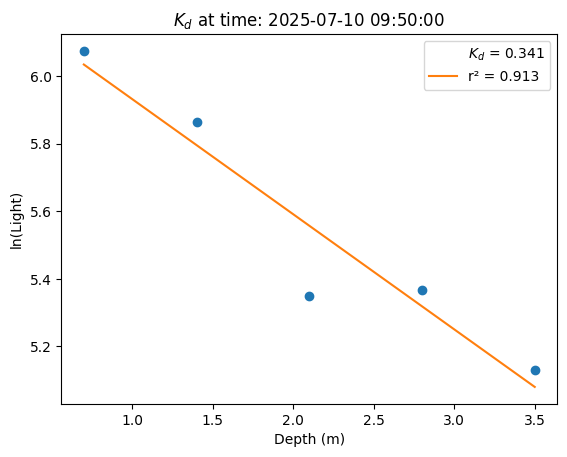

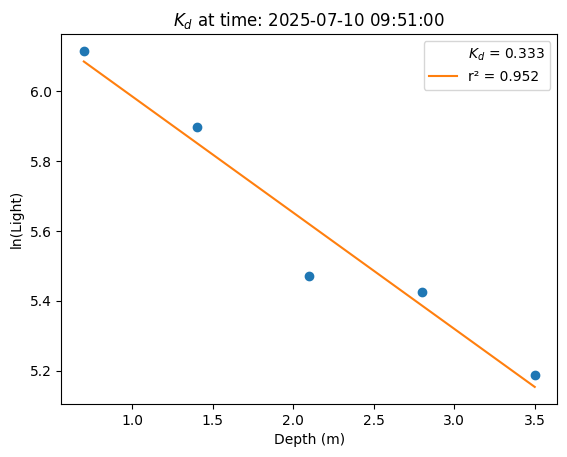

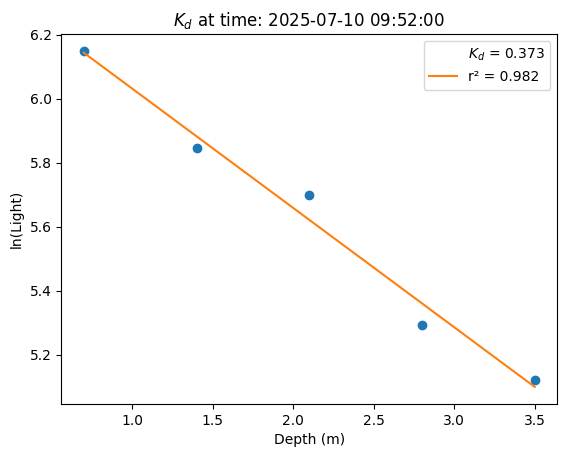

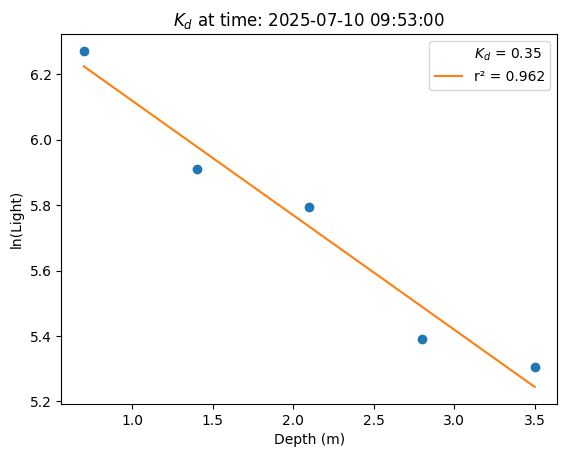

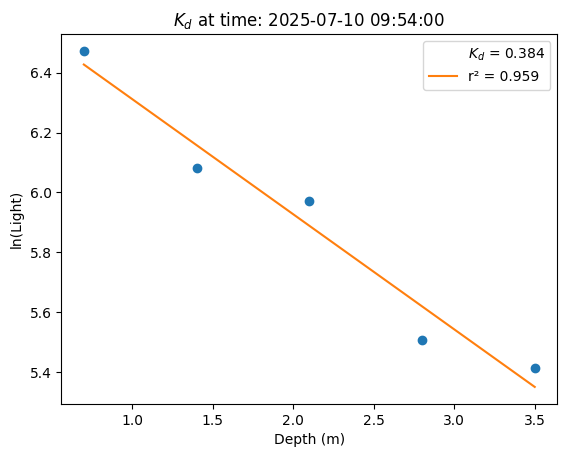

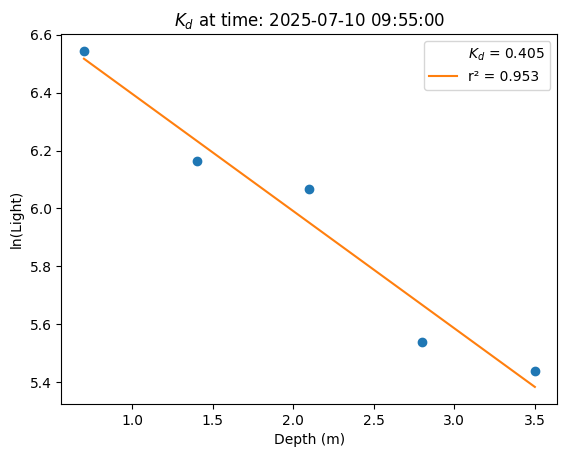

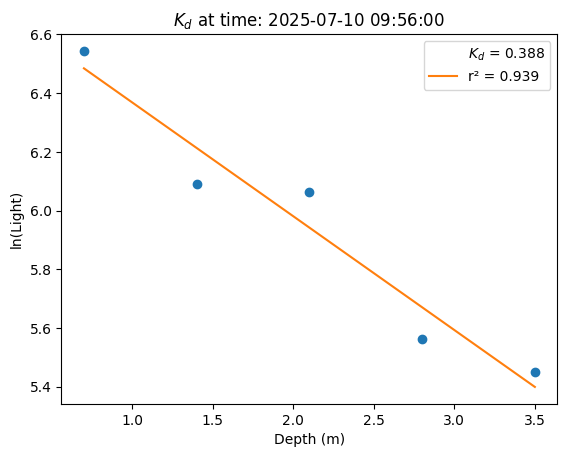

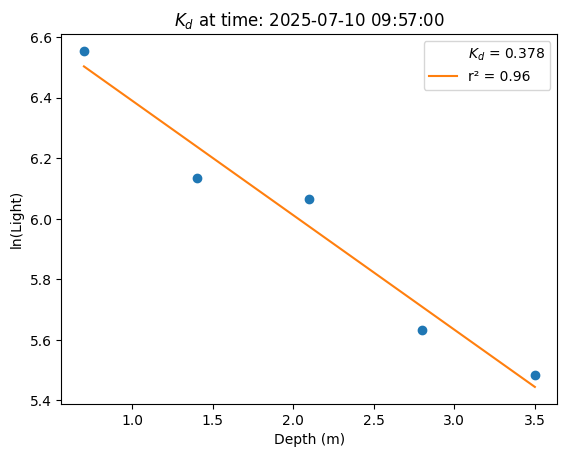

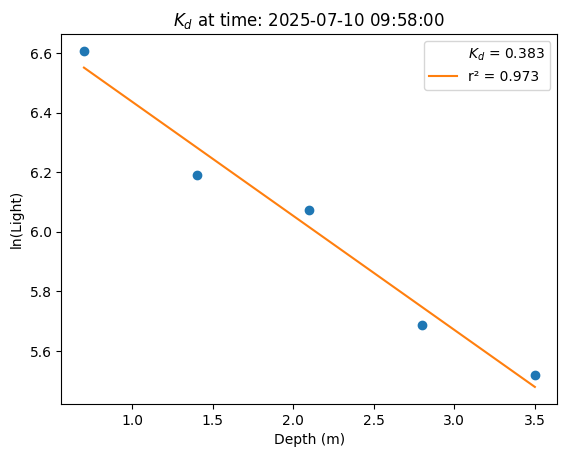

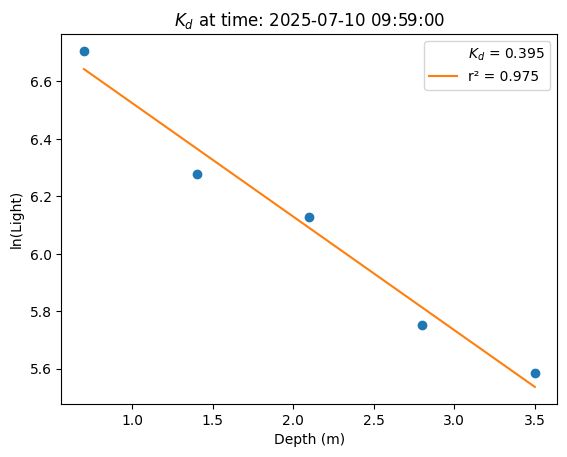

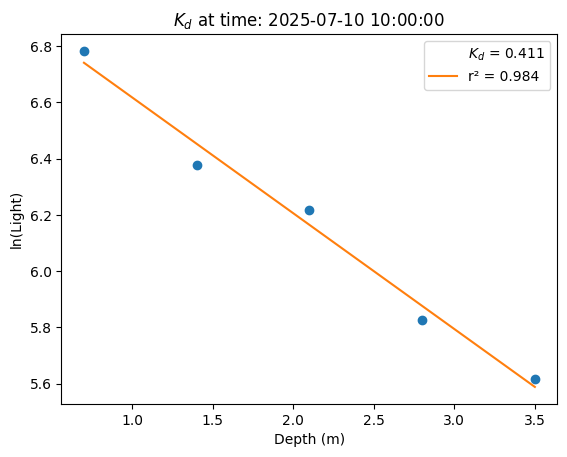

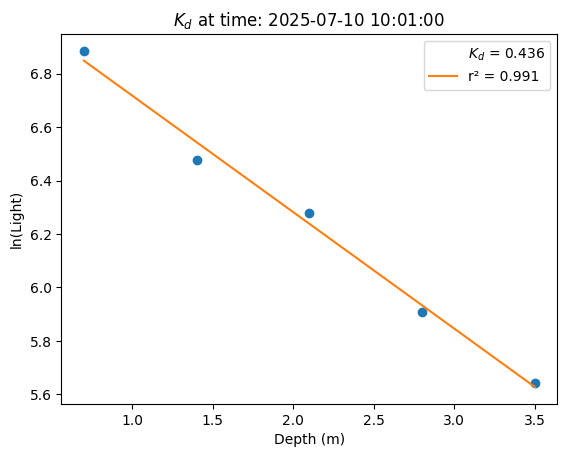

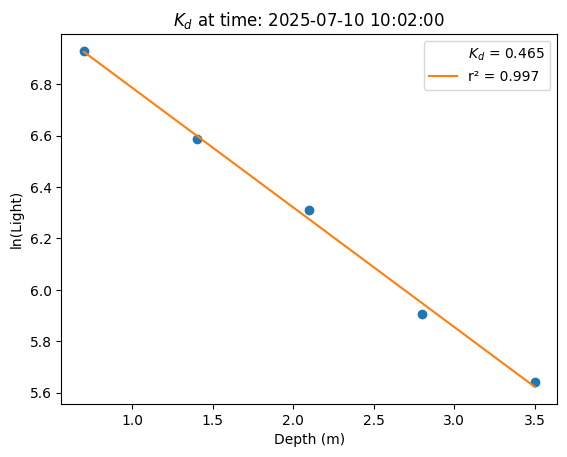

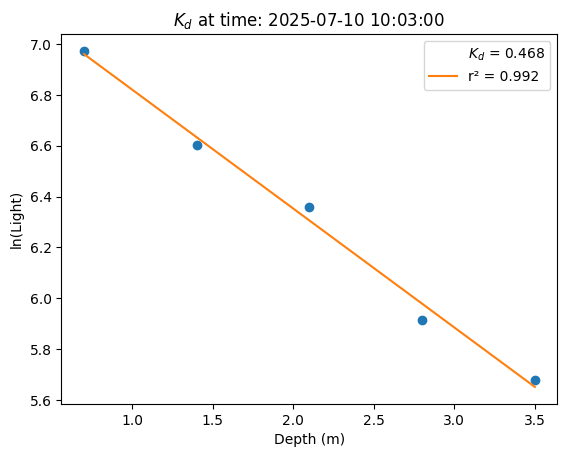

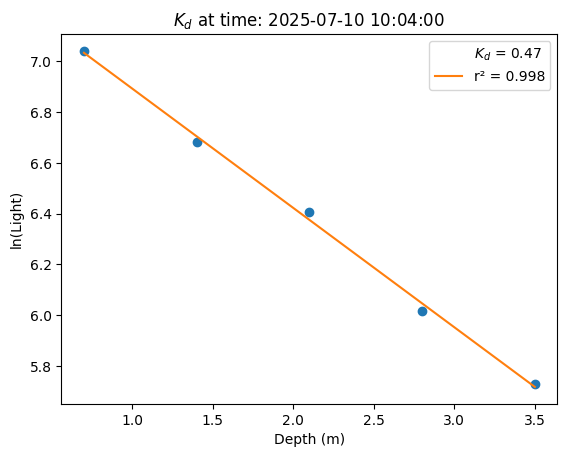

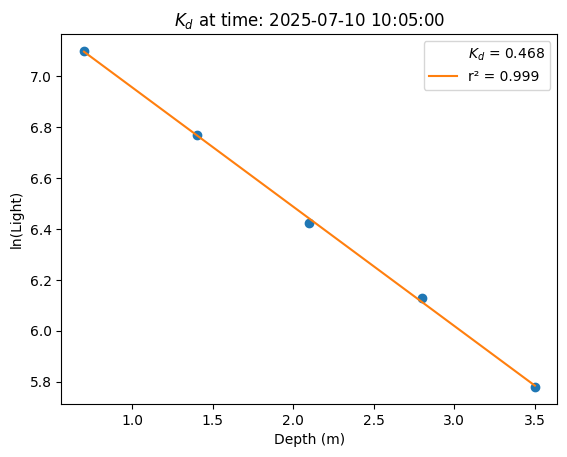

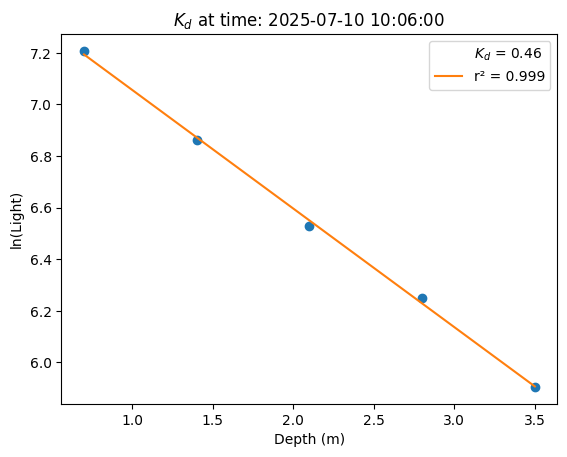

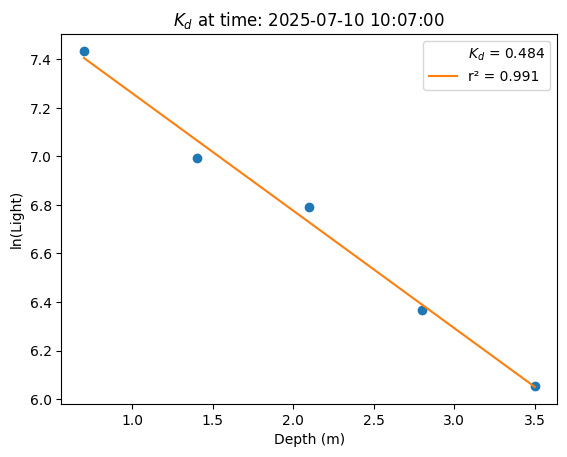

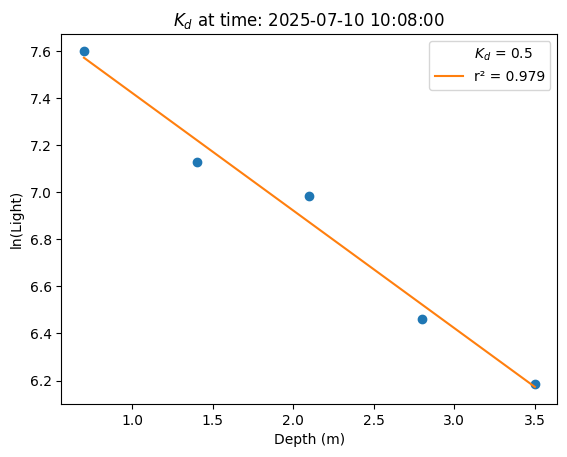

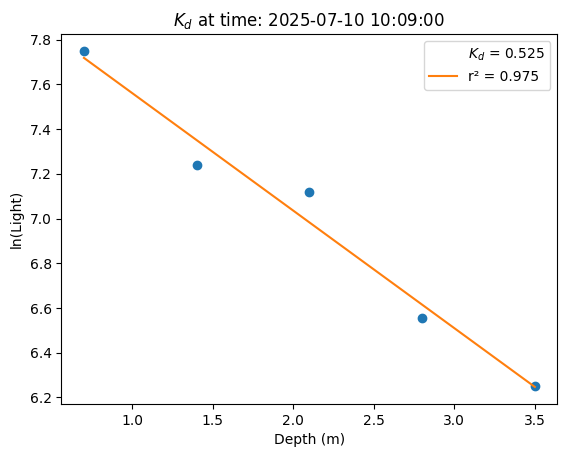

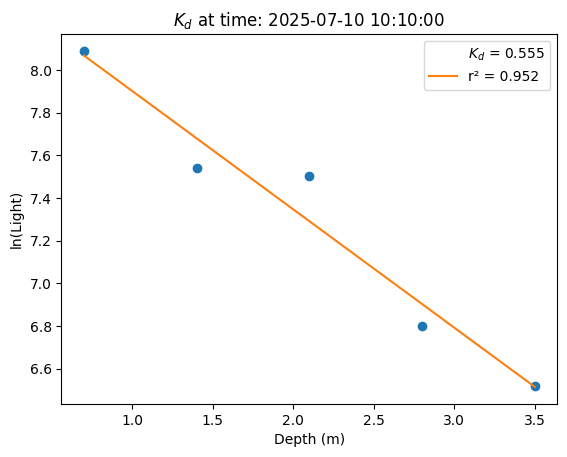

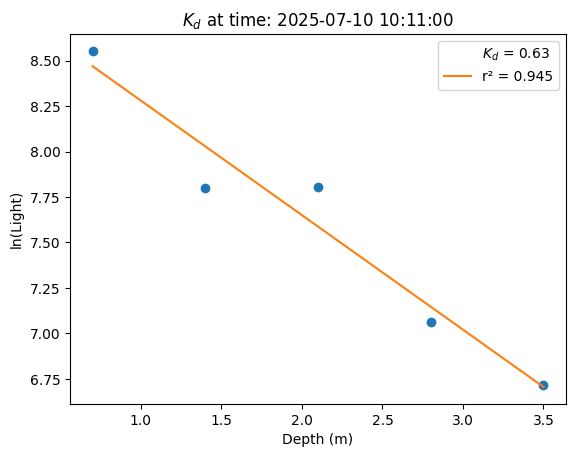

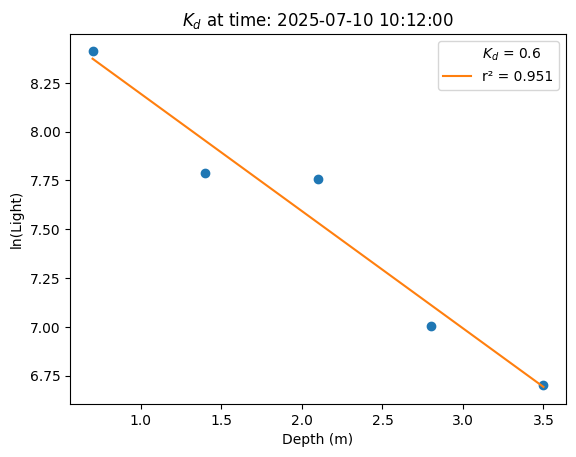

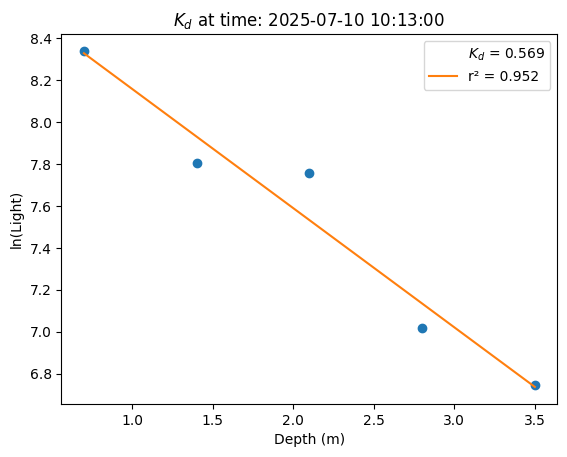

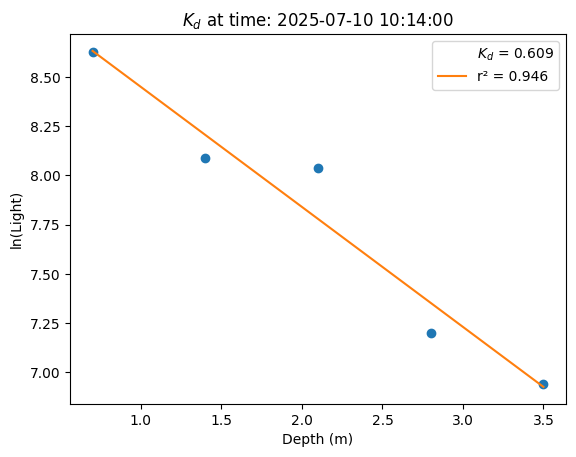

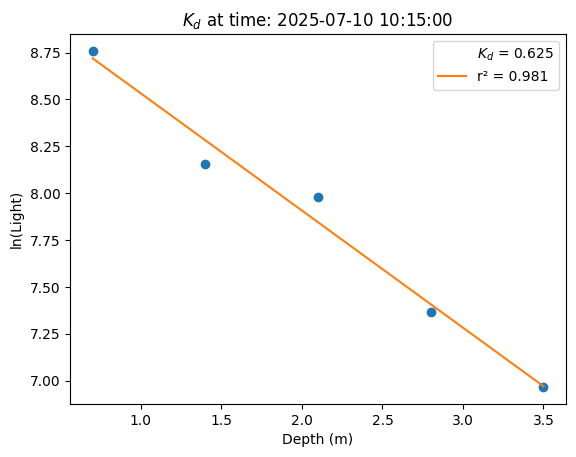

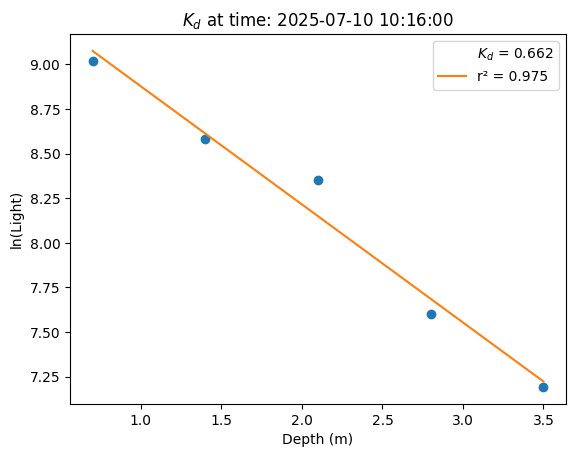

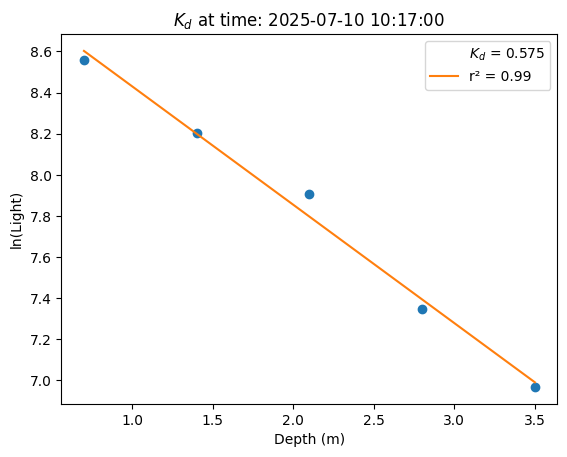

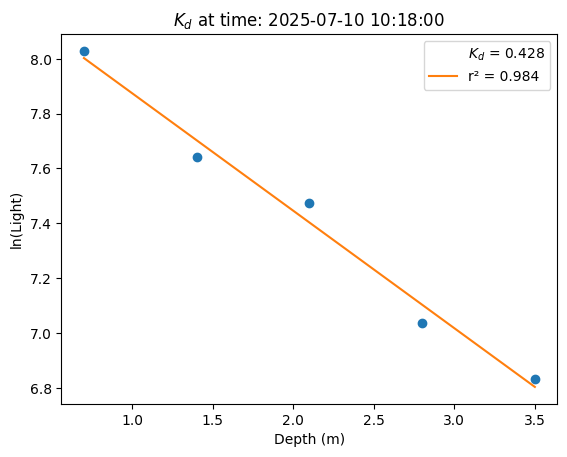

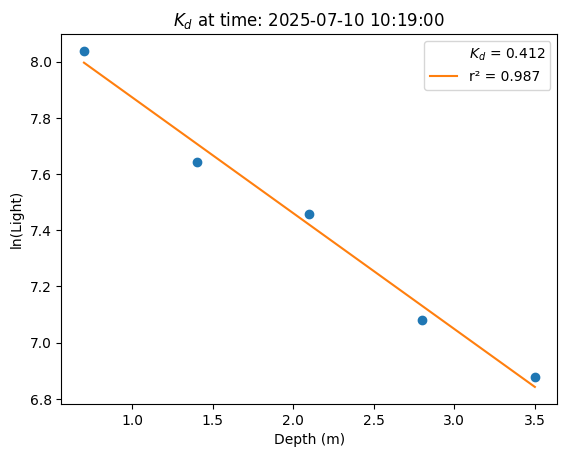

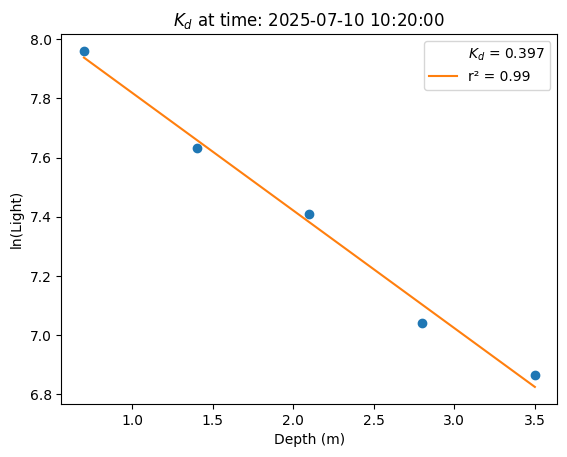

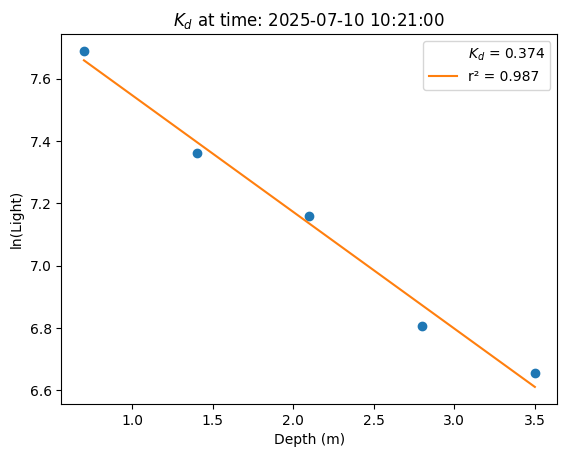

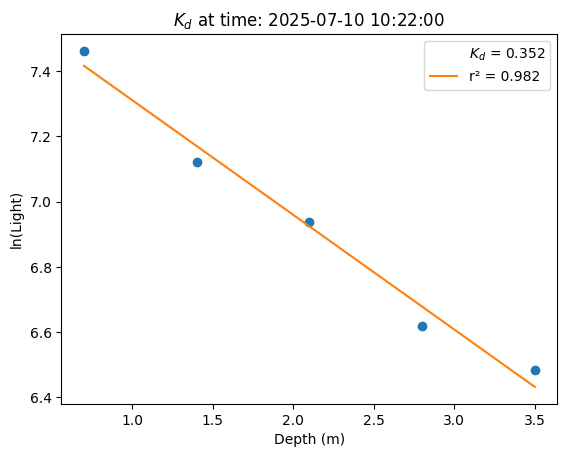

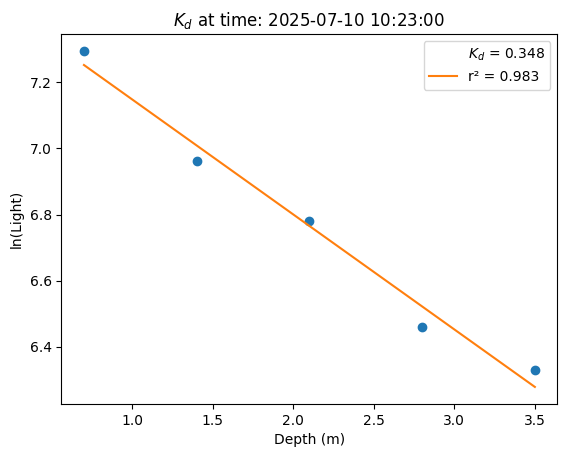

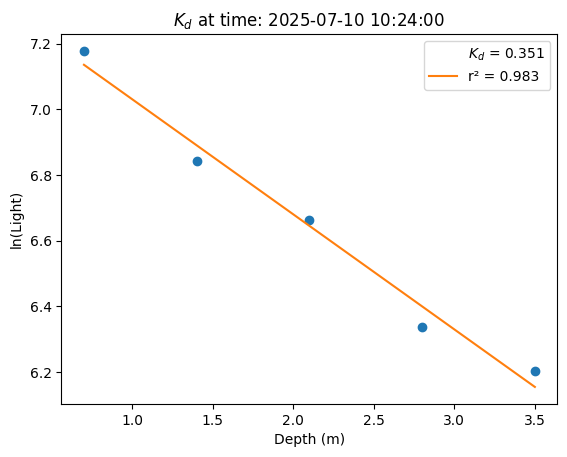

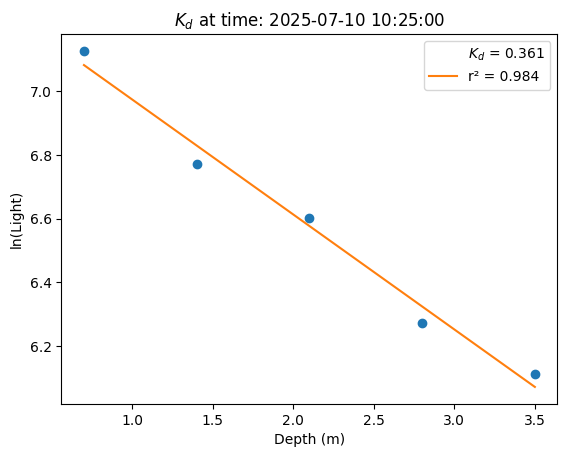

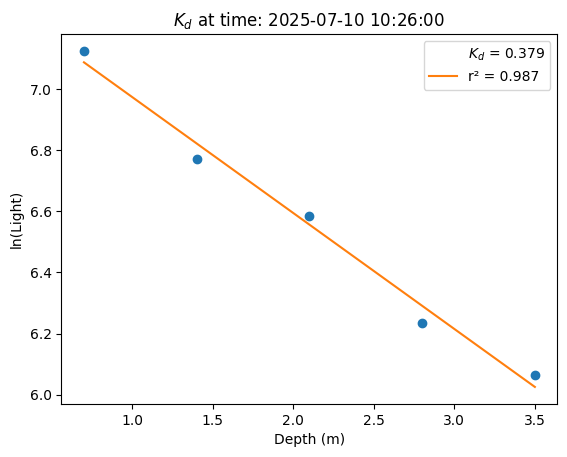

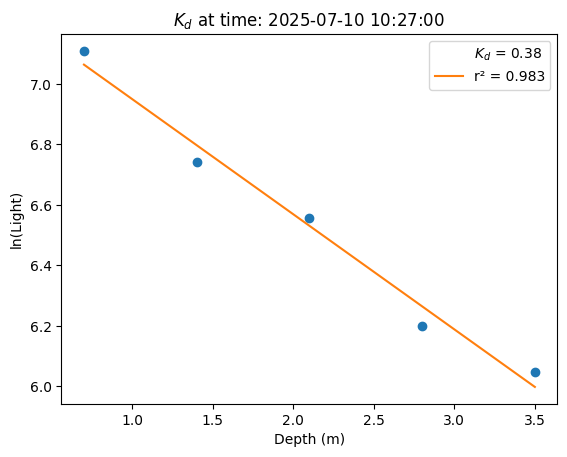

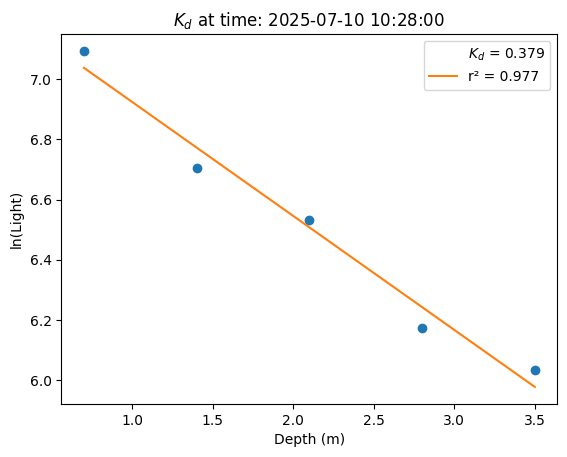

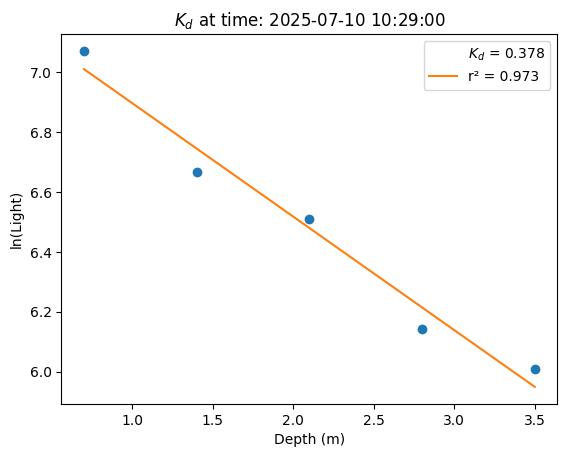

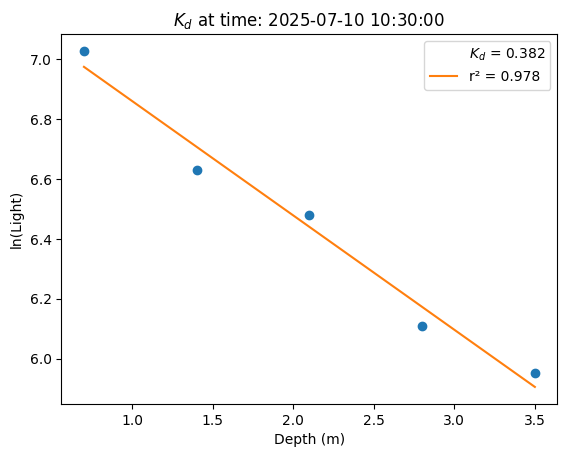

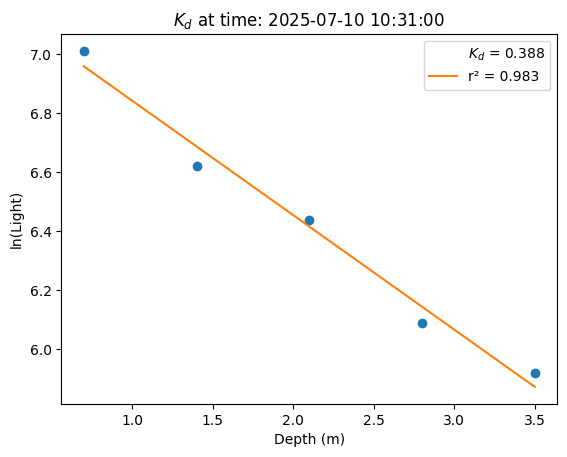

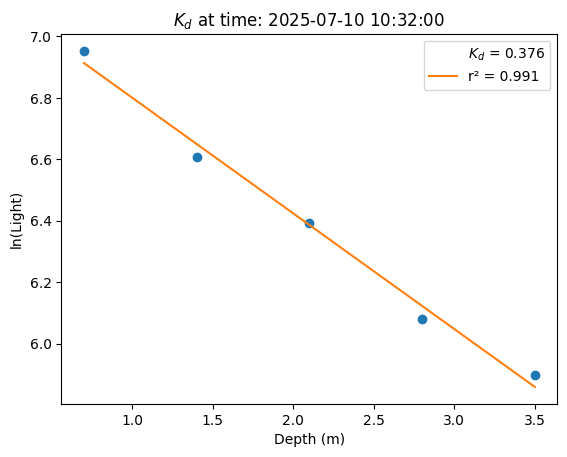

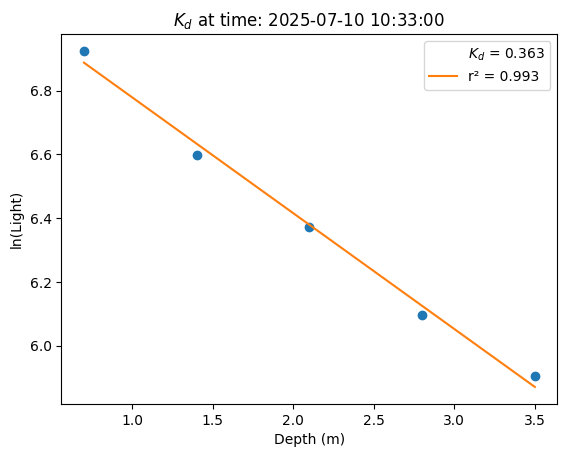

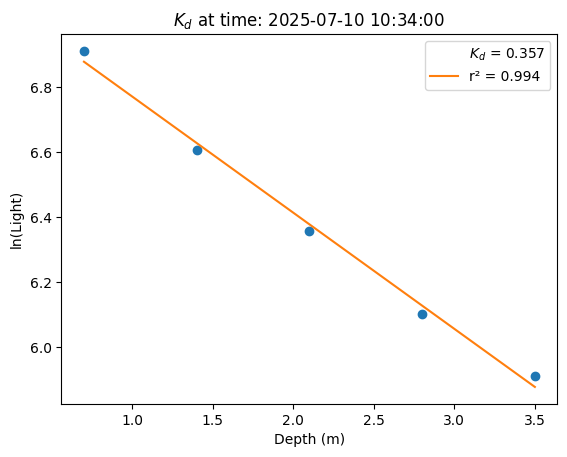

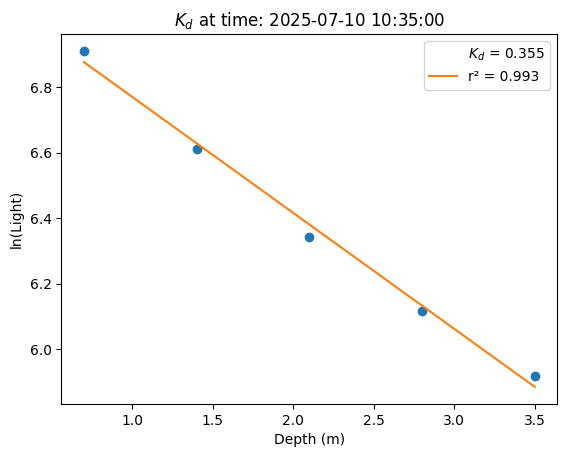

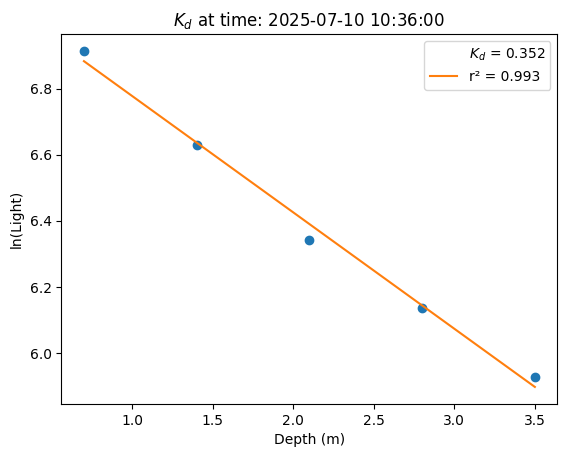

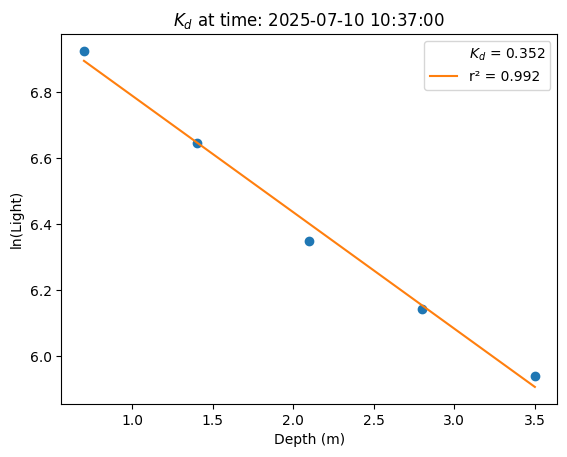

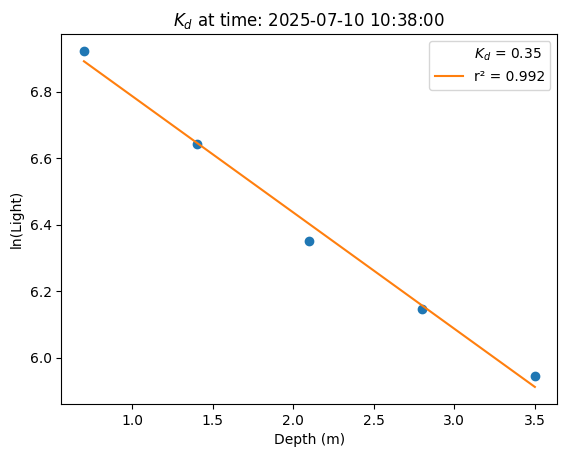

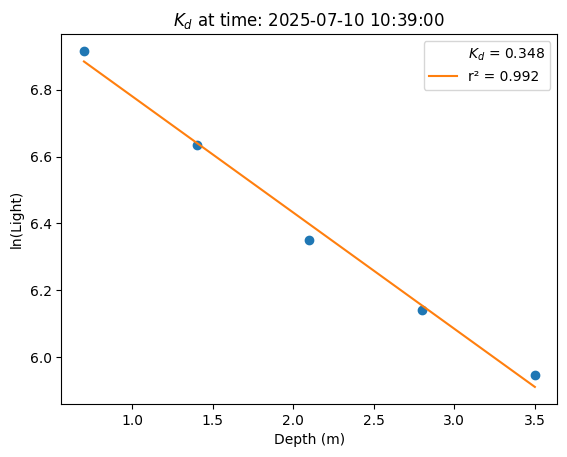

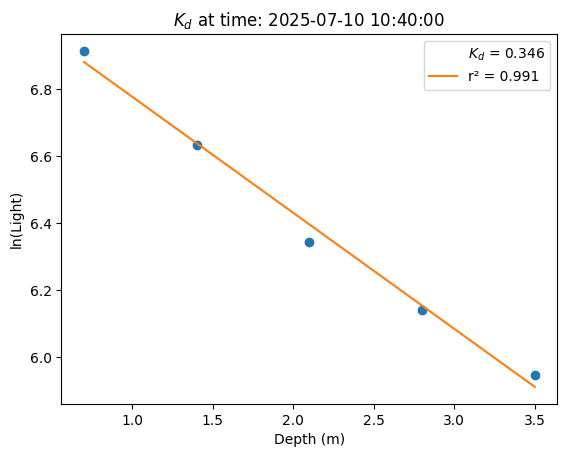

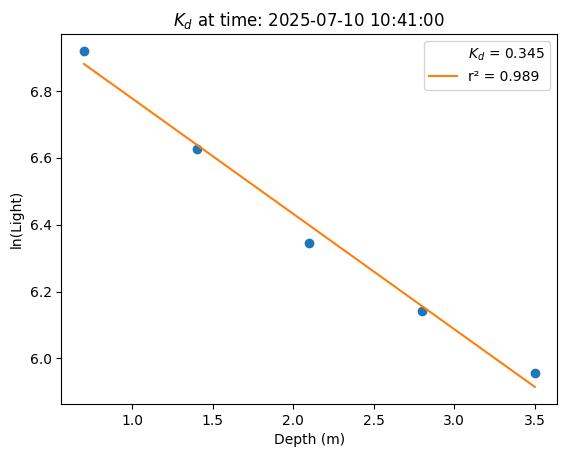

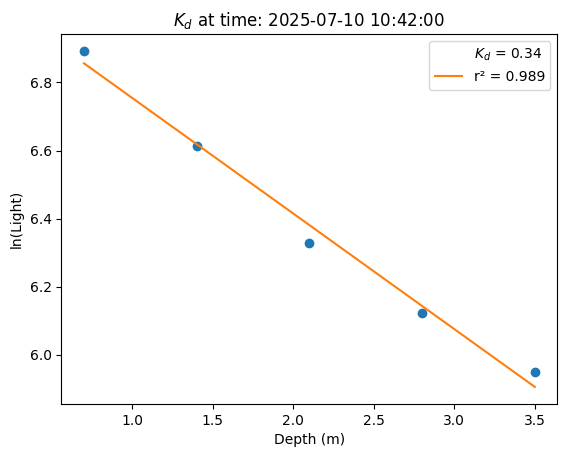

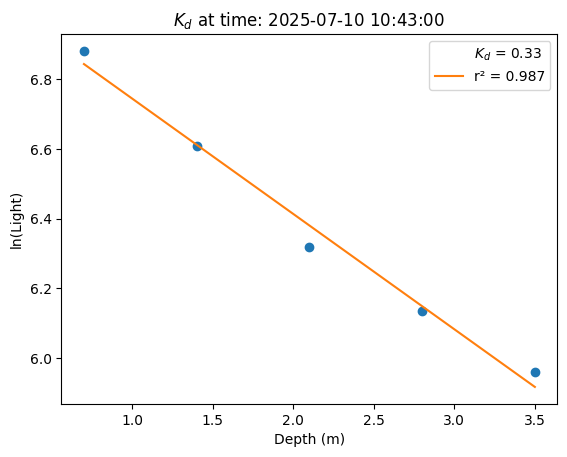

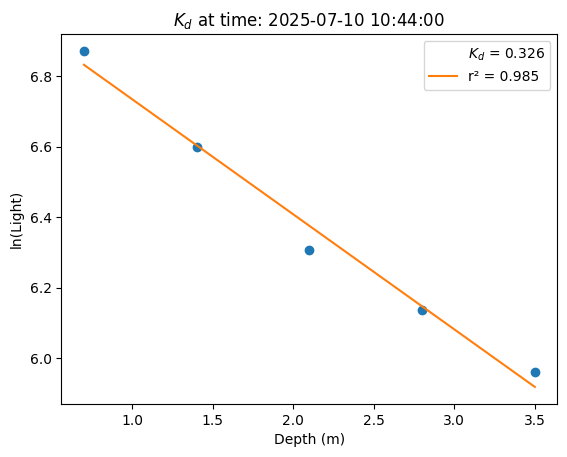

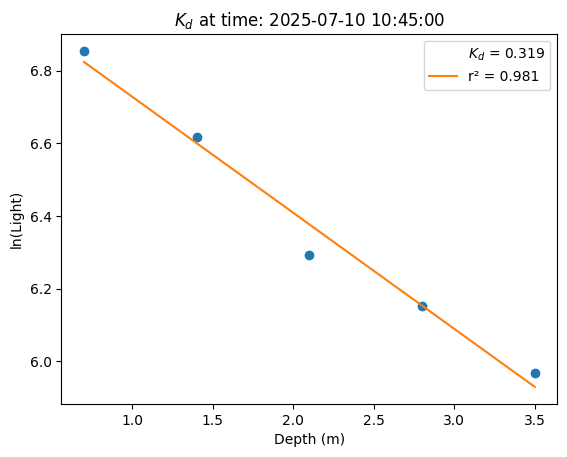

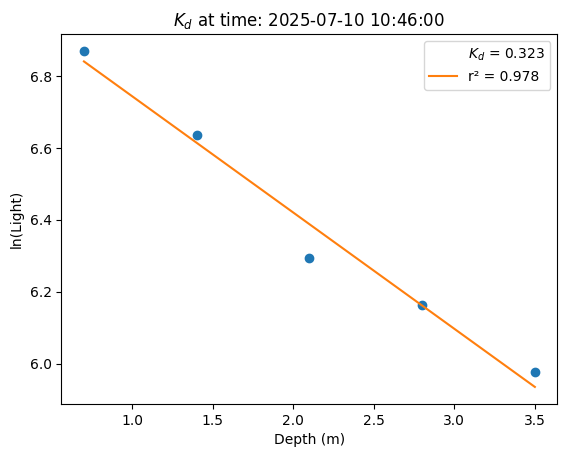

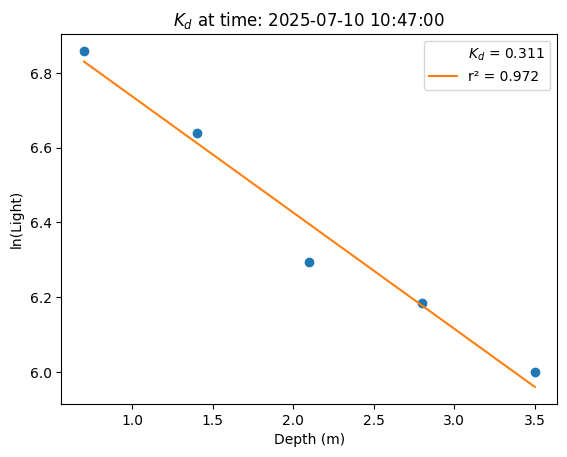

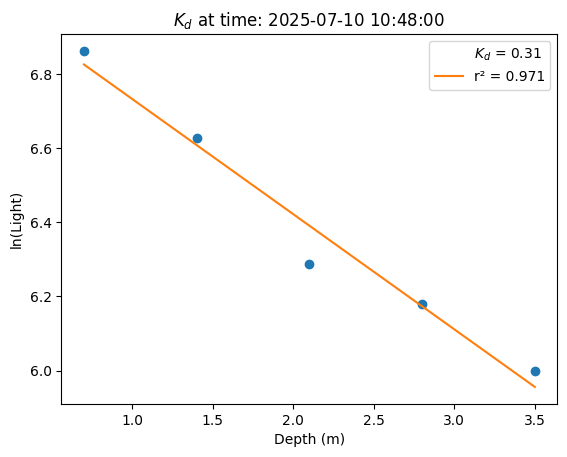

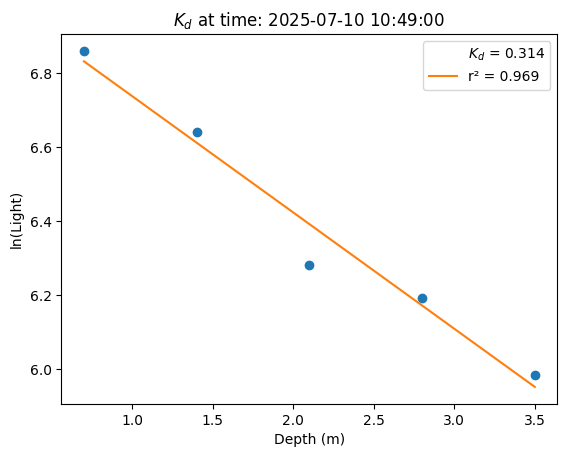

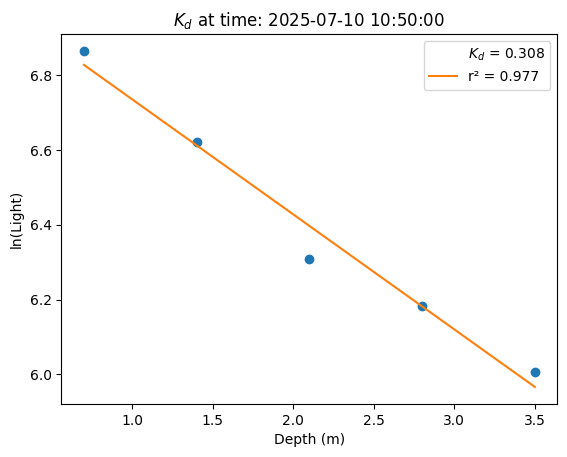

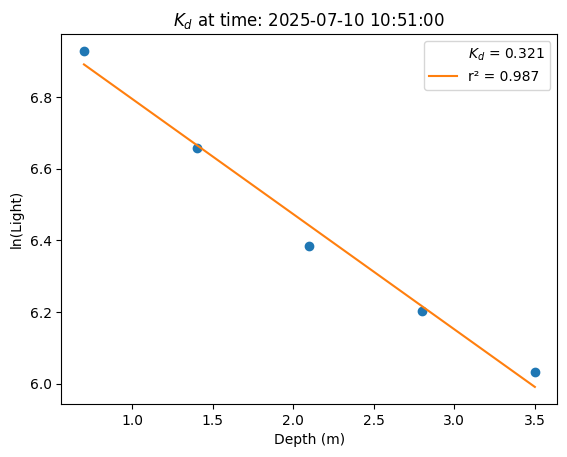

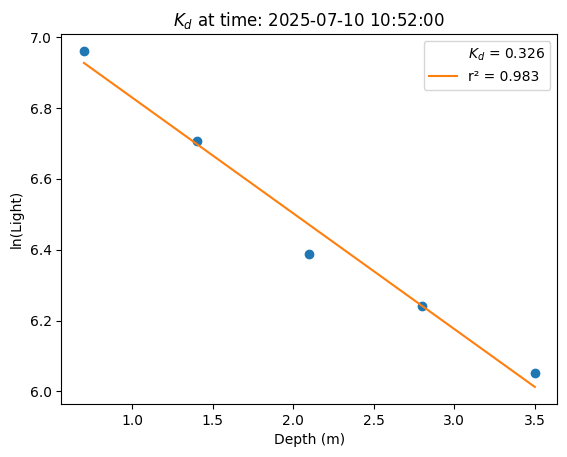

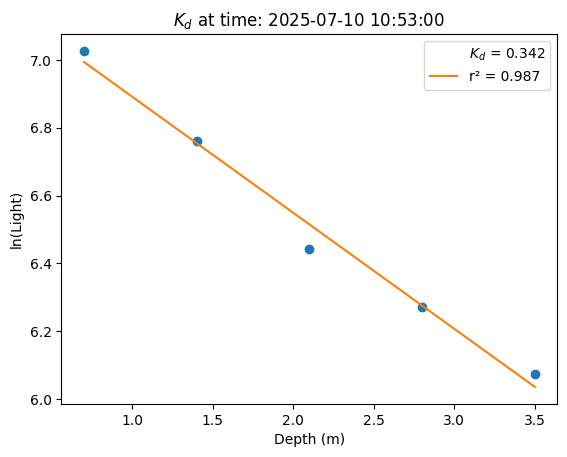

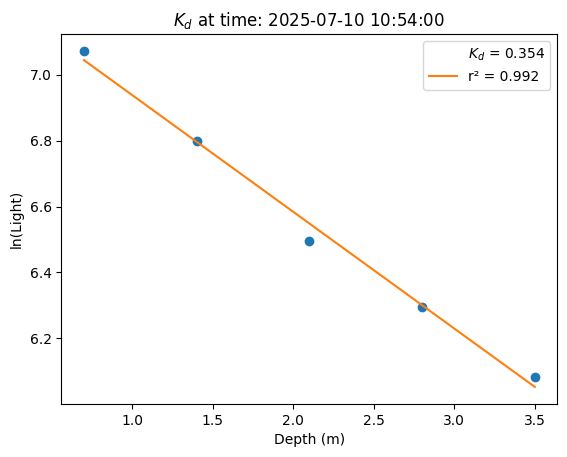

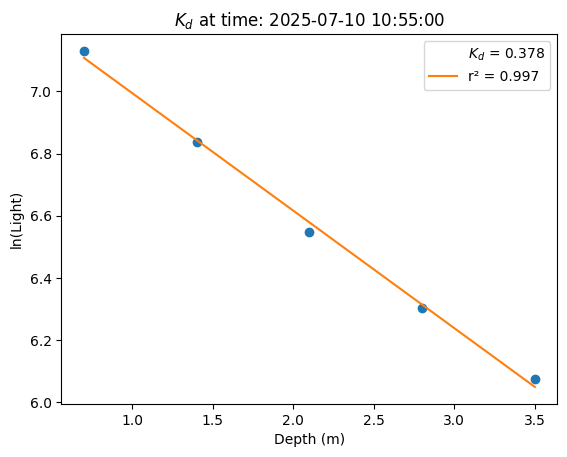

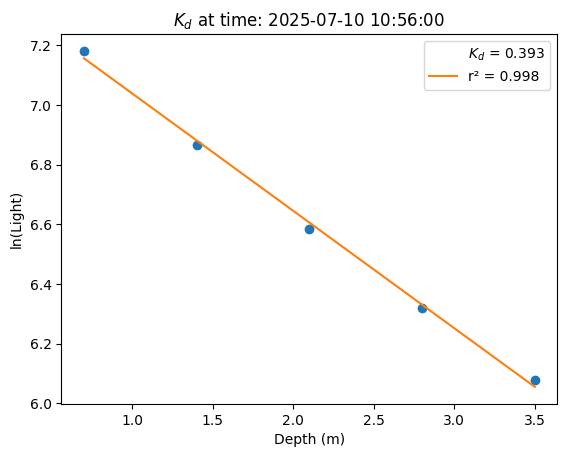

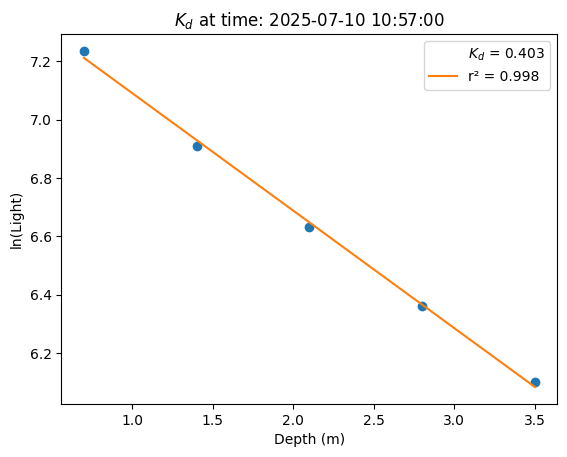

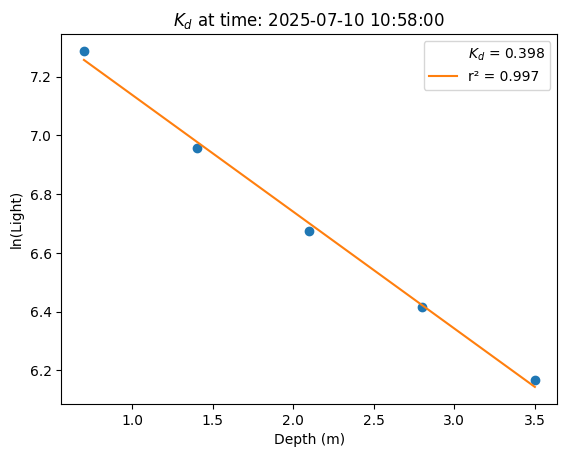

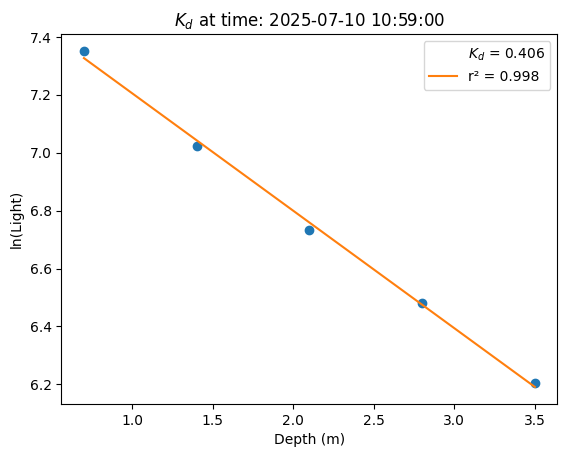

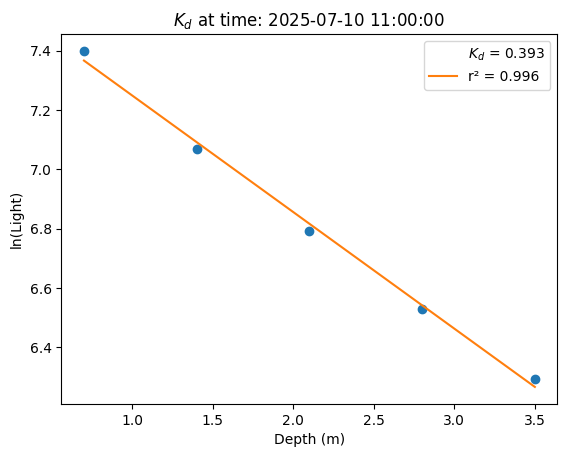

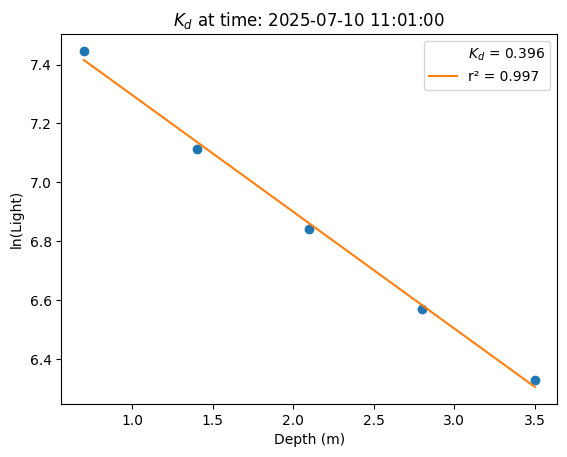

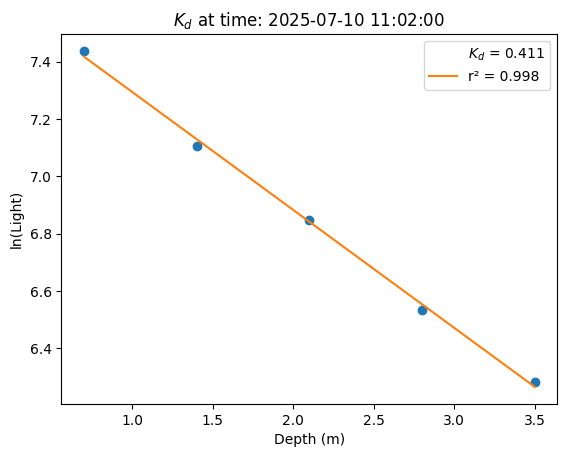

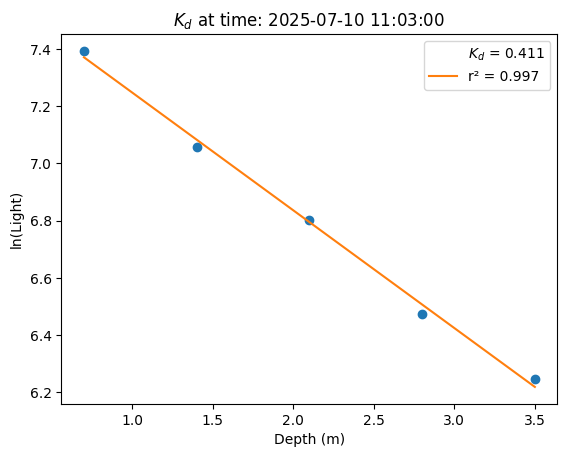

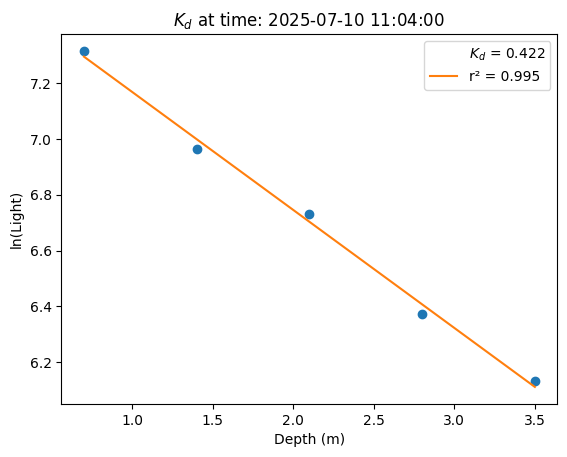

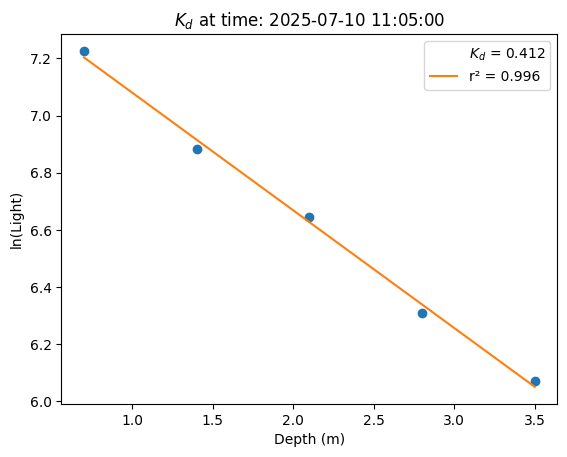

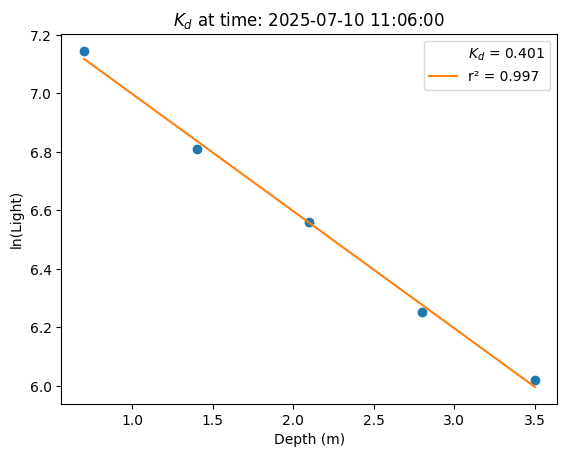

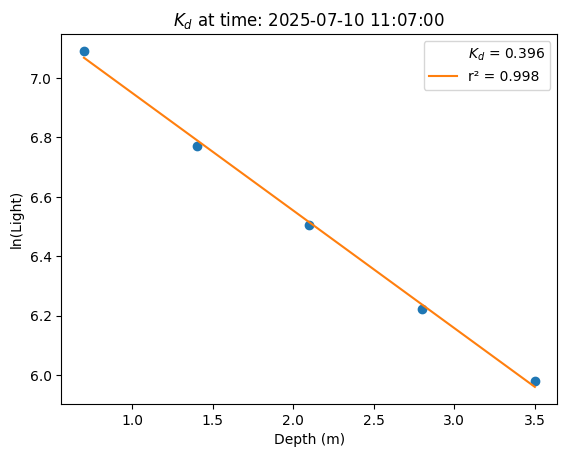

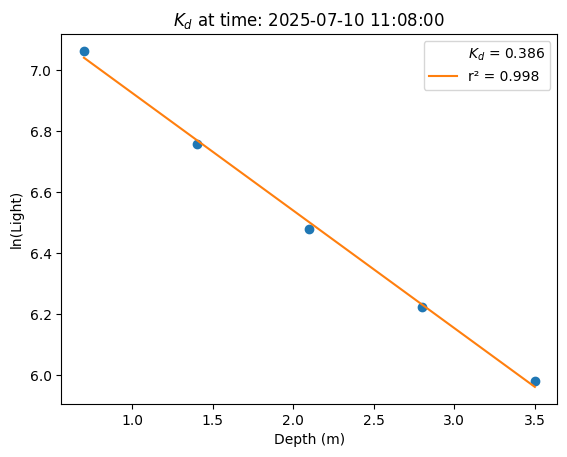

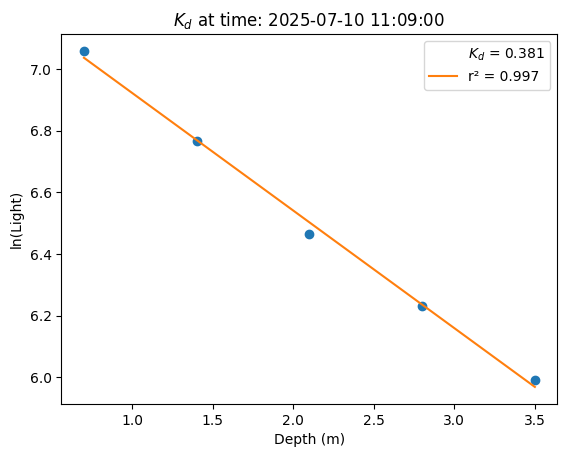

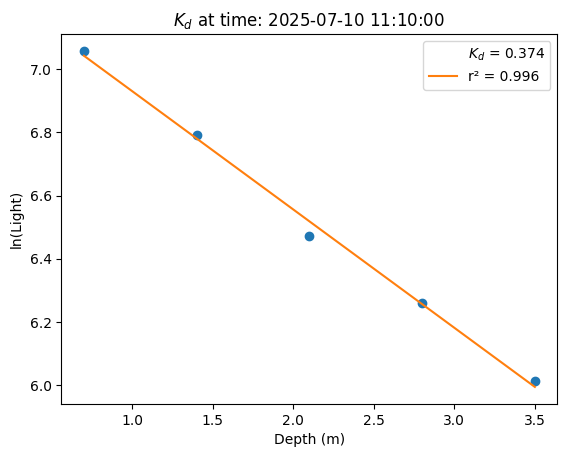

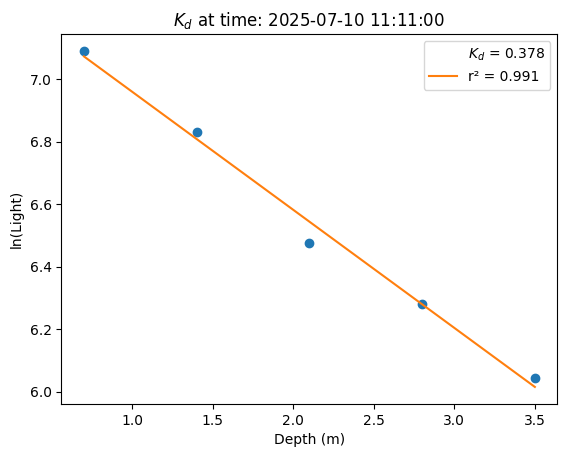

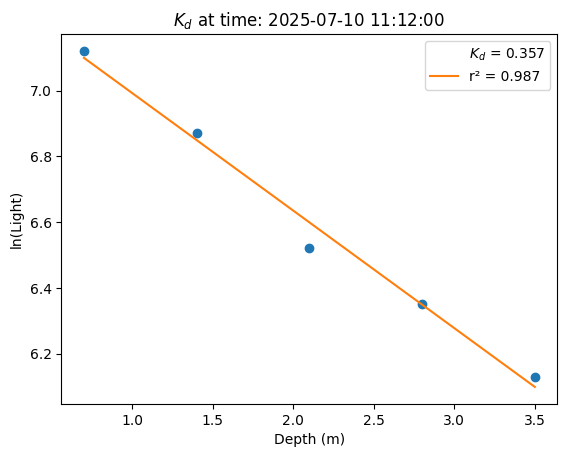

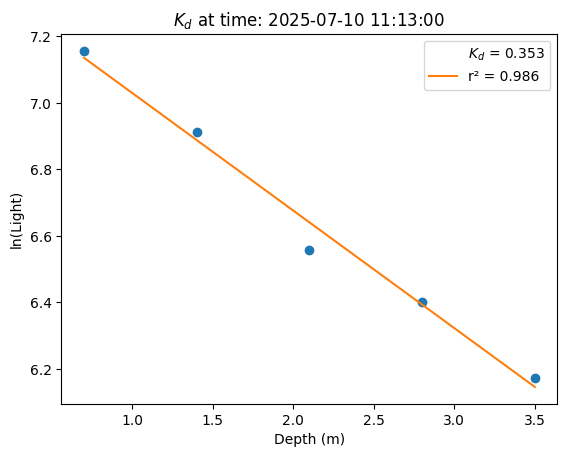

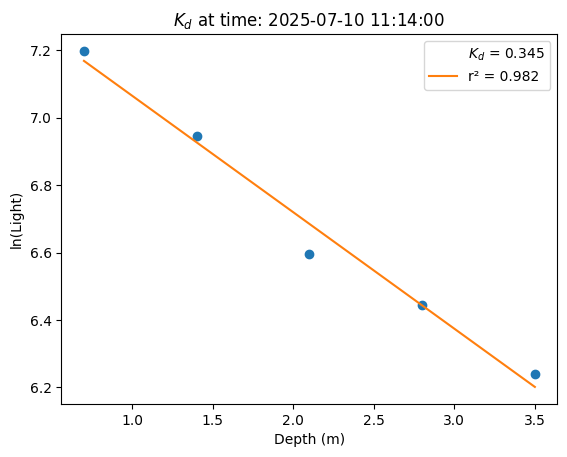

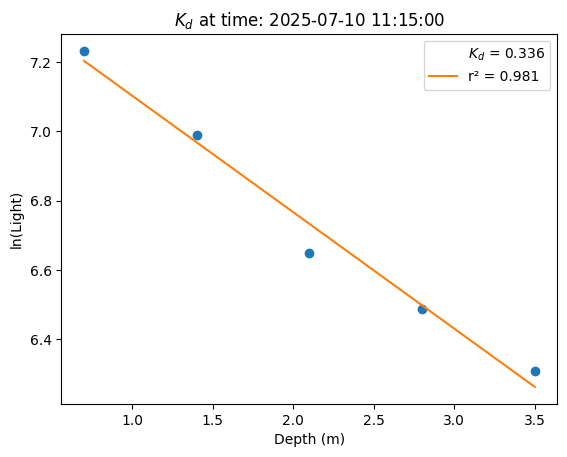

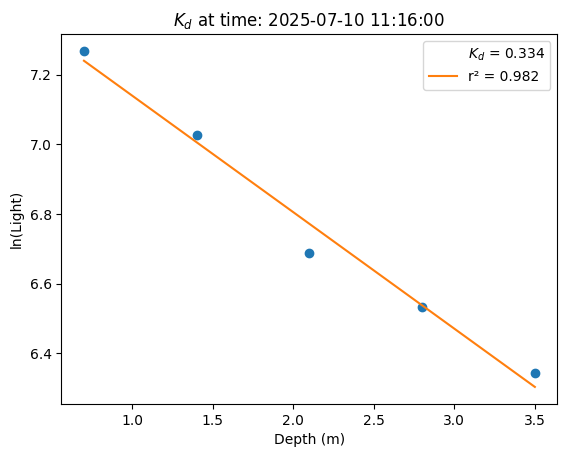

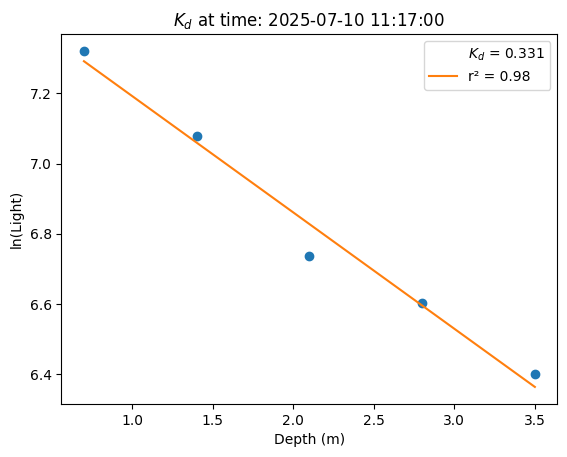

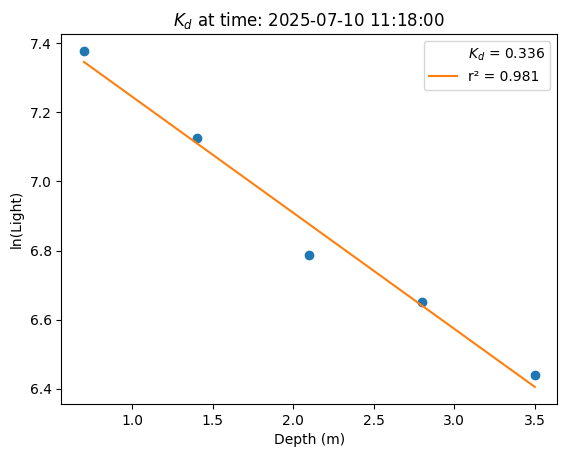

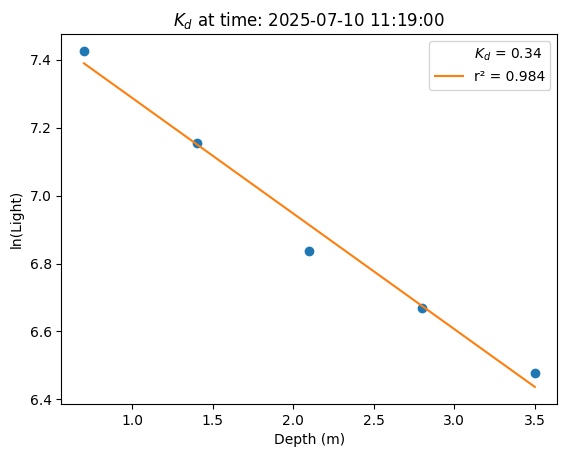

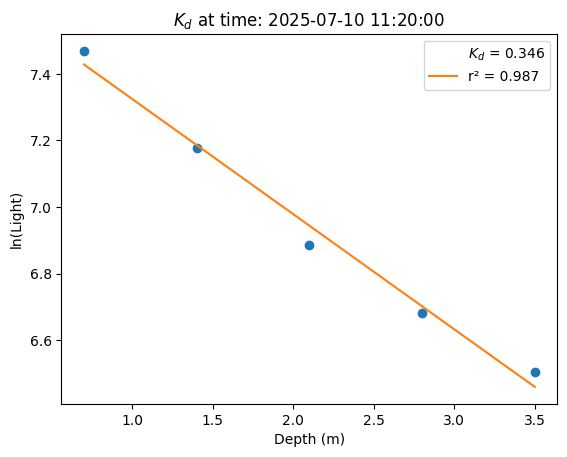

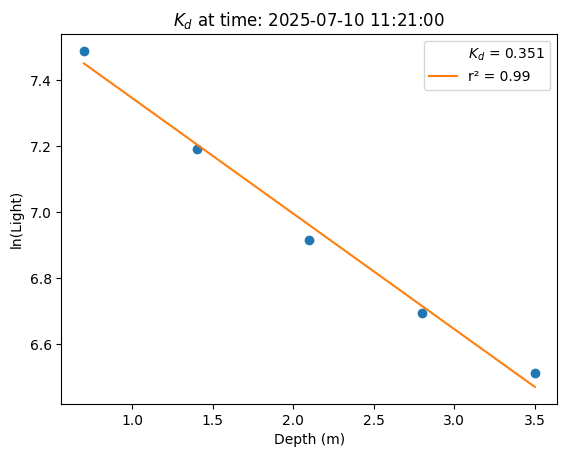

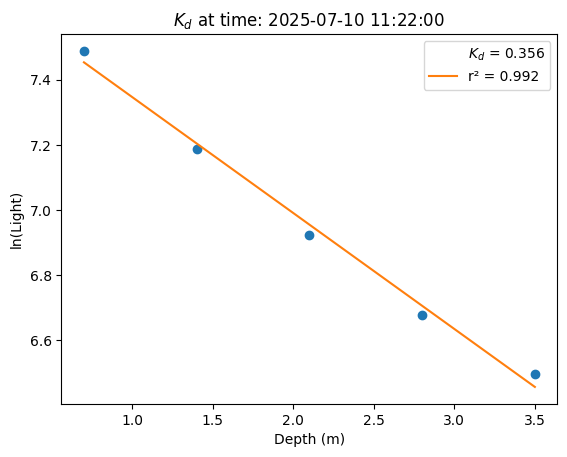

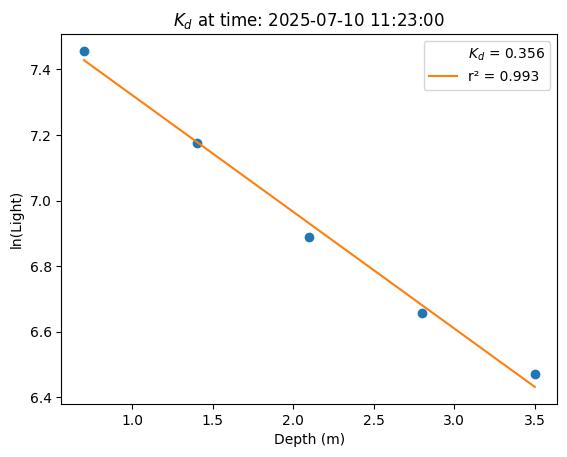

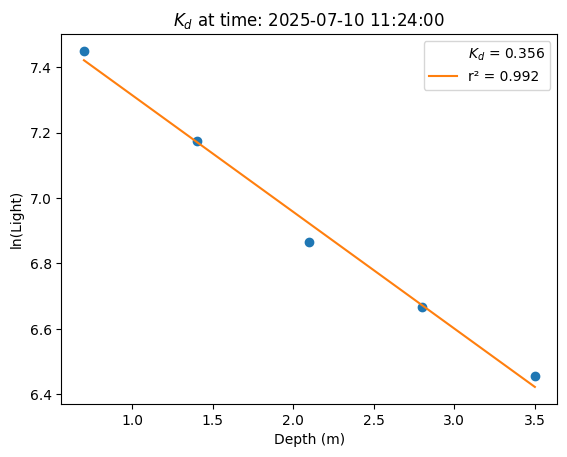

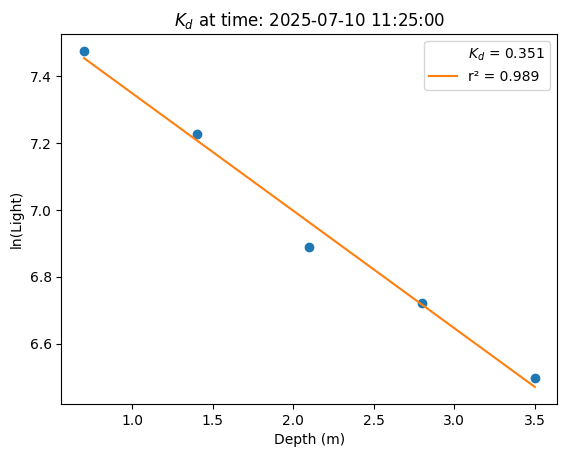

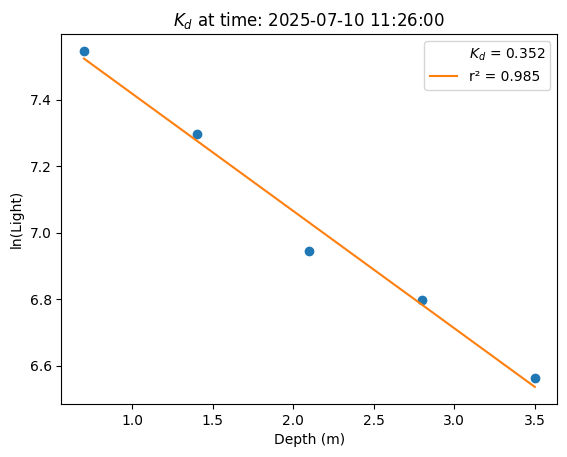

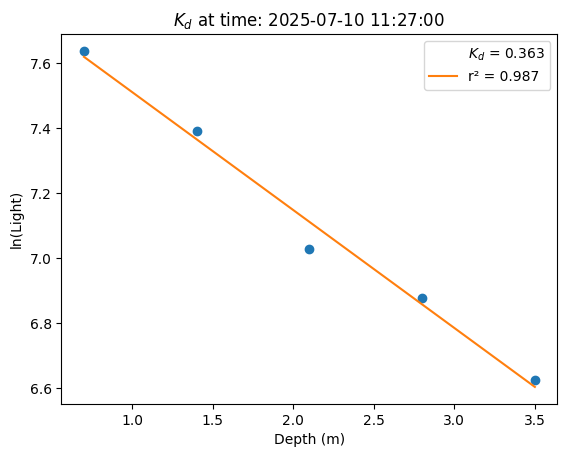

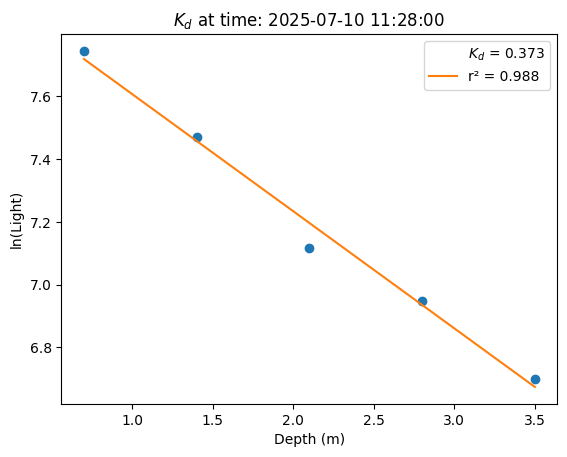

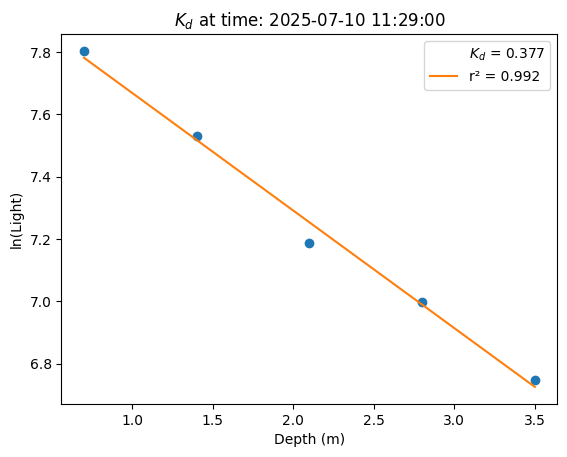

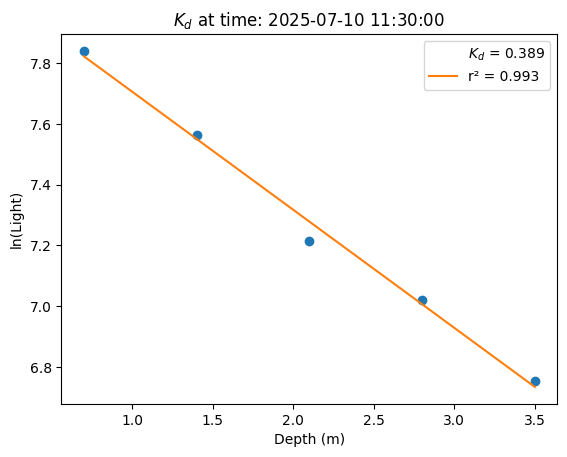

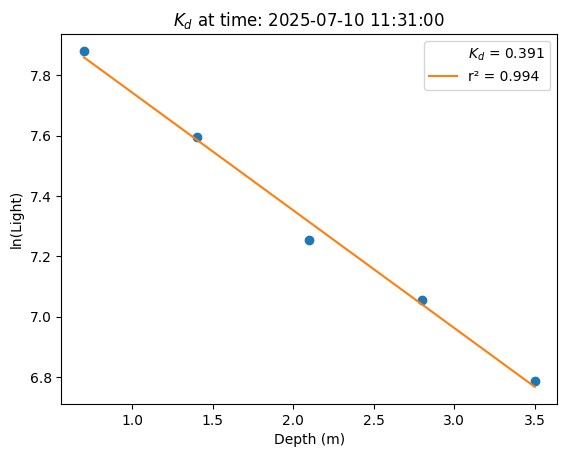

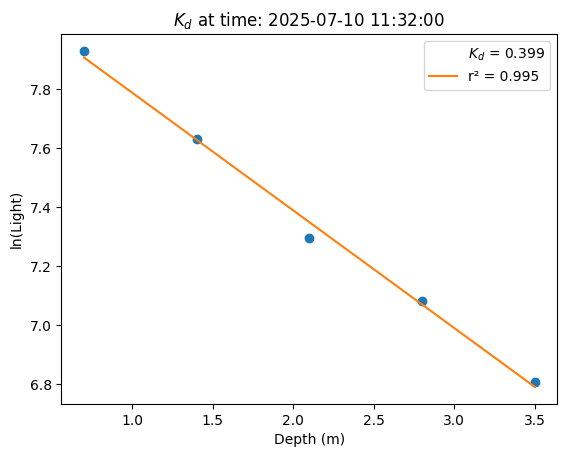

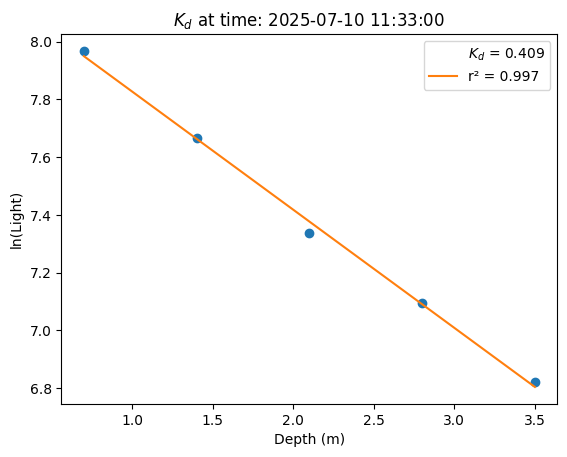

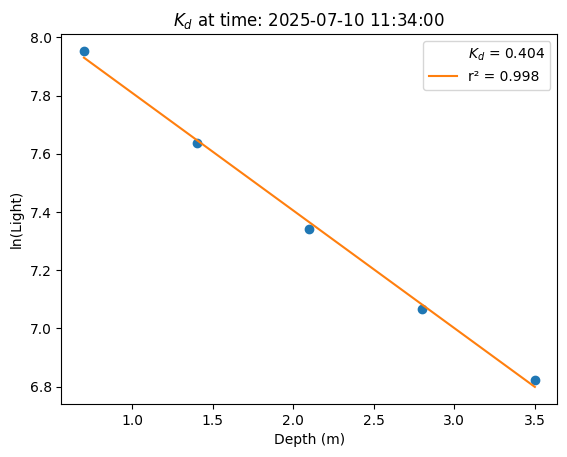

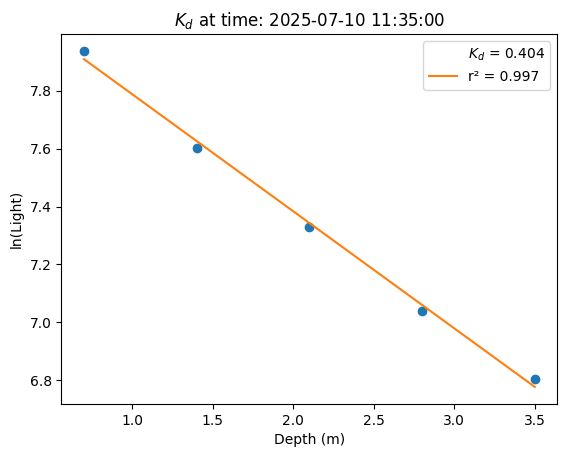

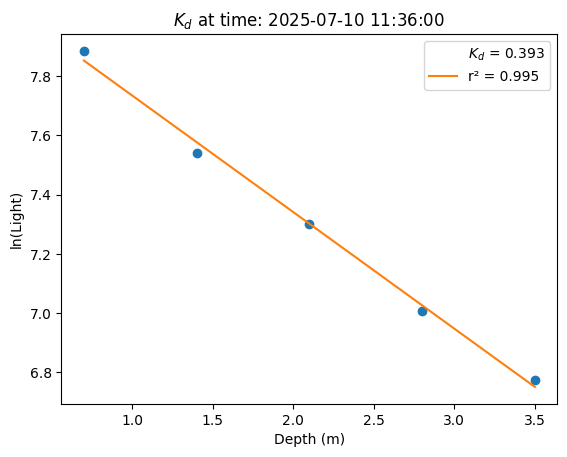

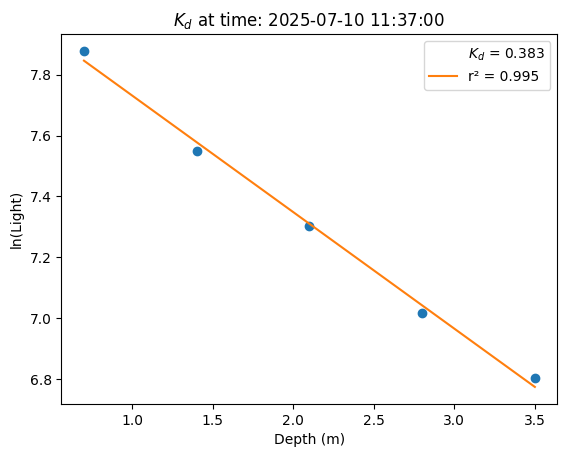

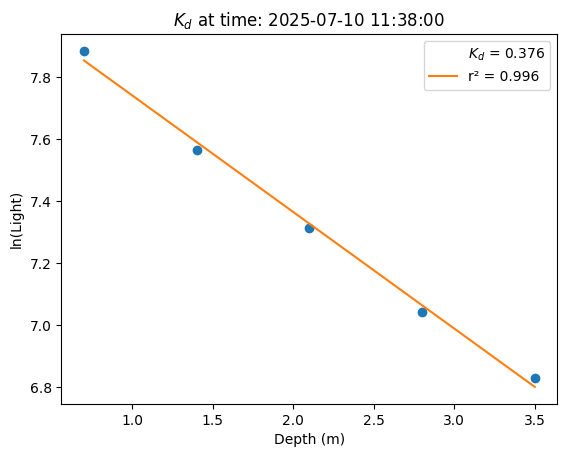

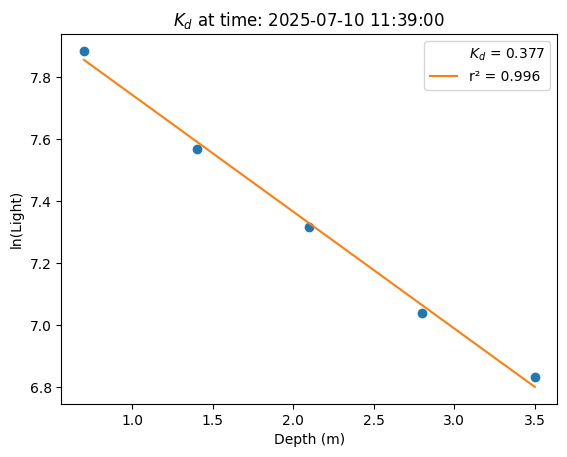

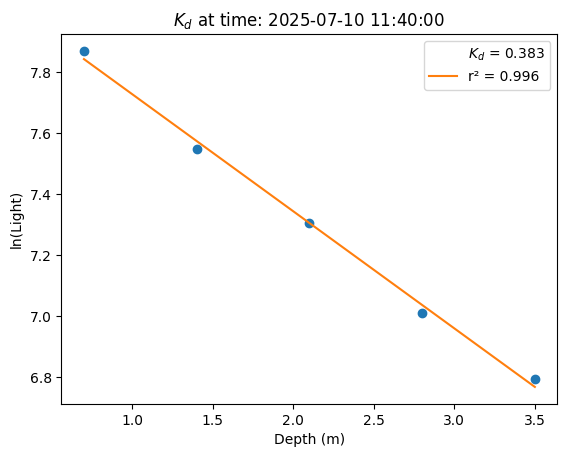

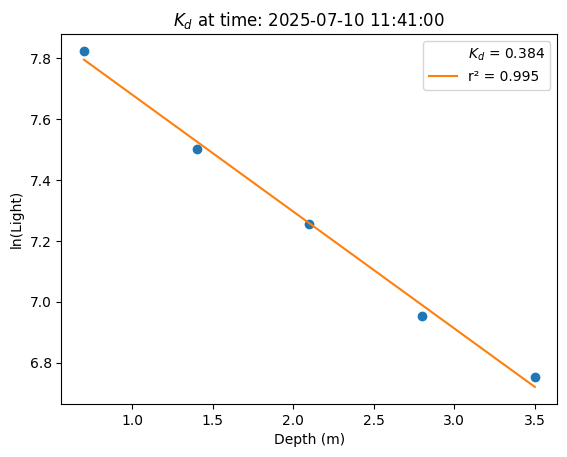

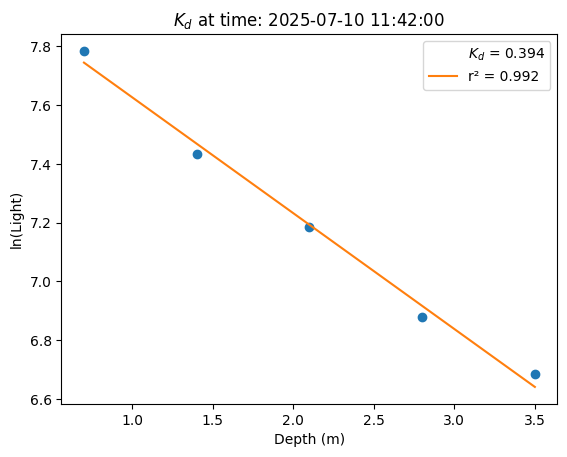

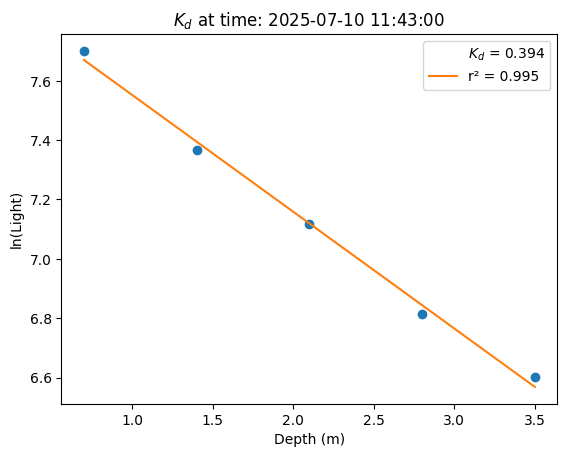

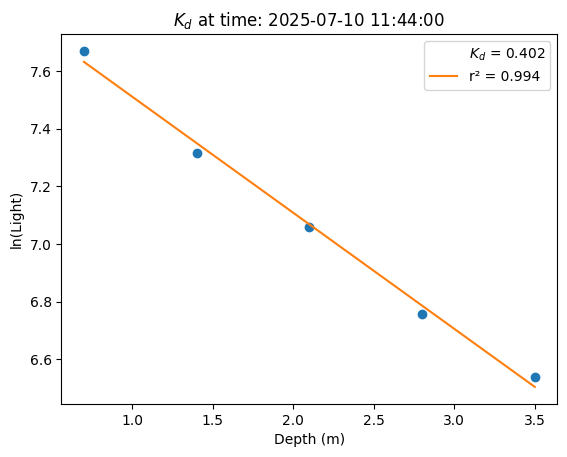

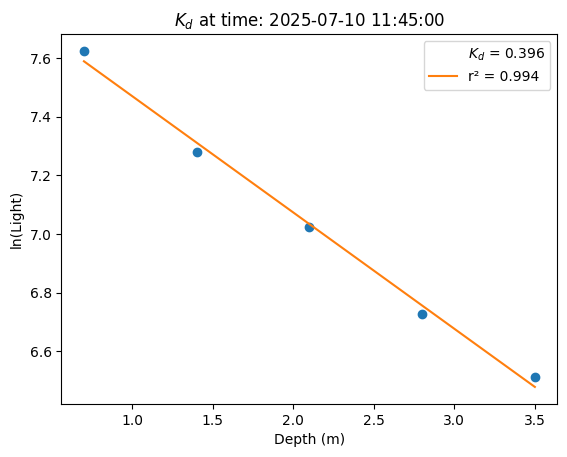

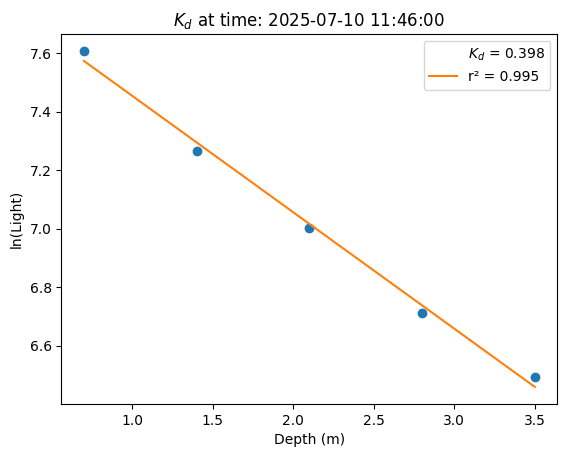

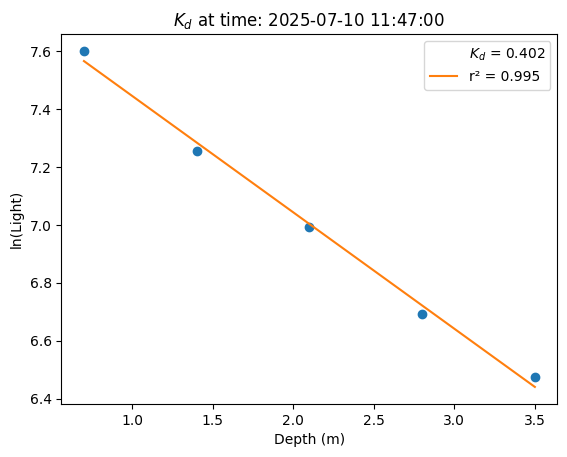

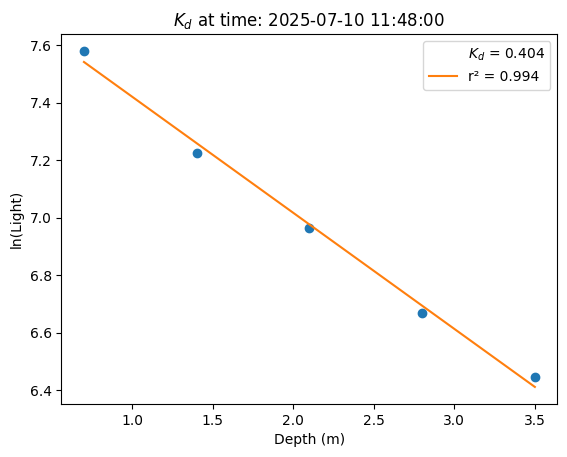

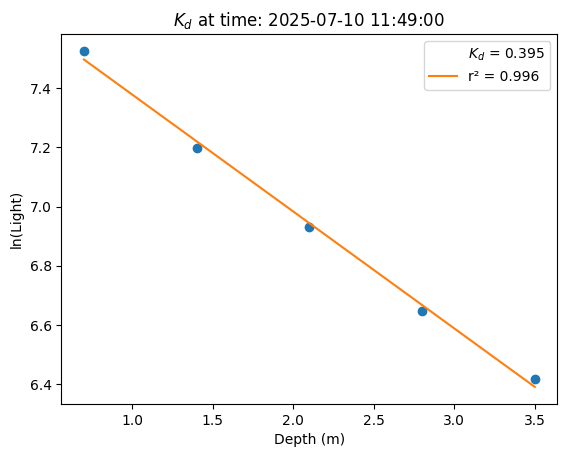

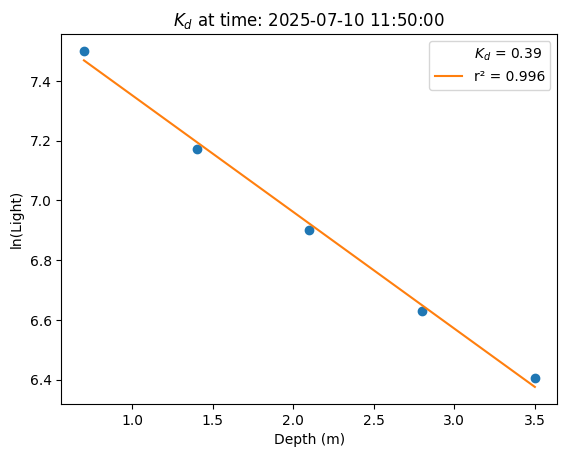

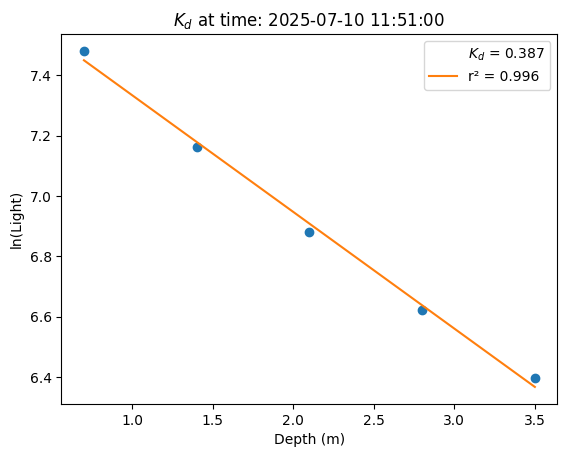

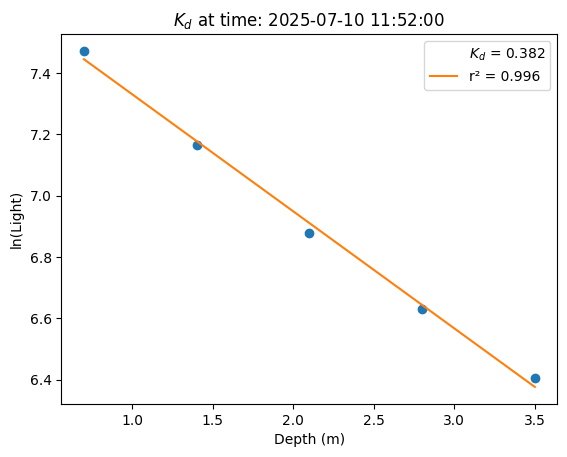

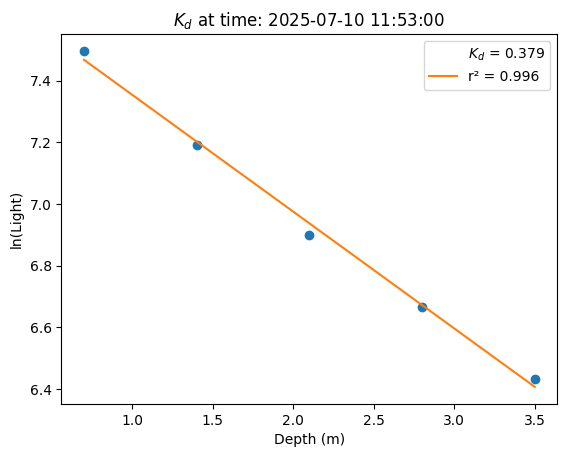

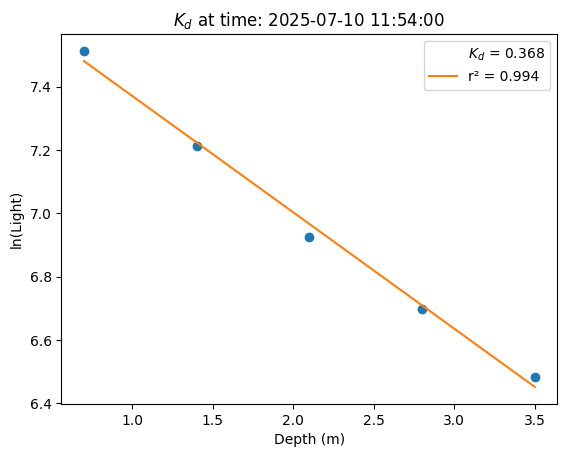

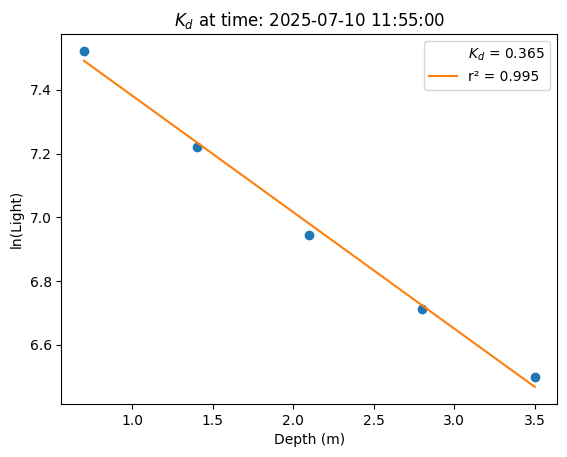

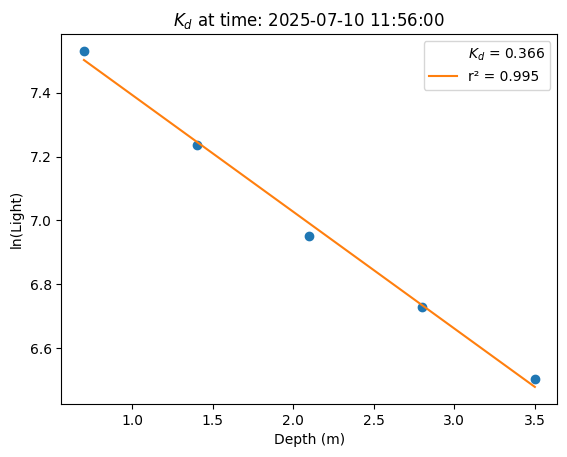

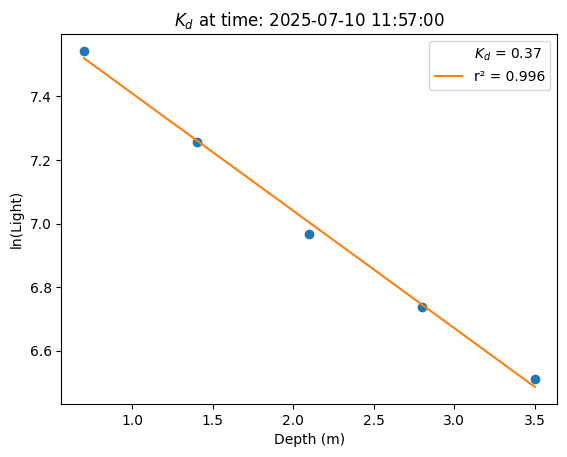

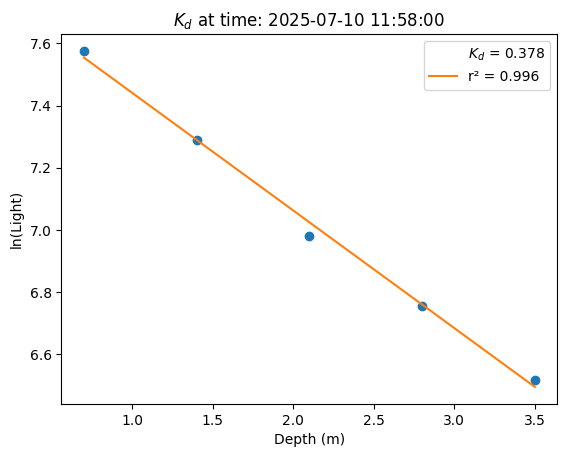

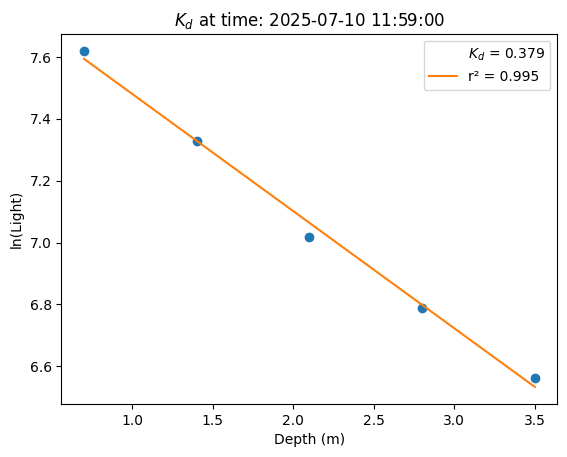

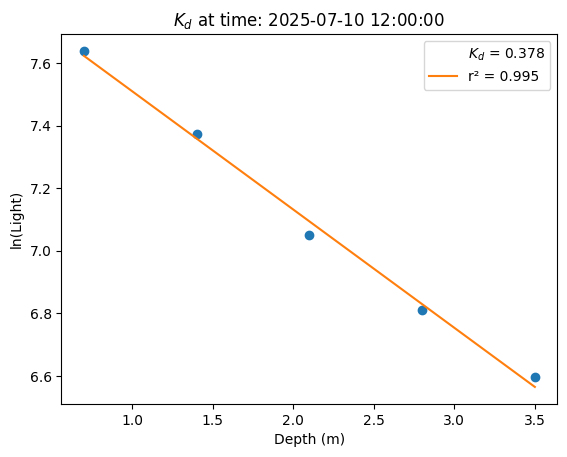

In [11]:
#@title 3.- Plot linear regressions for each minute (in the PAR band)

def plot_linear_regression():
  match_CLEAR = [s for s in wf_all.data if ("CLEAR_" in s) and ("QC" not in s)]

  total_plots = len(wf_clear.data)
  batch = []
  times = []
  plots_per_page = 60
  cols = 10
  rows = math.ceil(plots_per_page / cols)

  # Iterate over each row of data
  for i, (index, _row) in enumerate(wf_clear.data.iterrows()):
  # CLEAR
    row_clear = wf_clear.data.loc[index, match_CLEAR].tolist()
    # calculate Kd from linear regression
    slope, _intercept, r_value, _p_value, _std_err = stats.linregress(depths,
                                                                      np.log(row_clear))

    depths_row_clear = np.array(depths)
    row_clear = np.array(np.log(row_clear))
    # plot depths - values clear
    plt.plot(depths_row_clear, row_clear, marker='o', linestyle="")
    plt.plot(depths_row_clear, slope*depths_row_clear + _intercept)
    plt.xlabel("Depth (m)")
    plt.ylabel("ln(Light)")
    plt.legend([f"$K_d$ = {np.around(slope * (-1), 3)}",
                f'r\N{SUPERSCRIPT TWO} = {np.around(r_value**2, 3)}'], loc='best', markerscale=0)
    plt.title(f"$K_d$ at time: {index.replace(tzinfo=None)}")
    plt.show()

    # --- Prepare for saving to batch image ---
    batch.append((depths_row_clear, row_clear, slope, _intercept, r_value))
    times.append(index)

    # When batch is full OR last plot
    if len(batch) == plots_per_page or i == total_plots - 1:
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
        axes = axes.flatten()

        for j, (d, ln_clear, s, inter, r) in enumerate(batch):
            ax = axes[j]
            ax.plot(d, ln_clear, marker='o', linestyle="")
            ax.plot(d, s * d + inter)
            ax.set_xlabel("Depth (m)", fontsize=8)
            ax.set_ylabel("ln(Light)", fontsize=8)
            ax.set_title(f"Time: {times[j].replace(tzinfo=None)}", fontsize=9)
            ax.tick_params(labelsize=6)
            ax.legend([
                f"$K_d$ = {np.around(-s, 3)}",
                f"$r^2$ = {np.around(r**2, 3)}"
            ], fontsize=7, loc="best", markerscale=0)

        # Turn off unused axes
        for k in range(len(batch), len(axes)):
            axes[k].axis("off")

        plt.tight_layout()
        page_num = math.ceil((i + 1) / plots_per_page)
        plt.savefig(f"results/plot_linear_regression_page_{page_num}_{datetime_start_name}.png", dpi=300)
        plt.close(fig)

        # Reset batch
        batch = []
        times = []

  plt.close('all')

plot_linear_regression()



Plot Kd PAR time series


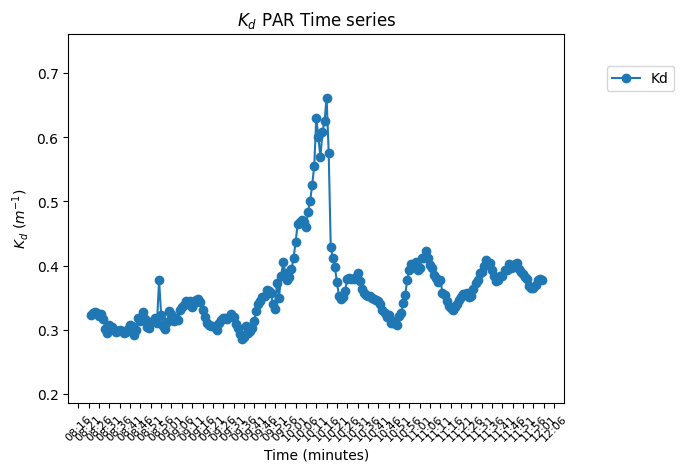



Plot Kd PAR with its coefficient of determination r2


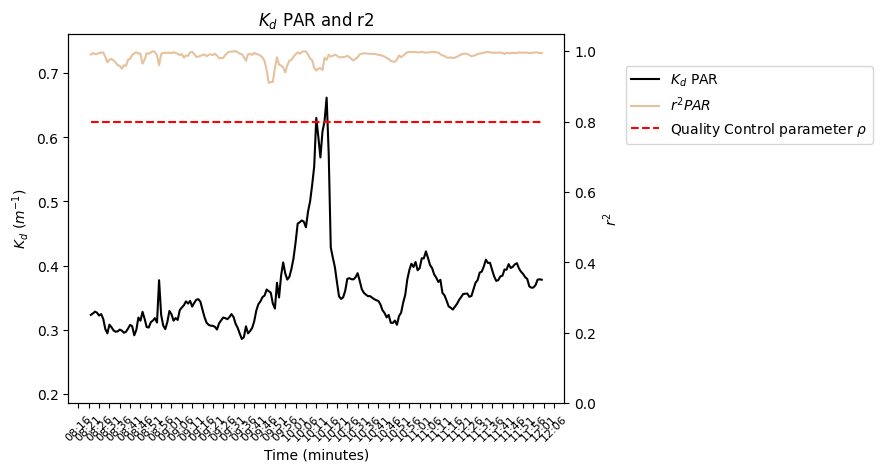




Plot Kd PAR with its coefficient of determination r2 applying Quality Control $\rho$


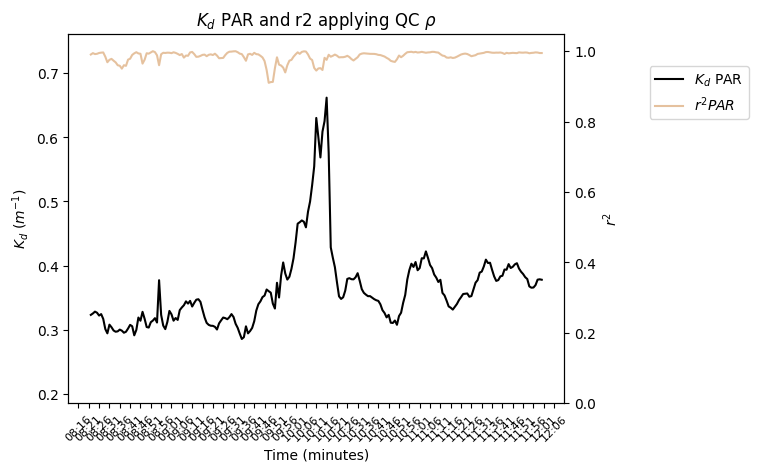



Plot Kd PAR, Kd 415, Kd 445, Kd 480, Kd 515, Kd 555, Kd 590, Kd 630, Kd 680 and Kd NIR time series, with its coefficient of determination r2


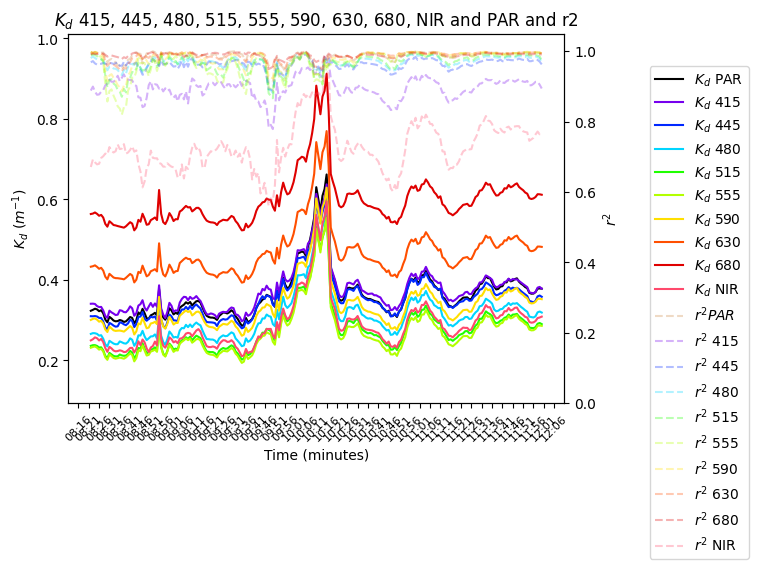

✅ Combined HTML saved at: results/Kd_multispectral_combined_2025-07-10Z08:22T.html


In [12]:
#@title 4.- Plot Kd 415, 445, 480, 515, 555, 590, 630, 680, NIR and PAR with r2 parameter

def plot_Kd():
  # Plot Kd
  print("\n\nPlot Kd PAR time series")
  fig, ax = plt.subplots()
  ax.set_ylabel('$K_d$ ($m^{-1}$)')
  ax.xaxis.set_tick_params(rotation=45)
  ax.tick_params(axis='x', labelsize=8)
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
  plt.plot(wf_all.data['KD_CLEAR'], marker='o', linestyle="-")
  plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
  plt.xlabel("Time (minutes)")

  max_value = wf_all.data['KD_CLEAR'].max()
  min_value = wf_all.data['KD_CLEAR'].min()
  ax.set_ylim([min_value-0.1, max_value+0.1])

  ax.legend(["Kd"],
                            bbox_to_anchor=(1.25, 0.95),
                            borderaxespad=1.,
                            ncol=1,
                            fontsize=8,
                            title_fontsize=10,
                            prop={'size': 10}
                            )
  plt.title("$K_d$ PAR Time series")
  # plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]

  # Save the plot before showing it
  plt.savefig(f"results/Kd_PAR_{datetime_start_name}.png", dpi=300, bbox_inches='tight')

  plt.show()

  plt.close('all')

def plot_KdPAR_r2():
  # Plot Kd
  print("\n\nPlot Kd PAR with its coefficient of determination r2")
  wf_plot = md.WaterFrame()
  wf_plot.metadata = wf_all.metadata
  wf_plot.vocabulary = wf_all.vocabulary

  match_CLEAR = [s for s in wf_all.data if ("CLEAR" in s) and ("QC" not in s)]
  wf_plot.data[match_CLEAR] = wf_all.data.filter(match_CLEAR)

  wf_plot.data['R2_CLEAR_LEVEL'] = r2_value_input

  fig, ax = plt.subplots()
  twin1 = ax.twinx()
  twin1.set_ylabel('$r^2$')
  ax.set_ylabel('$K_d$ ($m^{-1}$)')
  ax.xaxis.set_tick_params(rotation=45)
  ax.tick_params(axis='x', labelsize=8)
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

  p1, = ax.plot(wf_plot.data['KD_CLEAR'], color="black", linestyle='-',
                  label="$K_d$ PAR")

  p2, = twin1.plot(wf_plot.data['R2_CLEAR'], color="peru", linestyle='-', alpha=0.5, label="$r^2 PAR$")
  p3, = twin1.plot(wf_plot.data['R2_CLEAR_LEVEL'], color="red", linestyle='--', label=r"Quality Control parameter $\rho$")

  max_value = wf_all.data['KD_CLEAR'].max()
  min_value = wf_all.data['KD_CLEAR'].min()
  # min_value = -0.5
  ax.set_ylim([min_value-0.1, max_value+0.1])
  twin1.set_ylim([0, 1.05])

  plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
  ax.legend(handles=[p1, p2, p3],
                            bbox_to_anchor=(1.65, 0.95),
                            borderaxespad=1.,
                            ncol=1,
                            fontsize=10,
                            title_fontsize=10,
                            prop={'size': 10}
                            )
  ax.set_xlabel("Time (minutes)")
  plt.title("$K_d$ PAR and r2")
  # plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]

  # Save the plot before showing it
  plt.savefig(f"results/Kd_PAR_r2_{datetime_start_name}.png", dpi=300, bbox_inches='tight')

  plt.show()

  plt.close('all')

def plot_KdPAR_r2_interpolate():
  # Plot Kd
  print("\n\n")
  print(r"Plot Kd PAR with its coefficient of determination r2 applying Quality Control $\rho$")
  wf_plot = md.WaterFrame()
  wf_plot.metadata = wf_all.metadata
  wf_plot.vocabulary = wf_all.vocabulary

  match_CLEAR = [s for s in wf_all.data if ("CLEAR" in s) and ("QC" not in s)]
  wf_plot.data[match_CLEAR] = wf_all.data.filter(match_CLEAR)

  wf_plot.data = wf_plot.data.mask(wf_plot.data['R2_CLEAR'] < r2_value_input)
  wf_plot.data = wf_plot.data.interpolate(method='linear', axis=0).ffill().bfill()
  plt.close('all')
  fig, ax = plt.subplots()
  twin1 = ax.twinx()
  twin1.set_ylabel('$r^2$')
  ax.set_ylabel('$K_d$ ($m^{-1}$)')
  ax.xaxis.set_tick_params(rotation=45)
  ax.tick_params(axis='x', labelsize=8)
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

  p1, = ax.plot(wf_plot.data['KD_CLEAR'], color="black", linestyle='-',
                  label="$K_d$ PAR")

  p2, = twin1.plot(wf_plot.data['R2_CLEAR'], color="peru", linestyle='-', alpha=0.5, label="$r^2 PAR$")

  max_value = wf_all.data['KD_CLEAR'].max()
  min_value = wf_all.data['KD_CLEAR'].min()
  # min_value = -0.5
  ax.set_ylim([min_value-0.1, max_value+0.1])
  twin1.set_ylim([0, 1.05])

  plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
  ax.legend(handles=[p1, p2],
                            bbox_to_anchor=(1.40, 0.95),
                            borderaxespad=1.,
                            ncol=1,
                            fontsize=10,
                            title_fontsize=10,
                            prop={'size': 10}
                            )
  ax.set_xlabel("Time (minutes)")
  plt.title(r"$K_d$ PAR and r2 applying QC $\rho$")
  # plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]

  # Save the plot before showing it
  plt.savefig(f"results/Kd_PAR_r2_appliying_QC_{datetime_start_name}.png", dpi=300, bbox_inches='tight')

  plt.show()

  plt.close('all')

def plot_Kd_r2():
  # Plot Kd
  print("\n\nPlot Kd PAR, Kd Red, Kd Green and Kd Blue time series, with its coefficient of determination r2")
  plt.close('all')
  fig, ax = plt.subplots()
  twin1 = ax.twinx()
  twin1.set_ylabel('$r^2$')
  ax.set_ylabel('$K_d$ ($m^{-1}$)')
  ax.xaxis.set_tick_params(rotation=45)
  ax.tick_params(axis='x', labelsize=8)
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

  p1, = ax.plot(wf_all.data['KD_CLEAR'], color="black", linestyle='-',
                  label="$K_d$ PAR")

  p1R, = ax.plot(wf_all.data['KD_RED'], color="red", linestyle='-',
                  label="$K_d$ red")

  p1G, = ax.plot(wf_all.data['KD_GREEN'], color="green", linestyle='-',
                  label="$K_d$ green")

  p1B, = ax.plot(wf_all.data['KD_BLUE'], color="blue", linestyle='-',
                  label="$K_d$ blue")

  p2, = twin1.plot(wf_all.data['R2_CLEAR'], color="peru", linestyle='--', alpha=0.3, label="$r^2 PAR$")
  p2R, = twin1.plot(wf_all.data['R2_RED'], color="red", linestyle='--', alpha=0.3, label="$r^2$ RED")
  p2G, = twin1.plot(wf_all.data['R2_GREEN'], color="green", linestyle='--', alpha=0.3, label="$r^2$ GREEN")
  p2B, = twin1.plot(wf_all.data['R2_BLUE'], color="blue", linestyle='--', alpha=0.3, label="$r^2$ BLUE")

  max_value = wf_all.data[['KD_CLEAR', 'KD_RED', 'KD_GREEN', 'KD_BLUE']].max().max()
  min_value = wf_all.data[['KD_CLEAR', 'KD_RED', 'KD_GREEN', 'KD_BLUE']].min().min()
  # min_value = -0.5
  ax.set_ylim([min_value-0.1, max_value+0.1])
  twin1.set_ylim([0, 1.05])

  plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
  # ax.legend(handles=[p1, p1R, p1G, p1B, p2],
  ax.legend(handles=[p1, p1R, p1G, p1B, p2, p2R, p2G, p2B],
                            bbox_to_anchor=(1.40, 0.95),
                            borderaxespad=1.,
                            ncol=1,
                            fontsize=10,
                            title_fontsize=10,
                            prop={'size': 10}
                            )
  ax.set_xlabel("Time (minutes)")
  plt.title("$K_d$ PAR-RGB and r2")
  # plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
  plt.show()

  plt.close('all')

def plot_Kd_r2_multi():
  # Plot Kd
  print("\n\nPlot Kd PAR, Kd 415, Kd 445, Kd 480, Kd 515, Kd 555, Kd 590, Kd 630, Kd 680 and Kd NIR time series, with its coefficient of determination r2")
  plt.close('all')
  fig, ax = plt.subplots()
  twin1 = ax.twinx()
  twin1.set_ylabel('$r^2$')
  ax.set_ylabel('$K_d$ ($m^{-1}$)')
  ax.xaxis.set_tick_params(rotation=45)
  ax.tick_params(axis='x', labelsize=8)
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

  p1, = ax.plot(wf_all.data['KD_CLEAR'], color="black", linestyle='-',
                  label="$K_d$ PAR")

  p1415, = ax.plot(wf_all.data['KD_415'], color=(118/255, 0/255, 237/255), linestyle='-',
                  label="$K_d$ 415")

  p1445, = ax.plot(wf_all.data['KD_445'], color=(0/255, 40/255, 255/255), linestyle='-',
                  label="$K_d$ 445")

  p1480, = ax.plot(wf_all.data['KD_480'], color=(0/255, 213/255, 255/255), linestyle='-',
                  label="$K_d$ 480")

  p1515, = ax.plot(wf_all.data['KD_515'], color=(31/255, 255/255, 0/255), linestyle='-',
                  label="$K_d$ 515")

  p1555, = ax.plot(wf_all.data['KD_555'], color=(179/255, 255/255, 0/255), linestyle='-',
                  label="$K_d$ 555")

  p1590, = ax.plot(wf_all.data['KD_590'], color=(255/255, 223/255, 0/255), linestyle='-',
                  label="$K_d$ 590")

  p1630, = ax.plot(wf_all.data['KD_630'], color=(255/255, 79/255, 0/255), linestyle='-',
                  label="$K_d$ 630")

  p1680, = ax.plot(wf_all.data['KD_680'], color=(223/255, 0/255, 0/255), linestyle='-',
                  label="$K_d$ 680")

  p1NIR, = ax.plot(wf_all.data['KD_NIR'], color=(255/255, 73/255, 108/255), linestyle='-',
                  label="$K_d$ NIR")

  p2, = twin1.plot(wf_all.data['R2_CLEAR'], color="peru", linestyle='--', alpha=0.3, label="$r^2 PAR$")
  p2415, = twin1.plot(wf_all.data['R2_415'], color=(118/255, 0/255, 237/255), linestyle='--', alpha=0.3, label="$r^2$ 415")
  p2445, = twin1.plot(wf_all.data['R2_445'], color=(0/255, 40/255, 255/255), linestyle='--', alpha=0.3, label="$r^2$ 445")
  p2480, = twin1.plot(wf_all.data['R2_480'], color=(0/255, 213/255, 255/255), linestyle='--', alpha=0.3, label="$r^2$ 480")
  p2515, = twin1.plot(wf_all.data['R2_515'], color=(31/255, 255/255, 0/255), linestyle='--', alpha=0.3, label="$r^2$ 515")
  p2555, = twin1.plot(wf_all.data['R2_555'], color=(179/255, 255/255, 0/255), linestyle='--', alpha=0.3, label="$r^2$ 555")
  p2590, = twin1.plot(wf_all.data['R2_590'], color=(255/255, 223/255, 0/255), linestyle='--', alpha=0.3, label="$r^2$ 590")
  p2630, = twin1.plot(wf_all.data['R2_630'], color=(255/255, 79/255, 0/255), linestyle='--', alpha=0.3, label="$r^2$ 630")
  p2680, = twin1.plot(wf_all.data['R2_680'], color=(223/255, 0/255, 0/255), linestyle='--', alpha=0.3, label="$r^2$ 680")
  p2NIR, = twin1.plot(wf_all.data['R2_NIR'], color=(255/255, 73/255, 108/255), linestyle='--', alpha=0.3, label="$r^2$ NIR")

  max_value = wf_all.data[['KD_CLEAR', 'KD_415', 'KD_445', 'KD_480', 'KD_515', 'KD_555', 'KD_590', 'KD_630', 'KD_680', 'KD_NIR']].max().max()
  min_value = wf_all.data[['KD_CLEAR', 'KD_415', 'KD_445', 'KD_480', 'KD_515', 'KD_555', 'KD_590', 'KD_630', 'KD_680', 'KD_NIR']].min().min()
  # min_value = -0.5

  ax.set_ylim([min_value-0.1, max_value+0.1])
  twin1.set_ylim([0, 1.05])

  plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5))

  ax.legend(handles=[p1, p1415, p1445, p1480, p1515, p1555, p1590, p1630, p1680, p1NIR, p2, p2415, p2445, p2480, p2515, p2555, p2590, p2630, p2680, p2NIR],
                            bbox_to_anchor=(1.40, 0.95),
                            borderaxespad=1.,
                            ncol=1,
                            fontsize=10,
                            title_fontsize=10,
                            prop={'size': 10}
                            )
  ax.set_xlabel("Time (minutes)")
  plt.title("$K_d$ 415, 445, 480, 515, 555, 590, 630, 680, NIR and PAR and r2")
  # plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]

  # Save the plot before showing it
  plt.savefig(f"results/Kd_multispectral_{datetime_start_name}.png", dpi=300, bbox_inches='tight')

  plt.show()

  plt.close('all')

def plot_Kd_multi_interactive():
  # Extract and filter Kd bands
  kd_columns = [col for col in wf_mi.data.columns if col.startswith("KD_") and "_QC" not in col and "R2" not in col]

  # Ensure time index is datetime
  wf_mi.data.index = wf_mi.data.index.set_levels(pd.to_datetime(wf_mi.data.index.levels[1]), level="TIME")

  # Prepare traces per depth
  all_traces_per_depth = {}
  depths = sorted(wf_mi.data.index.get_level_values("DEPTH").unique())

  rolling_window = 5

  kd_color_map = {
    "KD_CLEAR": "peru",
    "KD_415": "rgb(118,0,237)",
    "KD_445": "rgb(0,40,255)",
    "KD_480": "rgb(0,213,255)",
    "KD_515": "rgb(31,255,0)",
    "KD_555": "rgb(179,255,0)",
    "KD_590": "rgb(255,223,0)",
    "KD_630": "rgb(255,79,0)",
    "KD_680": "rgb(223,0,0)",
    "KD_NIR": "rgb(255,73,108)"
  }

  for depth in depths:
      traces = []
      valid_band_found = False

      for kd_band in kd_columns:
          try:
              series = wf_mi.data.loc[depth][kd_band].dropna()
          except KeyError:
              continue

          if len(series) < rolling_window:
              continue

          valid_band_found = True
          series.index = pd.to_datetime(series.index)
          rolling_mean = series.rolling(window=5, min_periods=1).mean()
          rolling_std = series.rolling(window=5, min_periods=1).std()

          color = kd_color_map.get(kd_band, None)
          fillcolor = f"rgba({color[4:-1]},0.2)" if color and "rgb" in color else 'rgba(0,100,255,0.2)'

          # Mean line
          traces.append(go.Scatter(
              x=series.index,
              y=rolling_mean,
              mode='lines',
              name=kd_band,
              line=dict(color=color),
              legendgroup=kd_band,
              visible=False,
              showlegend=True
          ))

          # Std deviation fill
          traces.append(go.Scatter(
              x=series.index.tolist() + series.index[::-1].tolist(),
              y=(rolling_mean + rolling_std).tolist() + (rolling_mean - rolling_std)[::-1].tolist(),
              fill='toself',
              fillcolor=fillcolor,
              line=dict(color='rgba(255,255,255,0)'),
              legendgroup=kd_band,
              showlegend=False,
              visible=False
          ))

      # Only keep depths with at least one valid Kd
      if valid_band_found:
          all_traces_per_depth[depth] = traces

  # Create the figure and populate it
  fig = go.Figure()
  for traces in all_traces_per_depth.values():
      for trace in traces:
          fig.add_trace(trace)

  # Sort valid depths numerically
  valid_depths = sorted(all_traces_per_depth.keys(), key=lambda d: float(d))
  default_depth = max(valid_depths)
  total_traces_per_depth = len(all_traces_per_depth[default_depth])
  buttons = []

  for idx, depth in enumerate(valid_depths):
      visibility = [False] * len(fig.data)
      start = idx * total_traces_per_depth
      end = start + total_traces_per_depth
      for i in range(start, end):
          visibility[i] = True

      buttons.append(dict(
          label=f"{depth} m",
          method="update",
          args=[
              {"visible": visibility},
              {"title": f"Kd Time Series at {depth} m — Rolling Mean: {rolling_window}, Std Fill: ±1σ"}
          ]
      ))

  # Find the correct index of default_depth in the sorted list
  default_index = valid_depths.index(default_depth)

  # Update layout with proper ordering and default selection
  fig.update_layout(
      updatemenus=[dict(
          active=default_index,
          buttons=buttons,
          direction="down",
          x=0.5,
          y=1.15,
          showactive=True,
      )],
      title=f"Kd Time Series at {default_depth} m — Rolling Mean: {rolling_window}, Std Fill: ±1σ",
      xaxis_title="Time",
      yaxis_title="Kd (1/m)",
      template="plotly_white",
      height=600
  )

  # Show default depth by default
  start = valid_depths.index(default_depth) * total_traces_per_depth
  end = start + total_traces_per_depth
  for i in range(start, end):
      fig.data[i].visible = True

  # Save and show
  fig.write_html(f"results/Kd_multispectral_interactive_{datetime_start_name}.html")
  fig.show()


def plot_Kd_multi_interactive_combined_html():
  kd_columns = [col for col in wf_mi.data.columns if col.startswith("KD_") and "_QC" not in col and "R2" not in col]
  wf_mi.data.index = wf_mi.data.index.set_levels(pd.to_datetime(wf_mi.data.index.levels[1]), level="TIME")

  all_traces_per_depth = {}
  depths = sorted(wf_mi.data.index.get_level_values("DEPTH").unique(), key=float)
  rolling_window = 5

  kd_color_map = {
      "KD_CLEAR": "peru", "KD_415": "rgb(118,0,237)", "KD_445": "rgb(0,40,255)",
      "KD_480": "rgb(0,213,255)", "KD_515": "rgb(31,255,0)", "KD_555": "rgb(179,255,0)",
      "KD_590": "rgb(255,223,0)", "KD_630": "rgb(255,79,0)", "KD_680": "rgb(223,0,0)", "KD_NIR": "rgb(255,73,108)"
  }

  for depth in depths:
      traces = []
      valid_band_found = False
      for kd_band in kd_columns:
          try:
              series = wf_mi.data.loc[depth][kd_band].dropna()
          except KeyError:
              continue
          if len(series) < rolling_window:
              continue
          valid_band_found = True
          series.index = pd.to_datetime(series.index)
          rolling_mean = series.rolling(window=rolling_window, min_periods=1).mean()
          rolling_std = series.rolling(window=rolling_window, min_periods=1).std()
          color = kd_color_map.get(kd_band, None)
          fillcolor = f"rgba({color[4:-1]},0.2)" if color and "rgb" in color else 'rgba(0,100,255,0.2)'
          traces.append(go.Scatter(
              x=series.index, y=rolling_mean, mode='lines', name=kd_band,
              line=dict(color=color), legendgroup=kd_band, visible=False, showlegend=True
          ))
          traces.append(go.Scatter(
              x=series.index.tolist() + series.index[::-1].tolist(),
              y=(rolling_mean + rolling_std).tolist() + (rolling_mean - rolling_std)[::-1].tolist(),
              fill='toself', fillcolor=fillcolor, line=dict(color='rgba(255,255,255,0)'),
              legendgroup=kd_band, showlegend=False, visible=False
          ))
      if valid_band_found:
          all_traces_per_depth[depth] = traces

  # Create KD Plot
  kd_fig = go.Figure()
  for traces in all_traces_per_depth.values():
      for trace in traces:
          kd_fig.add_trace(trace)

  valid_depths = sorted(all_traces_per_depth.keys(), key=float)
  default_depth = max(valid_depths, key=float)
  total_traces_per_depth = len(all_traces_per_depth[default_depth])
  buttons = []

  for idx, depth in enumerate(valid_depths):
      visibility = [False] * len(kd_fig.data)
      start = idx * total_traces_per_depth
      end = start + total_traces_per_depth
      for i in range(start, end):
          visibility[i] = True
      buttons.append(dict(
          label=f"{depth} m",
          method="update",
          args=[{"visible": visibility},
                {"title": f"Kd Time Series at {depth} m — Rolling Mean: {rolling_window}, Std Fill: ±1σ"}]
      ))

  kd_fig.update_layout(
      title=dict(
          text=f"Kd Time Series at {default_depth} m — Rolling Mean: {rolling_window}, Std Fill: ±1σ",
          font=dict(family="Arial", size=16)
      ),
      updatemenus=[dict(
          active=valid_depths.index(default_depth),
          buttons=buttons,
          direction="down",
          x=0.5, y=1.15,
          showactive=True
      )],
      xaxis_title="Time",
      yaxis_title="Kd (1/m)",
      legend=dict(
          orientation="v",
          x=1.02,
          y=1,
          font=dict(size=12),
          bordercolor="LightGray",
          borderwidth=1
      ),
      template="plotly_white",
      height=500,
      margin=dict(l=50, r=40, t=40, b=60),
  )

  start = valid_depths.index(default_depth) * total_traces_per_depth
  end = start + total_traces_per_depth
  for i in range(start, end):
      kd_fig.data[i].visible = True

  # RGB Water Column
  depth_blocks = [(0, float(depths[0]))] + [(float(depths[i]), float(depths[i+1])) for i in range(len(depths)-1)]
  depth_mapping = {round(float(d), 2): d for d in depths}
  times = sorted(wf_mi.data.index.get_level_values("TIME").unique())
  frames = []

  for time in times:
      bar_colors = []
      valid_frame = True
      for top, bottom in depth_blocks:
          d = round(float(bottom), 2)
          if d == 0.7:  # Replicate 1.4m data for 0.7m
              d = 1.4
          d_key = depth_mapping.get(d, depth_mapping[round(float(depths[1]), 2)])
          try:
              kd_vals = wf_mi.data.loc[d_key].loc[time, kd_columns].fillna(0)
          except:
              valid_frame = False
              break
          # Extract attenuation across all relevant bands
          atten = np.exp(-kd_vals)

          # Weighted contributions for RGB channels
          r_weights = {
              "KD_630": 0.1,
              "KD_655": 0.2,
              "KD_680": 0.7
          }
          g_weights = {
              "KD_515": 0.2,
              "KD_540": 0.4,
              "KD_555": 0.4
          }
          b_weights = {
              "KD_415": 0.25,
              "KD_445": 0.5,
              "KD_480": 0.25
          }

          def weighted_sum(weights, atten):
              return sum(atten.get(k, 0.2) * w for k, w in weights.items())

          r = int(weighted_sum(r_weights, atten) * 255)
          g = int(weighted_sum(g_weights, atten) * 255)
          b = int(weighted_sum(b_weights, atten) * 255)
          bar_colors.append(f"rgb({r},{g},{b})")
      if not valid_frame:
          continue
      trace = go.Bar(
          x=[0.5]*len(bar_colors),
          y=[bottom-top for top, bottom in depth_blocks],
          base=[top for top, _ in depth_blocks],
          orientation="v",
          width=[1.0]*len(bar_colors),
          marker=dict(color=bar_colors),
          showlegend=False
      )
      # frames.append(go.Frame(data=[trace], name=str(time)))
      frames.append(go.Frame(data=[trace], name= time.to_pydatetime().isoformat()))

  column_fig = go.Figure(
    data=frames[0].data,
    layout=go.Layout(
        title="Water Column RGB Simulation",
        xaxis=dict(visible=False, range=[0, 1]),
        yaxis=dict(
            title="Depth (m)", autorange="reversed",
            tickmode="array",
            tickvals=[(top + bottom) / 2 for top, bottom in depth_blocks],
            ticktext=[f"{bottom} m" for _, bottom in depth_blocks]
        ),
        height=600,
        margin=dict(l=80, r=20, t=50, b=40),
        plot_bgcolor="white",
    ),
    frames=frames
  )

  # HTML Export
  kd_html = kd_fig.to_html(full_html=False, include_plotlyjs=False, div_id="kd_fig")
  column_html = column_fig.to_html(full_html=False, include_plotlyjs=False, auto_play=False, div_id="column_fig") #auto_play=False,
  html_path = f"results/Kd_multispectral_combined_{datetime_start_name}.html"
  # all_times_str = [str(t) for t in times]
  all_times_str = [t.to_pydatetime().isoformat() for t in times]

  with open(html_path, "w") as f:
      f.write(f"""
      <html>
      <head>
      <meta charset="UTF-8">
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
        <style>
          body {{
            margin: 0;
            font-family: sans-serif;
            overflow-x: hidden;
          }}
          .container {{
            display: flex;
            flex-direction: row;
            width: 100%;
            height: calc(100vh - 60px);
            gap: 10px;
          }}
          .plot-left {{
            width: 80%;
            padding: 10px;
            display: flex;
            flex-direction: column;
          }}
          .plot-right {{
            width: 20%;
            padding: 10px;
          }}
          .controls {{
            display: flex;
            flex-direction: column;       /* stack slider over button */
            align-items: center;          /* center them horizontally */
            width: 91%;                   /* match the kd‐plot’s width */
            margin: 0 50 20px;          /* center & give bottom spacing */
          }}

          #progressBar {{
            width: 100%;                  /* fill the .controls block */
            margin-bottom: 8px;           /* space between slider and button */
          }}
        </style>
      </head>
      <body>
        <div class="container">
          <div class="plot-left">
            {kd_html}
            <div class="controls">
               <input
                  type="range"
                  min="0" max="{len(times)-1}" value="0"
                  id="progressBar"
                >
                <button id="playButton">Play</button>
            </div>
          </div>
          <div class="plot-right">
            {column_html}
            <div style="text-align:center; margin-top:10px; font-size:14px;">
              <span id="timeLabel">00:00</span>
            </div>
          </div>
        </div>

        <script>
          const frames = {all_times_str};
          const progressBar = document.getElementById("progressBar");
          const playButton = document.getElementById("playButton");
          const timeLabel   = document.getElementById("timeLabel");
          let   intervalId, isPlaying = false;

          function formatTimeLabel(ts) {{
            return new Date(ts).toLocaleTimeString([], {{
              hour:   '2-digit',
              minute: '2-digit'
            }});
          }}

          function showFrame(index) {{
            const frameName = frames[index];
            // const time = frames[index];

            Plotly.animate(
              'column_fig',
              [frameName],

              {{

                mode: 'immediate',
                transition: {{ duration: 0 }},
                frame:      {{ duration: 0, redraw: true }}
              }}
            );

            progressBar.value = index;
            // document.getElementById("timeLabel").textContent = formatTimeLabel(time);
            timeLabel.textContent = formatTimeLabel(frameName);
          }}

          playButton.onclick = () => {{
            if (!isPlaying) {{
              isPlaying = true;
              playButton.textContent = "Pause";
              intervalId = setInterval(() => {{
                let idx = +progressBar.value;
                if (idx >= frames.length - 1) {{
                  clearInterval(intervalId);
                  isPlaying = false;
                  playButton.textContent = "Play";
                }} else {{
                  showFrame(1+idx); //++idx
                }}
              }}, 500);
            }} else {{
              clearInterval(intervalId);
              isPlaying = false;
              playButton.textContent = "Play";
            }}
          }};

          progressBar.oninput = () => showFrame(+progressBar.value);
        </script>
      </body>
      </html>
      """)

  print(f"✅ Combined HTML saved at: {html_path}")



plot_Kd()

plot_KdPAR_r2()

plot_KdPAR_r2_interpolate()

if kduino == 'KduPRO':
  plot_Kd_r2()
elif kduino == 'KduPRO-Multi':
  plot_Kd_r2_multi()
  plot_Kd_multi_interactive()
  plot_Kd_multi_interactive_combined_html()

In [13]:
#@title 5.- Format data to OceanSITES 1.4 NetCDF

def format_data_manual_oceansites_1_4(wf, datetime_start_name):
    """
    Converts a WaterFrame to an OceanSITES 1.4 NetCDF file
    """
    # --- 1. Create a new WaterFrame and copy data ---
    wf_oceansites = md.WaterFrame()
    wf_oceansites.data = wf.data.copy()



    # --- 2. Update global attributes for OceanSITES 1.4 ---
    # Start with existing metadata and add/update for OceanSITES

    pre_time_start = wf.data.index.get_level_values('TIME')[0].to_pydatetime().isoformat()
    pre_time_start = pd.to_datetime(pre_time_start, utc=True)
    time_start = pre_time_start.isoformat().replace('+00:00', 'Z')

    pre_time_end = wf.data.index.get_level_values('TIME')[-1].to_pydatetime().isoformat()
    pre_time_end = pd.to_datetime(pre_time_end, utc=True)
    time_end = pre_time_end.isoformat().replace('+00:00', 'Z')

    date_id = pd.to_datetime(time_start).strftime('%Y%m%d')

    # 1. Discovery and identification
    global_attrs_1 = {
        "site_code": wf.metadata.get('place'),
        "platform_code": wf.metadata.get('platform_id'),
        "data_mode": "D",
        "title": f"Data from {kduino} deployed at {wf.metadata.get('place')} - {wf.metadata.get('country')}",
        "theme": "Ocean Colour",
        "summary": f"Data obtained with an array of {len(depths)} {kduino} deployed at {wf.metadata.get('depth')} meters depth. {kduino} were installed on {time_start} at {wf.metadata.get('place')} in the framework of the PITACORA project.",
        "naming_authority": "CSIC",
        "id": f"OS_{wf.metadata.get('platform_id')}_{date_id}_TS",
        "wmo_platform_code": "002149",
        "source": "moored surface buoy",
        "principal_investigator": 'Jaume Piera',
        "principal_investigator_email": "jpiera@icm.csic.es",
        "principal_investigator_url": "https://www.icm.csic.es/ca/staff/jaume-piera-fernandez-1861",
        "principal_investigator_id": "https://orcid.org/0000-0001-5818-9836",
        "creator_name": wf.metadata.get('maker'),
        "creator_email": wf.metadata.get('operator_contact'),
        "creator_url": "https://www.icm.csic.es/es/staff/carlos-rodero-garcia-1860",
        "creator_id": "https://orcid.org/0000-0002-9331-6519",
        "creator_type": "institution",
        "creator_institution": "Institute of Marine Sciences - CSIC",
        "array": "BUB (Barcelona Urban Beaches)",
        "network": "",
        "keywords_vocabulary": "GCMD Science Keywords",
        "keywords": "EARTH SCIENCE>OCEANS>OCEAN OPTICS>OCEAN COLOR, EARTH SCIENCE>OCEANS>OCEAN OPTICS>ATTENUATION/TRANSMISSION, EARTH SCIENCE>OCEANS>OCEAN OPTICS>IRRADIANCE, EARTH SCIENCE>OCEANS>OCEAN OPTICS>PHOTOSYNTHETICALLY ACTIVE RADIATION",
        "comment": "Data files generated with MOODA open-source Python package"
    }

    # 2. Geo-spatial-temporal
    global_attrs_2 = {
        "sea_area": "Mediterranean Sea, Western Basin",
        "geospatial_lat_min": wf.metadata.get('latitude'),
        "geospatial_lat_max": wf.metadata.get('latitude'),
        "geospatial_lat_units": "degrees_north",
        "geospatial_lon_min": wf.metadata.get('longitude'),
        "geospatial_lon_max": wf.metadata.get('longitude'),
        "geospatial_lon_units": "degrees_east",
        "geospatial_vertical_min": 0,
        "geospatial_vertical_max": max(depths),
        "geospatial_vertical_positive": "down",
        "geospatial_vertical_units": "meter",
        "time_coverage_start": time_start,
        "time_coverage_end": time_end,
        "time_coverage_duration": "PT3H38M",
        "time_coverage_resolution": "PT1M",
        "cdm_data_type": "Station",
        "featureType": "timeSeries",
        "platform_deployment_date": time_start,
        "platform_deployment_ship_name": "",
        "platform_deployment_cruise_name": "",
        "platform_deployment_ship_ICES_code": "",
        "platform_deployment_cruise_ExpoCode": "",
        "platform_recovery_date": time_end,
        "platform_recovery_ship_name": "",
        "platform_recovery_cruise_name": "",
        "platform_recovery_ship_ICES_code": "",
        "platform_recovery_cruise_ExpoCode": "",
        "data_type": "OceanSITES time-series data"
    }

    # 3. Conventions used
    global_attrs_3 = {
        "format_version": "1.4",
        "Conventions": "CF-1.6, OceanSITES-1.4, ACDD-1.3",
        "netcdf_version": nc.__netcdf4libversion__
    }

    # 4. Publication information
    global_attrs_4 = {
        "publisher_name": "Carlos Rodero",
        "publisher_email": "rodero@icm.csic.es",
        "publisher_url": "https://www.icm.csic.es/es/staff/carlos-rodero-garcia-1860",
        "publisher_ID": "https://orcid.org/0000-0002-9331-6519",
        "references": "OceanSITES Data Format Reference Manual, https://github.com/Carlos-Rodero/kduino_data_analysis_notebook, ",
        "data_assembly_center": "CSIC",
        "update_interval": "void",
        "license": "Follows CLIVAR (Climate and Ocean Variability, Predictability, and Change) standards, cf. http://www.clivar.org/resources/data/data-policy. Data available free of charge. User assumes all risk for use of data. User must display citation in any publication or product using data. User must contact PI prior to any commercial use of data.",
        "citation": "Rodero, Carlos; Salvador, Xavi; Piera, Jaume. (2025). Data from multispectral KduPRO Pro deployed at Barcelona-Forum (Spain). DOI: ",
        "acknowledgement": ""

    }

    # 5. Provenance
    global_attrs_5 = {

        "data_created": "2025-07-28T15:41:23Z",
        "data_modified": "2025-07-28T15:41:23Z",
        "history": f"{wf.data.index.get_level_values('TIME')[0].to_pydatetime().isoformat()} KdUINOs created and configured, C. Rodero, A. Saseras; 2018-08-22T11:50:00Z data collected, C. Rodero, R. Bardaji, J. Piera; 2020-04-07T08:09:00Z creation of data files draft, R. Bardaji; 2020-06-23T13:29:00Z data files reviewed, C. Rodero, J. Piera; 2020-06-23T14:00:00Z data files corrected, R. Bardaji",
        "processing_level": "Instrument data that has been converted to geophysical values",
        "QC_indicator": "unknown",
        "contributor_name": "Carlos Rodero; Xavier Salvador; Adrià Saseras; Jaume Piera",
        "contributor_role": "instrument developer, editor; data collector; instrument developer; editor, reviewer, IP",
        "contributor_email": "rodero@icm.csic.es; xsalvador@icm.csic.es; adriaseseras@icm.csic.es; jpiera@icm.csic.es"
    }

    # Update WaterFrame metadata
    wf_oceansites.metadata.update(global_attrs_1)
    wf_oceansites.metadata.update(global_attrs_2)
    wf_oceansites.metadata.update(global_attrs_3)
    wf_oceansites.metadata.update(global_attrs_4)


    # --- 3. Define vocabulary/variable attributes ---
    # Start with existing vocabulary and add/update for OceanSITES
    variable_attributes = wf.vocabulary.copy()

    # Define standard_name, long_name, and units for known variables
    known_vars = {
        "TIME": {"standard_name": "time", "long_name": "Time of measurement", "units": "seconds since 1970-01-01 00:00:00 UTC", "axis": "T"},
        "DEPTH": {"standard_name": "depth", "long_name": "Depth below surface", "units": "m", "positive": "down", "axis": "Z"},
        "KD_CLEAR": {"standard_name": "downwelling_diffuse_attenuation_coefficient_in_sea_water", "long_name": "Diffuse attenuation coefficient for PAR", "units": "1/m"},
        "R2_CLEAR": {"standard_name": "coefficient_of_determination", "long_name": "Coefficient of determination for Kd PAR", "units": "1"},
        # Add entries for KduPRO-Multi spectral bands
        "KD_415": {"standard_name": "downwelling_diffuse_attenuation_coefficient_in_sea_water", "long_name": "Diffuse attenuation coefficient at 415 nm", "units": "1/m"},
        "R2_415": {"standard_name": "coefficient_of_determination", "long_name": "Coefficient of determination for Kd at 415 nm", "units": "1"},
        "KD_445": {"standard_name": "downwelling_diffuse_attenuation_coefficient_in_sea_water", "long_name": "Diffuse attenuation coefficient at 445 nm", "units": "1/m"},
        "R2_445": {"standard_name": "coefficient_of_determination", "long_name": "Coefficient of determination for Kd at 445 nm", "units": "1"},
        "KD_480": {"standard_name": "downwelling_diffuse_attenuation_coefficient_in_sea_water", "long_name": "Diffuse attenuation coefficient at 480 nm", "units": "1/m"},
        "R2_480": {"standard_name": "coefficient_of_determination", "long_name": "Coefficient of determination for Kd at 480 nm", "units": "1"},
        "KD_515": {"standard_name": "downwelling_diffuse_attenuation_coefficient_in_sea_water", "long_name": "Diffuse attenuation coefficient at 515 nm", "units": "1/m"},
        "R2_515": {"standard_name": "coefficient_of_determination", "long_name": "Coefficient of determination for Kd at 515 nm", "units": "1"},
        "KD_555": {"standard_name": "downwelling_diffuse_attenuation_coefficient_in_sea_water", "long_name": "Diffuse attenuation coefficient at 555 nm", "units": "1/m"},
        "R2_555": {"standard_name": "coefficient_of_determination", "long_name": "Coefficient of determination for Kd at 555 nm", "units": "1"},
        "KD_590": {"standard_name": "downwelling_diffuse_attenuation_coefficient_in_sea_water", "long_name": "Diffuse attenuation coefficient at 590 nm", "units": "1/m"},
        "R2_590": {"standard_name": "coefficient_of_determination", "long_name": "Coefficient of determination for Kd at 590 nm", "units": "1"},
        "KD_630": {"standard_name": "downwelling_diffuse_attenuation_coefficient_in_sea_water", "long_name": "Diffuse attenuation coefficient at 630 nm", "units": "1/m"},
        "R2_630": {"standard_name": "coefficient_of_determination", "long_name": "Coefficient of determination for Kd at 630 nm", "units": "1"},
        "KD_680": {"standard_name": "downwelling_diffuse_attenuation_coefficient_in_sea_water", "long_name": "Diffuse attenuation coefficient at 680 nm", "units": "1/m"},
        "R2_680": {"standard_name": "coefficient_of_determination", "long_name": "Coefficient of determination for Kd at 680 nm", "units": "1"},
         "KD_NIR": {"standard_name": "downwelling_diffuse_attenuation_coefficient_in_sea_water", "long_name": "Diffuse attenuation coefficient for NIR", "units": "1/m"},
        "R2_NIR": {"standard_name": "coefficient_of_determination", "long_name": "Coefficient of determination for Kd NIR", "units": "1"},
        # Add entries for raw counts
        "CCLEAR": {"standard_name": "downwelling_photosynthetic_available_radiation_in_sea_water", "long_name": "Raw counts from sensor (PAR)", "units": "counts"},
        "C415": {"standard_name": "downwelling_radiance_in_sea_water", "long_name": "Raw counts from sensor at 415 nm", "units": "counts"},
        "C445": {"standard_name": "downwelling_radiance_in_sea_water", "long_name": "Raw counts from sensor at 445 nm", "units": "counts"},
        "C480": {"standard_name": "downwelling_radiance_in_sea_water", "long_name": "Raw counts from sensor at 480 nm", "units": "counts"},
        "C515": {"standard_name": "downwelling_radiance_in_sea_water", "long_name": "Raw counts from sensor at 515 nm", "units": "counts"},
        "C555": {"standard_name": "downwelling_radiance_in_sea_water", "long_name": "Raw counts from sensor at 555 nm", "units": "counts"},
        "C590": {"standard_name": "downwelling_radiance_in_sea_water", "long_name": "Raw counts from sensor at 590 nm", "units": "counts"},
        "C630": {"standard_name": "downwelling_radiance_in_sea_water", "long_name": "Raw counts from sensor at 630 nm", "units": "counts"},
        "C680": {"standard_name": "downwelling_radiance_in_sea_water", "long_name": "Raw counts from sensor at 680 nm", "units": "counts"},
        "CNIR": {"standard_name": "downwelling_radiance_in_sea_water", "long_name": "Raw counts from sensor (NIR)", "units": "counts"}
        # Add QC flag definitions for all relevant variables
    }

    # Add QC flag definitions for all relevant variables
    qc_flag_attrs = {
        "flag_values": np.array([0, 1, 2, 3, 4, 9], dtype='int8'),
        "flag_meanings": 'no_qc good_data probably_good_data bad_data changed missing',
        "standard_name": "quality_flag", # OceanSITES convention for QC variables
        "long_name": "Quality Flag"
    }

    # Update vocabulary with known variable attributes and add QC attributes
    for var in wf_oceansites.data.columns:
        if var in known_vars:
            # Add known attributes, preserving existing ones if they don't conflict
            current_attrs = variable_attributes.get(var, {})
            current_attrs.update(known_vars[var])
            variable_attributes[var] = current_attrs
        elif var.endswith('_QC'):
            # Add QC specific attributes
            original_var = var[:-3]
            qc_attrs = qc_flag_attrs.copy()
            qc_attrs["long_name"] = f"Quality Flag for {original_var}"
            variable_attributes[var] = qc_attrs
        else:
            # For unknown variables, ensure basic attributes exist if not already present
            if var not in variable_attributes:
                variable_attributes[var] = {"standard_name": "FILL_THIS_IN", "long_name": var, "units": "unknown"}


    wf_oceansites.vocabulary.update(variable_attributes)

    output_path = f"outputs/{wf_oceansites.metadata['id']}.csv"

    wf_oceansites.to_csv(output_path)

    # --- 4. Convert to xarray Dataset ---
    # Reset index to make DEPTH and TIME columns for xarray conversion
    df_reset = wf_oceansites.data.reset_index()
    # Convert to xarray Dataset using DEPTH and TIME as coordinates
    ds = df_reset.set_index(['DEPTH', 'TIME']).to_xarray()

    # --- 5. Apply global and variable attributes from WaterFrame ---
    ds.attrs.update(wf_oceansites.metadata)

    for var in ds.data_vars:
        if var in wf_oceansites.vocabulary:
            ds[var].attrs.update(wf_oceansites.vocabulary[var])

    # Ensure coordinate variables have attributes
    if 'TIME' in ds.coords and 'TIME' in wf_oceansites.vocabulary:
         ds['TIME'].attrs.update(wf_oceansites.vocabulary['TIME'])

    if 'DEPTH' in ds.coords and 'DEPTH' in wf_oceansites.vocabulary:
         ds['DEPTH'].attrs.update(wf_oceansites.vocabulary['DEPTH'])


    # --- 6. Save to NetCDF ---
    output_path = f"outputs/{ds.attrs['id']}.nc"
    try:
        ds.to_netcdf(output_path, format='NETCDF4') # Using NETCDF4 format
        print(f"✅ File NetCDF (OceanSITES 1.4) created: {output_path}")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")


format_data_manual_oceansites_1_4(wf_mi, datetime_start_name)

✅ File NetCDF (OceanSITES 1.4) created: outputs/OS_Buoy02_Spain_Barcelona-Forum_20250710_TS.nc


In [14]:
#@title 6.- Download all data from outputs and results in zip
# 1. Define folders and destination ZIP path

folders_to_zip = ['outputs', 'results']
zip_filename = f"Data_from_{kduino}_{datetime_start_name}" # make_archive adds the .zip extension

# 2. Create a temporary directory to hold the folders to be zipped
temp_zip_dir = 'temp_zip_staging'
os.makedirs(temp_zip_dir, exist_ok=True)

# Copy the folders into the temporary directory
for folder in folders_to_zip:
    if os.path.exists(folder):
        shutil.copytree(folder, os.path.join(temp_zip_dir, folder), dirs_exist_ok=True)
    else:
        print(f"Warning: Folder '{folder}' not found.")


# 3. Zip the temporary directory
try:
    shutil.make_archive(zip_filename, 'zip', root_dir=temp_zip_dir)
    print(f"✅ Created zip archive: {zip_filename}.zip")

    # 4. Download the zip
    files.download(f"{zip_filename}.zip")

except Exception as e:
    print(f"Error creating or downloading zip file: {e}")

finally:
    # Clean up the temporary directory
    if os.path.exists(temp_zip_dir):
        shutil.rmtree(temp_zip_dir)
    print("Cleaned up temporary staging directory.")

✅ Created zip archive: Data_from_KduPRO-Multi_2025-07-10Z08:22T.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cleaned up temporary staging directory.


In [15]:
print("test")

test
